In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (197333, 2) (47959, 2)
train/valid # (197333, 2) (47959, 2)


rand split across time
train has 197333 records out of 372221 records
valid has 47959 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1541
0
26 18 (1, 18)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1541 [..............................] - ETA: 40:57 - loss: 6.8650 - total_loss: 6.8650 - reg_loss: 6.8650

   6/1541 [..............................] - ETA: 7:02 - loss: 2.3933 - total_loss: 2.3933 - reg_loss: 2.3933 

  12/1541 [..............................] - ETA: 3:38 - loss: 1.6617 - total_loss: 1.6617 - reg_loss: 1.6617

  18/1541 [..............................] - ETA: 2:29 - loss: 1.3295 - total_loss: 1.3295 - reg_loss: 1.3295

  23/1541 [..............................] - ETA: 2:00 - loss: 1.1533 - total_loss: 1.1533 - reg_loss: 1.1533

  28/1541 [..............................] - ETA: 1:41 - loss: 1.0420 - total_loss: 1.0420 - reg_loss: 1.0420

  33/1541 [..............................] - ETA: 1:27 - loss: 0.9559 - total_loss: 0.9559 - reg_loss: 0.9559

  39/1541 [..............................] - ETA: 1:16 - loss: 0.8803 - total_loss: 0.8803 - reg_loss: 0.8803

  45/1541 [..............................] - ETA: 1:07 - loss: 0.8188 - total_loss: 0.8188 - reg_loss: 0.8188

  50/1541 [..............................] - ETA: 1:02 - loss: 0.7764 - total_loss: 0.7764 - reg_loss: 0.7764

  55/1541 [>.............................] - ETA: 57s - loss: 0.7382 - total_loss: 0.7382 - reg_loss: 0.7382 

  60/1541 [>.............................] - ETA: 54s - loss: 0.7100 - total_loss: 0.7100 - reg_loss: 0.7100

  65/1541 [>.............................] - ETA: 51s - loss: 0.6816 - total_loss: 0.6816 - reg_loss: 0.6816

  71/1541 [>.............................] - ETA: 47s - loss: 0.6541 - total_loss: 0.6541 - reg_loss: 0.6541

  76/1541 [>.............................] - ETA: 45s - loss: 0.6321 - total_loss: 0.6321 - reg_loss: 0.6321

  81/1541 [>.............................] - ETA: 43s - loss: 0.6156 - total_loss: 0.6156 - reg_loss: 0.6156

  86/1541 [>.............................] - ETA: 41s - loss: 0.5999 - total_loss: 0.5999 - reg_loss: 0.5999

  92/1541 [>.............................] - ETA: 39s - loss: 0.5846 - total_loss: 0.5846 - reg_loss: 0.5846

  97/1541 [>.............................] - ETA: 38s - loss: 0.5725 - total_loss: 0.5725 - reg_loss: 0.5725

 103/1541 [=>............................] - ETA: 36s - loss: 0.5580 - total_loss: 0.5580 - reg_loss: 0.5580

 109/1541 [=>............................] - ETA: 35s - loss: 0.5452 - total_loss: 0.5452 - reg_loss: 0.5452

 115/1541 [=>............................] - ETA: 34s - loss: 0.5351 - total_loss: 0.5351 - reg_loss: 0.5351

 120/1541 [=>............................] - ETA: 33s - loss: 0.5272 - total_loss: 0.5272 - reg_loss: 0.5272

 125/1541 [=>............................] - ETA: 32s - loss: 0.5194 - total_loss: 0.5194 - reg_loss: 0.5194

 131/1541 [=>............................] - ETA: 31s - loss: 0.5117 - total_loss: 0.5117 - reg_loss: 0.5117

 136/1541 [=>............................] - ETA: 30s - loss: 0.5050 - total_loss: 0.5050 - reg_loss: 0.5050

 142/1541 [=>............................] - ETA: 29s - loss: 0.4967 - total_loss: 0.4967 - reg_loss: 0.4967

 148/1541 [=>............................] - ETA: 28s - loss: 0.4896 - total_loss: 0.4896 - reg_loss: 0.4896

 154/1541 [=>............................] - ETA: 28s - loss: 0.4837 - total_loss: 0.4837 - reg_loss: 0.4837

 159/1541 [==>...........................] - ETA: 27s - loss: 0.4784 - total_loss: 0.4784 - reg_loss: 0.4784

 164/1541 [==>...........................] - ETA: 27s - loss: 0.4731 - total_loss: 0.4731 - reg_loss: 0.4731

 169/1541 [==>...........................] - ETA: 26s - loss: 0.4678 - total_loss: 0.4678 - reg_loss: 0.4678

 174/1541 [==>...........................] - ETA: 26s - loss: 0.4623 - total_loss: 0.4623 - reg_loss: 0.4623

 180/1541 [==>...........................] - ETA: 25s - loss: 0.4560 - total_loss: 0.4560 - reg_loss: 0.4560

 185/1541 [==>...........................] - ETA: 25s - loss: 0.4527 - total_loss: 0.4527 - reg_loss: 0.4527

 190/1541 [==>...........................] - ETA: 24s - loss: 0.4489 - total_loss: 0.4489 - reg_loss: 0.4489

 195/1541 [==>...........................] - ETA: 24s - loss: 0.4452 - total_loss: 0.4452 - reg_loss: 0.4452

 200/1541 [==>...........................] - ETA: 24s - loss: 0.4417 - total_loss: 0.4417 - reg_loss: 0.4417

 205/1541 [==>...........................] - ETA: 23s - loss: 0.4392 - total_loss: 0.4392 - reg_loss: 0.4392

 211/1541 [===>..........................] - ETA: 23s - loss: 0.4359 - total_loss: 0.4359 - reg_loss: 0.4359

 216/1541 [===>..........................] - ETA: 23s - loss: 0.4335 - total_loss: 0.4335 - reg_loss: 0.4335

 221/1541 [===>..........................] - ETA: 22s - loss: 0.4312 - total_loss: 0.4312 - reg_loss: 0.4312

 226/1541 [===>..........................] - ETA: 22s - loss: 0.4276 - total_loss: 0.4276 - reg_loss: 0.4276

 231/1541 [===>..........................] - ETA: 22s - loss: 0.4249 - total_loss: 0.4249 - reg_loss: 0.4249

 237/1541 [===>..........................] - ETA: 21s - loss: 0.4224 - total_loss: 0.4224 - reg_loss: 0.4224

 242/1541 [===>..........................] - ETA: 21s - loss: 0.4199 - total_loss: 0.4199 - reg_loss: 0.4199

 247/1541 [===>..........................] - ETA: 21s - loss: 0.4177 - total_loss: 0.4177 - reg_loss: 0.4177

 253/1541 [===>..........................] - ETA: 21s - loss: 0.4146 - total_loss: 0.4146 - reg_loss: 0.4146

 258/1541 [====>.........................] - ETA: 20s - loss: 0.4138 - total_loss: 0.4138 - reg_loss: 0.4138

 263/1541 [====>.........................] - ETA: 20s - loss: 0.4120 - total_loss: 0.4120 - reg_loss: 0.4120

 268/1541 [====>.........................] - ETA: 20s - loss: 0.4096 - total_loss: 0.4096 - reg_loss: 0.4096

 273/1541 [====>.........................] - ETA: 20s - loss: 0.4081 - total_loss: 0.4081 - reg_loss: 0.4081

 278/1541 [====>.........................] - ETA: 20s - loss: 0.4065 - total_loss: 0.4065 - reg_loss: 0.4065

 283/1541 [====>.........................] - ETA: 19s - loss: 0.4049 - total_loss: 0.4049 - reg_loss: 0.4049

 288/1541 [====>.........................] - ETA: 19s - loss: 0.4035 - total_loss: 0.4035 - reg_loss: 0.4035

 293/1541 [====>.........................] - ETA: 19s - loss: 0.4018 - total_loss: 0.4018 - reg_loss: 0.4018

 298/1541 [====>.........................] - ETA: 19s - loss: 0.3996 - total_loss: 0.3996 - reg_loss: 0.3996

 303/1541 [====>.........................] - ETA: 19s - loss: 0.3980 - total_loss: 0.3980 - reg_loss: 0.3980

 309/1541 [=====>........................] - ETA: 18s - loss: 0.3964 - total_loss: 0.3964 - reg_loss: 0.3964

 315/1541 [=====>........................] - ETA: 18s - loss: 0.3942 - total_loss: 0.3942 - reg_loss: 0.3942

 320/1541 [=====>........................] - ETA: 18s - loss: 0.3928 - total_loss: 0.3928 - reg_loss: 0.3928

 325/1541 [=====>........................] - ETA: 18s - loss: 0.3916 - total_loss: 0.3916 - reg_loss: 0.3916

 330/1541 [=====>........................] - ETA: 18s - loss: 0.3902 - total_loss: 0.3902 - reg_loss: 0.3902

 335/1541 [=====>........................] - ETA: 17s - loss: 0.3888 - total_loss: 0.3888 - reg_loss: 0.3888

 340/1541 [=====>........................] - ETA: 17s - loss: 0.3867 - total_loss: 0.3867 - reg_loss: 0.3867

 345/1541 [=====>........................] - ETA: 17s - loss: 0.3846 - total_loss: 0.3846 - reg_loss: 0.3846

 350/1541 [=====>........................] - ETA: 17s - loss: 0.3841 - total_loss: 0.3841 - reg_loss: 0.3841

 355/1541 [=====>........................] - ETA: 17s - loss: 0.3825 - total_loss: 0.3825 - reg_loss: 0.3825

 361/1541 [======>.......................] - ETA: 17s - loss: 0.3810 - total_loss: 0.3810 - reg_loss: 0.3810

 367/1541 [======>.......................] - ETA: 17s - loss: 0.3793 - total_loss: 0.3793 - reg_loss: 0.3793

 373/1541 [======>.......................] - ETA: 16s - loss: 0.3777 - total_loss: 0.3777 - reg_loss: 0.3777

 378/1541 [======>.......................] - ETA: 16s - loss: 0.3769 - total_loss: 0.3769 - reg_loss: 0.3769

 383/1541 [======>.......................] - ETA: 16s - loss: 0.3755 - total_loss: 0.3755 - reg_loss: 0.3755

 388/1541 [======>.......................] - ETA: 16s - loss: 0.3746 - total_loss: 0.3746 - reg_loss: 0.3746

 393/1541 [======>.......................] - ETA: 16s - loss: 0.3741 - total_loss: 0.3741 - reg_loss: 0.3741

 398/1541 [======>.......................] - ETA: 16s - loss: 0.3734 - total_loss: 0.3734 - reg_loss: 0.3734

 403/1541 [======>.......................] - ETA: 16s - loss: 0.3719 - total_loss: 0.3719 - reg_loss: 0.3719

 408/1541 [======>.......................] - ETA: 15s - loss: 0.3711 - total_loss: 0.3711 - reg_loss: 0.3711

 413/1541 [=======>......................] - ETA: 15s - loss: 0.3701 - total_loss: 0.3701 - reg_loss: 0.3701

 419/1541 [=======>......................] - ETA: 15s - loss: 0.3688 - total_loss: 0.3688 - reg_loss: 0.3688

 424/1541 [=======>......................] - ETA: 15s - loss: 0.3684 - total_loss: 0.3684 - reg_loss: 0.3684

 429/1541 [=======>......................] - ETA: 15s - loss: 0.3678 - total_loss: 0.3678 - reg_loss: 0.3678

 434/1541 [=======>......................] - ETA: 15s - loss: 0.3673 - total_loss: 0.3673 - reg_loss: 0.3673

 439/1541 [=======>......................] - ETA: 15s - loss: 0.3663 - total_loss: 0.3663 - reg_loss: 0.3663

 444/1541 [=======>......................] - ETA: 15s - loss: 0.3656 - total_loss: 0.3656 - reg_loss: 0.3656

 449/1541 [=======>......................] - ETA: 14s - loss: 0.3644 - total_loss: 0.3644 - reg_loss: 0.3644

 454/1541 [=======>......................] - ETA: 14s - loss: 0.3637 - total_loss: 0.3637 - reg_loss: 0.3637

 459/1541 [=======>......................] - ETA: 14s - loss: 0.3629 - total_loss: 0.3629 - reg_loss: 0.3629

 464/1541 [========>.....................] - ETA: 14s - loss: 0.3621 - total_loss: 0.3621 - reg_loss: 0.3621

 469/1541 [========>.....................] - ETA: 14s - loss: 0.3615 - total_loss: 0.3615 - reg_loss: 0.3615

 474/1541 [========>.....................] - ETA: 14s - loss: 0.3611 - total_loss: 0.3611 - reg_loss: 0.3611

 479/1541 [========>.....................] - ETA: 14s - loss: 0.3610 - total_loss: 0.3610 - reg_loss: 0.3610

 484/1541 [========>.....................] - ETA: 14s - loss: 0.3603 - total_loss: 0.3603 - reg_loss: 0.3603

 489/1541 [========>.....................] - ETA: 14s - loss: 0.3596 - total_loss: 0.3596 - reg_loss: 0.3596

 495/1541 [========>.....................] - ETA: 13s - loss: 0.3588 - total_loss: 0.3588 - reg_loss: 0.3588

 500/1541 [========>.....................] - ETA: 13s - loss: 0.3583 - total_loss: 0.3583 - reg_loss: 0.3583

 505/1541 [========>.....................] - ETA: 13s - loss: 0.3575 - total_loss: 0.3575 - reg_loss: 0.3575

 510/1541 [========>.....................] - ETA: 13s - loss: 0.3570 - total_loss: 0.3570 - reg_loss: 0.3570

 516/1541 [=========>....................] - ETA: 13s - loss: 0.3561 - total_loss: 0.3561 - reg_loss: 0.3561

 522/1541 [=========>....................] - ETA: 13s - loss: 0.3553 - total_loss: 0.3553 - reg_loss: 0.3553

 527/1541 [=========>....................] - ETA: 13s - loss: 0.3544 - total_loss: 0.3544 - reg_loss: 0.3544

 532/1541 [=========>....................] - ETA: 13s - loss: 0.3542 - total_loss: 0.3542 - reg_loss: 0.3542

 537/1541 [=========>....................] - ETA: 13s - loss: 0.3534 - total_loss: 0.3534 - reg_loss: 0.3534

 543/1541 [=========>....................] - ETA: 13s - loss: 0.3528 - total_loss: 0.3528 - reg_loss: 0.3528

 549/1541 [=========>....................] - ETA: 12s - loss: 0.3520 - total_loss: 0.3520 - reg_loss: 0.3520

 554/1541 [=========>....................] - ETA: 12s - loss: 0.3515 - total_loss: 0.3515 - reg_loss: 0.3515

 559/1541 [=========>....................] - ETA: 12s - loss: 0.3512 - total_loss: 0.3512 - reg_loss: 0.3512

 564/1541 [=========>....................] - ETA: 12s - loss: 0.3505 - total_loss: 0.3505 - reg_loss: 0.3505

 570/1541 [==========>...................] - ETA: 12s - loss: 0.3502 - total_loss: 0.3502 - reg_loss: 0.3502

 575/1541 [==========>...................] - ETA: 12s - loss: 0.3498 - total_loss: 0.3498 - reg_loss: 0.3498

 580/1541 [==========>...................] - ETA: 12s - loss: 0.3495 - total_loss: 0.3495 - reg_loss: 0.3495

 586/1541 [==========>...................] - ETA: 12s - loss: 0.3490 - total_loss: 0.3490 - reg_loss: 0.3490

 591/1541 [==========>...................] - ETA: 12s - loss: 0.3483 - total_loss: 0.3483 - reg_loss: 0.3483

 596/1541 [==========>...................] - ETA: 12s - loss: 0.3479 - total_loss: 0.3479 - reg_loss: 0.3479

 601/1541 [==========>...................] - ETA: 12s - loss: 0.3472 - total_loss: 0.3472 - reg_loss: 0.3472

 606/1541 [==========>...................] - ETA: 11s - loss: 0.3466 - total_loss: 0.3466 - reg_loss: 0.3466

 612/1541 [==========>...................] - ETA: 11s - loss: 0.3456 - total_loss: 0.3456 - reg_loss: 0.3456

 617/1541 [===========>..................] - ETA: 11s - loss: 0.3451 - total_loss: 0.3451 - reg_loss: 0.3451

 623/1541 [===========>..................] - ETA: 11s - loss: 0.3444 - total_loss: 0.3444 - reg_loss: 0.3444

 628/1541 [===========>..................] - ETA: 11s - loss: 0.3442 - total_loss: 0.3442 - reg_loss: 0.3442

 634/1541 [===========>..................] - ETA: 11s - loss: 0.3440 - total_loss: 0.3440 - reg_loss: 0.3440

 639/1541 [===========>..................] - ETA: 11s - loss: 0.3437 - total_loss: 0.3437 - reg_loss: 0.3437

 644/1541 [===========>..................] - ETA: 11s - loss: 0.3430 - total_loss: 0.3430 - reg_loss: 0.3430

 649/1541 [===========>..................] - ETA: 11s - loss: 0.3425 - total_loss: 0.3425 - reg_loss: 0.3425

 654/1541 [===========>..................] - ETA: 11s - loss: 0.3421 - total_loss: 0.3421 - reg_loss: 0.3421

 660/1541 [===========>..................] - ETA: 11s - loss: 0.3416 - total_loss: 0.3416 - reg_loss: 0.3416

 665/1541 [===========>..................] - ETA: 11s - loss: 0.3412 - total_loss: 0.3412 - reg_loss: 0.3412

 670/1541 [============>.................] - ETA: 10s - loss: 0.3408 - total_loss: 0.3408 - reg_loss: 0.3408

 675/1541 [============>.................] - ETA: 10s - loss: 0.3403 - total_loss: 0.3403 - reg_loss: 0.3403

 680/1541 [============>.................] - ETA: 10s - loss: 0.3401 - total_loss: 0.3401 - reg_loss: 0.3401

 685/1541 [============>.................] - ETA: 10s - loss: 0.3397 - total_loss: 0.3397 - reg_loss: 0.3397

 690/1541 [============>.................] - ETA: 10s - loss: 0.3394 - total_loss: 0.3394 - reg_loss: 0.3394

 695/1541 [============>.................] - ETA: 10s - loss: 0.3389 - total_loss: 0.3389 - reg_loss: 0.3389

 700/1541 [============>.................] - ETA: 10s - loss: 0.3385 - total_loss: 0.3385 - reg_loss: 0.3385

 705/1541 [============>.................] - ETA: 10s - loss: 0.3383 - total_loss: 0.3383 - reg_loss: 0.3383

 711/1541 [============>.................] - ETA: 10s - loss: 0.3380 - total_loss: 0.3380 - reg_loss: 0.3380

 717/1541 [============>.................] - ETA: 10s - loss: 0.3376 - total_loss: 0.3376 - reg_loss: 0.3376

 722/1541 [=============>................] - ETA: 10s - loss: 0.3371 - total_loss: 0.3371 - reg_loss: 0.3371

 727/1541 [=============>................] - ETA: 10s - loss: 0.3365 - total_loss: 0.3365 - reg_loss: 0.3365

 732/1541 [=============>................] - ETA: 9s - loss: 0.3361 - total_loss: 0.3361 - reg_loss: 0.3361 

 737/1541 [=============>................] - ETA: 9s - loss: 0.3357 - total_loss: 0.3357 - reg_loss: 0.3357

 743/1541 [=============>................] - ETA: 9s - loss: 0.3351 - total_loss: 0.3351 - reg_loss: 0.3351

 748/1541 [=============>................] - ETA: 9s - loss: 0.3347 - total_loss: 0.3347 - reg_loss: 0.3347

 753/1541 [=============>................] - ETA: 9s - loss: 0.3342 - total_loss: 0.3342 - reg_loss: 0.3342

 759/1541 [=============>................] - ETA: 9s - loss: 0.3338 - total_loss: 0.3338 - reg_loss: 0.3338

 764/1541 [=============>................] - ETA: 9s - loss: 0.3336 - total_loss: 0.3336 - reg_loss: 0.3336

 769/1541 [=============>................] - ETA: 9s - loss: 0.3333 - total_loss: 0.3333 - reg_loss: 0.3333

 774/1541 [==============>...............] - ETA: 9s - loss: 0.3330 - total_loss: 0.3330 - reg_loss: 0.3330

 780/1541 [==============>...............] - ETA: 9s - loss: 0.3328 - total_loss: 0.3328 - reg_loss: 0.3328

 785/1541 [==============>...............] - ETA: 9s - loss: 0.3324 - total_loss: 0.3324 - reg_loss: 0.3324

 790/1541 [==============>...............] - ETA: 9s - loss: 0.3320 - total_loss: 0.3320 - reg_loss: 0.3320

 796/1541 [==============>...............] - ETA: 9s - loss: 0.3316 - total_loss: 0.3316 - reg_loss: 0.3316

 801/1541 [==============>...............] - ETA: 8s - loss: 0.3315 - total_loss: 0.3315 - reg_loss: 0.3315

 806/1541 [==============>...............] - ETA: 8s - loss: 0.3311 - total_loss: 0.3311 - reg_loss: 0.3311

 811/1541 [==============>...............] - ETA: 8s - loss: 0.3308 - total_loss: 0.3308 - reg_loss: 0.3308

 816/1541 [==============>...............] - ETA: 8s - loss: 0.3306 - total_loss: 0.3306 - reg_loss: 0.3306

 821/1541 [==============>...............] - ETA: 8s - loss: 0.3303 - total_loss: 0.3303 - reg_loss: 0.3303

 826/1541 [===============>..............] - ETA: 8s - loss: 0.3300 - total_loss: 0.3300 - reg_loss: 0.3300

 831/1541 [===============>..............] - ETA: 8s - loss: 0.3297 - total_loss: 0.3297 - reg_loss: 0.3297

 836/1541 [===============>..............] - ETA: 8s - loss: 0.3297 - total_loss: 0.3297 - reg_loss: 0.3297

 841/1541 [===============>..............] - ETA: 8s - loss: 0.3294 - total_loss: 0.3294 - reg_loss: 0.3294

 846/1541 [===============>..............] - ETA: 8s - loss: 0.3291 - total_loss: 0.3291 - reg_loss: 0.3291

 851/1541 [===============>..............] - ETA: 8s - loss: 0.3286 - total_loss: 0.3286 - reg_loss: 0.3286

 856/1541 [===============>..............] - ETA: 8s - loss: 0.3286 - total_loss: 0.3286 - reg_loss: 0.3286

 861/1541 [===============>..............] - ETA: 8s - loss: 0.3283 - total_loss: 0.3283 - reg_loss: 0.3283

 866/1541 [===============>..............] - ETA: 8s - loss: 0.3282 - total_loss: 0.3282 - reg_loss: 0.3282

 872/1541 [===============>..............] - ETA: 8s - loss: 0.3279 - total_loss: 0.3279 - reg_loss: 0.3279

 877/1541 [================>.............] - ETA: 7s - loss: 0.3274 - total_loss: 0.3274 - reg_loss: 0.3274

 882/1541 [================>.............] - ETA: 7s - loss: 0.3273 - total_loss: 0.3273 - reg_loss: 0.3273

 888/1541 [================>.............] - ETA: 7s - loss: 0.3270 - total_loss: 0.3270 - reg_loss: 0.3270

 893/1541 [================>.............] - ETA: 7s - loss: 0.3267 - total_loss: 0.3267 - reg_loss: 0.3267

 898/1541 [================>.............] - ETA: 7s - loss: 0.3265 - total_loss: 0.3265 - reg_loss: 0.3265

 904/1541 [================>.............] - ETA: 7s - loss: 0.3265 - total_loss: 0.3265 - reg_loss: 0.3265

 910/1541 [================>.............] - ETA: 7s - loss: 0.3264 - total_loss: 0.3264 - reg_loss: 0.3264

 915/1541 [================>.............] - ETA: 7s - loss: 0.3266 - total_loss: 0.3266 - reg_loss: 0.3266

 920/1541 [================>.............] - ETA: 7s - loss: 0.3264 - total_loss: 0.3264 - reg_loss: 0.3264

 925/1541 [=================>............] - ETA: 7s - loss: 0.3263 - total_loss: 0.3263 - reg_loss: 0.3263

 930/1541 [=================>............] - ETA: 7s - loss: 0.3261 - total_loss: 0.3261 - reg_loss: 0.3261

 935/1541 [=================>............] - ETA: 7s - loss: 0.3258 - total_loss: 0.3258 - reg_loss: 0.3258

 940/1541 [=================>............] - ETA: 7s - loss: 0.3257 - total_loss: 0.3257 - reg_loss: 0.3257

 946/1541 [=================>............] - ETA: 7s - loss: 0.3253 - total_loss: 0.3253 - reg_loss: 0.3253

 952/1541 [=================>............] - ETA: 6s - loss: 0.3252 - total_loss: 0.3252 - reg_loss: 0.3252

 957/1541 [=================>............] - ETA: 6s - loss: 0.3251 - total_loss: 0.3251 - reg_loss: 0.3251

 962/1541 [=================>............] - ETA: 6s - loss: 0.3249 - total_loss: 0.3249 - reg_loss: 0.3249

 967/1541 [=================>............] - ETA: 6s - loss: 0.3246 - total_loss: 0.3246 - reg_loss: 0.3246

 972/1541 [=================>............] - ETA: 6s - loss: 0.3243 - total_loss: 0.3243 - reg_loss: 0.3243

 977/1541 [==================>...........] - ETA: 6s - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241

 982/1541 [==================>...........] - ETA: 6s - loss: 0.3239 - total_loss: 0.3239 - reg_loss: 0.3239

 988/1541 [==================>...........] - ETA: 6s - loss: 0.3238 - total_loss: 0.3238 - reg_loss: 0.3238

 993/1541 [==================>...........] - ETA: 6s - loss: 0.3237 - total_loss: 0.3237 - reg_loss: 0.3237

 998/1541 [==================>...........] - ETA: 6s - loss: 0.3235 - total_loss: 0.3235 - reg_loss: 0.3235

1004/1541 [==================>...........] - ETA: 6s - loss: 0.3233 - total_loss: 0.3233 - reg_loss: 0.3233

1009/1541 [==================>...........] - ETA: 6s - loss: 0.3232 - total_loss: 0.3232 - reg_loss: 0.3232

1015/1541 [==================>...........] - ETA: 6s - loss: 0.3232 - total_loss: 0.3232 - reg_loss: 0.3232

1020/1541 [==================>...........] - ETA: 6s - loss: 0.3230 - total_loss: 0.3230 - reg_loss: 0.3230

1025/1541 [==================>...........] - ETA: 6s - loss: 0.3227 - total_loss: 0.3227 - reg_loss: 0.3227

1031/1541 [===================>..........] - ETA: 5s - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225

1036/1541 [===================>..........] - ETA: 5s - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225

1041/1541 [===================>..........] - ETA: 5s - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223

1047/1541 [===================>..........] - ETA: 5s - loss: 0.3221 - total_loss: 0.3221 - reg_loss: 0.3221

1052/1541 [===================>..........] - ETA: 5s - loss: 0.3219 - total_loss: 0.3219 - reg_loss: 0.3219

1058/1541 [===================>..........] - ETA: 5s - loss: 0.3217 - total_loss: 0.3217 - reg_loss: 0.3217

1063/1541 [===================>..........] - ETA: 5s - loss: 0.3216 - total_loss: 0.3216 - reg_loss: 0.3216

1068/1541 [===================>..........] - ETA: 5s - loss: 0.3215 - total_loss: 0.3215 - reg_loss: 0.3215

1073/1541 [===================>..........] - ETA: 5s - loss: 0.3212 - total_loss: 0.3212 - reg_loss: 0.3212

1079/1541 [====================>.........] - ETA: 5s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

1084/1541 [====================>.........] - ETA: 5s - loss: 0.3212 - total_loss: 0.3212 - reg_loss: 0.3212

1089/1541 [====================>.........] - ETA: 5s - loss: 0.3210 - total_loss: 0.3210 - reg_loss: 0.3210

1094/1541 [====================>.........] - ETA: 5s - loss: 0.3207 - total_loss: 0.3207 - reg_loss: 0.3207

1099/1541 [====================>.........] - ETA: 5s - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206

1104/1541 [====================>.........] - ETA: 5s - loss: 0.3203 - total_loss: 0.3203 - reg_loss: 0.3203

1109/1541 [====================>.........] - ETA: 5s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1115/1541 [====================>.........] - ETA: 4s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1120/1541 [====================>.........] - ETA: 4s - loss: 0.3203 - total_loss: 0.3203 - reg_loss: 0.3203

1125/1541 [====================>.........] - ETA: 4s - loss: 0.3203 - total_loss: 0.3203 - reg_loss: 0.3203

1130/1541 [====================>.........] - ETA: 4s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1135/1541 [=====================>........] - ETA: 4s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

1140/1541 [=====================>........] - ETA: 4s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1145/1541 [=====================>........] - ETA: 4s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1150/1541 [=====================>........] - ETA: 4s - loss: 0.3200 - total_loss: 0.3200 - reg_loss: 0.3200

1155/1541 [=====================>........] - ETA: 4s - loss: 0.3200 - total_loss: 0.3200 - reg_loss: 0.3200

1160/1541 [=====================>........] - ETA: 4s - loss: 0.3198 - total_loss: 0.3198 - reg_loss: 0.3198

1166/1541 [=====================>........] - ETA: 4s - loss: 0.3198 - total_loss: 0.3198 - reg_loss: 0.3198

1171/1541 [=====================>........] - ETA: 4s - loss: 0.3195 - total_loss: 0.3195 - reg_loss: 0.3195

1176/1541 [=====================>........] - ETA: 4s - loss: 0.3194 - total_loss: 0.3194 - reg_loss: 0.3194

1181/1541 [=====================>........] - ETA: 4s - loss: 0.3191 - total_loss: 0.3191 - reg_loss: 0.3191

1186/1541 [======================>.......] - ETA: 4s - loss: 0.3190 - total_loss: 0.3190 - reg_loss: 0.3190

1191/1541 [======================>.......] - ETA: 4s - loss: 0.3188 - total_loss: 0.3188 - reg_loss: 0.3188

1196/1541 [======================>.......] - ETA: 3s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

1202/1541 [======================>.......] - ETA: 3s - loss: 0.3184 - total_loss: 0.3184 - reg_loss: 0.3184

1207/1541 [======================>.......] - ETA: 3s - loss: 0.3183 - total_loss: 0.3183 - reg_loss: 0.3183

1212/1541 [======================>.......] - ETA: 3s - loss: 0.3182 - total_loss: 0.3182 - reg_loss: 0.3182

1218/1541 [======================>.......] - ETA: 3s - loss: 0.3179 - total_loss: 0.3179 - reg_loss: 0.3179

1223/1541 [======================>.......] - ETA: 3s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

1229/1541 [======================>.......] - ETA: 3s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1234/1541 [=======================>......] - ETA: 3s - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172

1239/1541 [=======================>......] - ETA: 3s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

1244/1541 [=======================>......] - ETA: 3s - loss: 0.3168 - total_loss: 0.3168 - reg_loss: 0.3168

1249/1541 [=======================>......] - ETA: 3s - loss: 0.3168 - total_loss: 0.3168 - reg_loss: 0.3168

1254/1541 [=======================>......] - ETA: 3s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

1260/1541 [=======================>......] - ETA: 3s - loss: 0.3162 - total_loss: 0.3162 - reg_loss: 0.3162

1265/1541 [=======================>......] - ETA: 3s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1270/1541 [=======================>......] - ETA: 3s - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160

1275/1541 [=======================>......] - ETA: 3s - loss: 0.3159 - total_loss: 0.3159 - reg_loss: 0.3159

1280/1541 [=======================>......] - ETA: 2s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1285/1541 [========================>.....] - ETA: 2s - loss: 0.3156 - total_loss: 0.3156 - reg_loss: 0.3156

1291/1541 [========================>.....] - ETA: 2s - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153

1296/1541 [========================>.....] - ETA: 2s - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152

1301/1541 [========================>.....] - ETA: 2s - loss: 0.3150 - total_loss: 0.3150 - reg_loss: 0.3150

1306/1541 [========================>.....] - ETA: 2s - loss: 0.3147 - total_loss: 0.3147 - reg_loss: 0.3147

1311/1541 [========================>.....] - ETA: 2s - loss: 0.3146 - total_loss: 0.3146 - reg_loss: 0.3146

1317/1541 [========================>.....] - ETA: 2s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1322/1541 [========================>.....] - ETA: 2s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1328/1541 [========================>.....] - ETA: 2s - loss: 0.3143 - total_loss: 0.3143 - reg_loss: 0.3143

1334/1541 [========================>.....] - ETA: 2s - loss: 0.3143 - total_loss: 0.3143 - reg_loss: 0.3143

1340/1541 [=========================>....] - ETA: 2s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1345/1541 [=========================>....] - ETA: 2s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1351/1541 [=========================>....] - ETA: 2s - loss: 0.3145 - total_loss: 0.3145 - reg_loss: 0.3145

1356/1541 [=========================>....] - ETA: 2s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1361/1541 [=========================>....] - ETA: 2s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1367/1541 [=========================>....] - ETA: 1s - loss: 0.3143 - total_loss: 0.3143 - reg_loss: 0.3143

1372/1541 [=========================>....] - ETA: 1s - loss: 0.3141 - total_loss: 0.3141 - reg_loss: 0.3141

1377/1541 [=========================>....] - ETA: 1s - loss: 0.3140 - total_loss: 0.3140 - reg_loss: 0.3140

1382/1541 [=========================>....] - ETA: 1s - loss: 0.3140 - total_loss: 0.3140 - reg_loss: 0.3140

1387/1541 [==========================>...] - ETA: 1s - loss: 0.3138 - total_loss: 0.3138 - reg_loss: 0.3138

1392/1541 [==========================>...] - ETA: 1s - loss: 0.3135 - total_loss: 0.3135 - reg_loss: 0.3135

1397/1541 [==========================>...] - ETA: 1s - loss: 0.3134 - total_loss: 0.3134 - reg_loss: 0.3134

1403/1541 [==========================>...] - ETA: 1s - loss: 0.3132 - total_loss: 0.3132 - reg_loss: 0.3132

1408/1541 [==========================>...] - ETA: 1s - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129

1413/1541 [==========================>...] - ETA: 1s - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129

1418/1541 [==========================>...] - ETA: 1s - loss: 0.3127 - total_loss: 0.3127 - reg_loss: 0.3127

1423/1541 [==========================>...] - ETA: 1s - loss: 0.3125 - total_loss: 0.3125 - reg_loss: 0.3125

1429/1541 [==========================>...] - ETA: 1s - loss: 0.3123 - total_loss: 0.3123 - reg_loss: 0.3123

1434/1541 [==========================>...] - ETA: 1s - loss: 0.3120 - total_loss: 0.3120 - reg_loss: 0.3120

1439/1541 [===========================>..] - ETA: 1s - loss: 0.3118 - total_loss: 0.3118 - reg_loss: 0.3118

1444/1541 [===========================>..] - ETA: 1s - loss: 0.3116 - total_loss: 0.3116 - reg_loss: 0.3116

1450/1541 [===========================>..] - ETA: 1s - loss: 0.3114 - total_loss: 0.3114 - reg_loss: 0.3114

1455/1541 [===========================>..] - ETA: 0s - loss: 0.3112 - total_loss: 0.3112 - reg_loss: 0.3112

1460/1541 [===========================>..] - ETA: 0s - loss: 0.3112 - total_loss: 0.3112 - reg_loss: 0.3112

1465/1541 [===========================>..] - ETA: 0s - loss: 0.3110 - total_loss: 0.3110 - reg_loss: 0.3110

1470/1541 [===========================>..] - ETA: 0s - loss: 0.3109 - total_loss: 0.3109 - reg_loss: 0.3109

1476/1541 [===========================>..] - ETA: 0s - loss: 0.3108 - total_loss: 0.3108 - reg_loss: 0.3108

1481/1541 [===========================>..] - ETA: 0s - loss: 0.3106 - total_loss: 0.3106 - reg_loss: 0.3106

1486/1541 [===========================>..] - ETA: 0s - loss: 0.3104 - total_loss: 0.3104 - reg_loss: 0.3104

1491/1541 [============================>.] - ETA: 0s - loss: 0.3103 - total_loss: 0.3103 - reg_loss: 0.3103

1496/1541 [============================>.] - ETA: 0s - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101

1501/1541 [============================>.] - ETA: 0s - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101

1506/1541 [============================>.] - ETA: 0s - loss: 0.3099 - total_loss: 0.3099 - reg_loss: 0.3099

1511/1541 [============================>.] - ETA: 0s - loss: 0.3098 - total_loss: 0.3098 - reg_loss: 0.3098

1517/1541 [============================>.] - ETA: 0s - loss: 0.3097 - total_loss: 0.3097 - reg_loss: 0.3097

1522/1541 [============================>.] - ETA: 0s - loss: 0.3095 - total_loss: 0.3095 - reg_loss: 0.3095

1527/1541 [============================>.] - ETA: 0s - loss: 0.3095 - total_loss: 0.3095 - reg_loss: 0.3095

1532/1541 [============================>.] - ETA: 0s - loss: 0.3093 - total_loss: 0.3093 - reg_loss: 0.3093

1537/1541 [============================>.] - ETA: 0s - loss: 0.3092 - total_loss: 0.3092 - reg_loss: 0.3092

Epoch 00001: saving model to testlstm/model_adam.001.h5
1541/1541 [==============================] - 20s 13ms/step - loss: 0.3093 - total_loss: 0.3093 - reg_loss: 0.3093 - val_loss: 0.3374 - val_total_loss: 0.3374 - val_reg_loss: 0.3374


Epoch 2/100
   1/1541 [..............................] - ETA: 16s - loss: 0.2968 - total_loss: 0.2968 - reg_loss: 0.2968

   6/1541 [..............................] - ETA: 15s - loss: 0.3038 - total_loss: 0.3038 - reg_loss: 0.3038

  11/1541 [..............................] - ETA: 16s - loss: 0.2965 - total_loss: 0.2965 - reg_loss: 0.2965

  17/1541 [..............................] - ETA: 15s - loss: 0.2858 - total_loss: 0.2858 - reg_loss: 0.2858

  22/1541 [..............................] - ETA: 15s - loss: 0.2831 - total_loss: 0.2831 - reg_loss: 0.2831

  27/1541 [..............................] - ETA: 15s - loss: 0.2781 - total_loss: 0.2781 - reg_loss: 0.2781

  33/1541 [..............................] - ETA: 15s - loss: 0.2763 - total_loss: 0.2763 - reg_loss: 0.2763

  38/1541 [..............................] - ETA: 15s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

  43/1541 [..............................] - ETA: 15s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

  48/1541 [..............................] - ETA: 15s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

  54/1541 [>.............................] - ETA: 15s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

  59/1541 [>.............................] - ETA: 15s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

  64/1541 [>.............................] - ETA: 15s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

  70/1541 [>.............................] - ETA: 15s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

  75/1541 [>.............................] - ETA: 15s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

  80/1541 [>.............................] - ETA: 15s - loss: 0.2726 - total_loss: 0.2726 - reg_loss: 0.2726

  85/1541 [>.............................] - ETA: 14s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

  90/1541 [>.............................] - ETA: 14s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

  95/1541 [>.............................] - ETA: 14s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 100/1541 [>.............................] - ETA: 14s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 105/1541 [=>............................] - ETA: 14s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 111/1541 [=>............................] - ETA: 14s - loss: 0.2721 - total_loss: 0.2721 - reg_loss: 0.2721

 116/1541 [=>............................] - ETA: 14s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 121/1541 [=>............................] - ETA: 14s - loss: 0.2720 - total_loss: 0.2720 - reg_loss: 0.2720

 126/1541 [=>............................] - ETA: 14s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 132/1541 [=>............................] - ETA: 14s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 138/1541 [=>............................] - ETA: 14s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 143/1541 [=>............................] - ETA: 14s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 148/1541 [=>............................] - ETA: 14s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 153/1541 [=>............................] - ETA: 14s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 158/1541 [==>...........................] - ETA: 14s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 163/1541 [==>...........................] - ETA: 14s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 168/1541 [==>...........................] - ETA: 14s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 173/1541 [==>...........................] - ETA: 14s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 179/1541 [==>...........................] - ETA: 13s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 184/1541 [==>...........................] - ETA: 13s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 190/1541 [==>...........................] - ETA: 13s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 196/1541 [==>...........................] - ETA: 13s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 202/1541 [==>...........................] - ETA: 13s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 207/1541 [===>..........................] - ETA: 13s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 213/1541 [===>..........................] - ETA: 13s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 218/1541 [===>..........................] - ETA: 13s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 223/1541 [===>..........................] - ETA: 13s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 229/1541 [===>..........................] - ETA: 13s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 234/1541 [===>..........................] - ETA: 13s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 240/1541 [===>..........................] - ETA: 13s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 245/1541 [===>..........................] - ETA: 13s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 251/1541 [===>..........................] - ETA: 13s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 256/1541 [===>..........................] - ETA: 13s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 261/1541 [====>.........................] - ETA: 13s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 267/1541 [====>.........................] - ETA: 12s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 272/1541 [====>.........................] - ETA: 12s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 277/1541 [====>.........................] - ETA: 12s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 283/1541 [====>.........................] - ETA: 12s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 288/1541 [====>.........................] - ETA: 12s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 294/1541 [====>.........................] - ETA: 12s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 299/1541 [====>.........................] - ETA: 12s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 304/1541 [====>.........................] - ETA: 12s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 309/1541 [=====>........................] - ETA: 12s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 314/1541 [=====>........................] - ETA: 12s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 319/1541 [=====>........................] - ETA: 12s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 324/1541 [=====>........................] - ETA: 12s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 330/1541 [=====>........................] - ETA: 12s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 336/1541 [=====>........................] - ETA: 12s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 341/1541 [=====>........................] - ETA: 12s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 346/1541 [=====>........................] - ETA: 12s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 351/1541 [=====>........................] - ETA: 12s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 356/1541 [=====>........................] - ETA: 12s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 361/1541 [======>.......................] - ETA: 12s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 366/1541 [======>.......................] - ETA: 11s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 372/1541 [======>.......................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 377/1541 [======>.......................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 382/1541 [======>.......................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 387/1541 [======>.......................] - ETA: 11s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 392/1541 [======>.......................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 397/1541 [======>.......................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 402/1541 [======>.......................] - ETA: 11s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 407/1541 [======>.......................] - ETA: 11s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 412/1541 [=======>......................] - ETA: 11s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

 417/1541 [=======>......................] - ETA: 11s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 422/1541 [=======>......................] - ETA: 11s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 428/1541 [=======>......................] - ETA: 11s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 434/1541 [=======>......................] - ETA: 11s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 440/1541 [=======>......................] - ETA: 11s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 446/1541 [=======>......................] - ETA: 11s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 452/1541 [=======>......................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 457/1541 [=======>......................] - ETA: 11s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 462/1541 [=======>......................] - ETA: 10s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 467/1541 [========>.....................] - ETA: 10s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 473/1541 [========>.....................] - ETA: 10s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 478/1541 [========>.....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 483/1541 [========>.....................] - ETA: 10s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 489/1541 [========>.....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 494/1541 [========>.....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 499/1541 [========>.....................] - ETA: 10s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 504/1541 [========>.....................] - ETA: 10s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 509/1541 [========>.....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 514/1541 [=========>....................] - ETA: 10s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 519/1541 [=========>....................] - ETA: 10s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 524/1541 [=========>....................] - ETA: 10s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 529/1541 [=========>....................] - ETA: 10s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 535/1541 [=========>....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 540/1541 [=========>....................] - ETA: 10s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 545/1541 [=========>....................] - ETA: 10s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 551/1541 [=========>....................] - ETA: 10s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 556/1541 [=========>....................] - ETA: 10s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 561/1541 [=========>....................] - ETA: 9s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704 

 566/1541 [==========>...................] - ETA: 9s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 571/1541 [==========>...................] - ETA: 9s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 576/1541 [==========>...................] - ETA: 9s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 581/1541 [==========>...................] - ETA: 9s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 586/1541 [==========>...................] - ETA: 9s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 591/1541 [==========>...................] - ETA: 9s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 596/1541 [==========>...................] - ETA: 9s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 601/1541 [==========>...................] - ETA: 9s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 606/1541 [==========>...................] - ETA: 9s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 611/1541 [==========>...................] - ETA: 9s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 616/1541 [==========>...................] - ETA: 9s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 621/1541 [===========>..................] - ETA: 9s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 626/1541 [===========>..................] - ETA: 9s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 631/1541 [===========>..................] - ETA: 9s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 636/1541 [===========>..................] - ETA: 9s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 641/1541 [===========>..................] - ETA: 9s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 646/1541 [===========>..................] - ETA: 9s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 651/1541 [===========>..................] - ETA: 9s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 657/1541 [===========>..................] - ETA: 9s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 662/1541 [===========>..................] - ETA: 8s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 668/1541 [============>.................] - ETA: 8s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 674/1541 [============>.................] - ETA: 8s - loss: 0.2720 - total_loss: 0.2720 - reg_loss: 0.2720

 679/1541 [============>.................] - ETA: 8s - loss: 0.2722 - total_loss: 0.2722 - reg_loss: 0.2722

 684/1541 [============>.................] - ETA: 8s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

 689/1541 [============>.................] - ETA: 8s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 694/1541 [============>.................] - ETA: 8s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 700/1541 [============>.................] - ETA: 8s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

 705/1541 [============>.................] - ETA: 8s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

 710/1541 [============>.................] - ETA: 8s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 715/1541 [============>.................] - ETA: 8s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 721/1541 [=============>................] - ETA: 8s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

 727/1541 [=============>................] - ETA: 8s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

 733/1541 [=============>................] - ETA: 8s - loss: 0.2726 - total_loss: 0.2726 - reg_loss: 0.2726

 738/1541 [=============>................] - ETA: 8s - loss: 0.2726 - total_loss: 0.2726 - reg_loss: 0.2726

 743/1541 [=============>................] - ETA: 8s - loss: 0.2722 - total_loss: 0.2722 - reg_loss: 0.2722

 748/1541 [=============>................] - ETA: 8s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

 753/1541 [=============>................] - ETA: 8s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 758/1541 [=============>................] - ETA: 7s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 764/1541 [=============>................] - ETA: 7s - loss: 0.2726 - total_loss: 0.2726 - reg_loss: 0.2726

 769/1541 [=============>................] - ETA: 7s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

 774/1541 [==============>...............] - ETA: 7s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

 779/1541 [==============>...............] - ETA: 7s - loss: 0.2720 - total_loss: 0.2720 - reg_loss: 0.2720

 785/1541 [==============>...............] - ETA: 7s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 790/1541 [==============>...............] - ETA: 7s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 795/1541 [==============>...............] - ETA: 7s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 801/1541 [==============>...............] - ETA: 7s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 806/1541 [==============>...............] - ETA: 7s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 812/1541 [==============>...............] - ETA: 7s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 817/1541 [==============>...............] - ETA: 7s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 822/1541 [===============>..............] - ETA: 7s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 827/1541 [===============>..............] - ETA: 7s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 832/1541 [===============>..............] - ETA: 7s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 837/1541 [===============>..............] - ETA: 7s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 842/1541 [===============>..............] - ETA: 7s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 847/1541 [===============>..............] - ETA: 7s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 852/1541 [===============>..............] - ETA: 7s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 858/1541 [===============>..............] - ETA: 6s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 863/1541 [===============>..............] - ETA: 6s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 868/1541 [===============>..............] - ETA: 6s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 873/1541 [===============>..............] - ETA: 6s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 878/1541 [================>.............] - ETA: 6s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 883/1541 [================>.............] - ETA: 6s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 888/1541 [================>.............] - ETA: 6s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 893/1541 [================>.............] - ETA: 6s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 898/1541 [================>.............] - ETA: 6s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 903/1541 [================>.............] - ETA: 6s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 909/1541 [================>.............] - ETA: 6s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 914/1541 [================>.............] - ETA: 6s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 919/1541 [================>.............] - ETA: 6s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 924/1541 [================>.............] - ETA: 6s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 929/1541 [=================>............] - ETA: 6s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 935/1541 [=================>............] - ETA: 6s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 940/1541 [=================>............] - ETA: 6s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 945/1541 [=================>............] - ETA: 6s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 950/1541 [=================>............] - ETA: 6s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 955/1541 [=================>............] - ETA: 5s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 961/1541 [=================>............] - ETA: 5s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 966/1541 [=================>............] - ETA: 5s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 971/1541 [=================>............] - ETA: 5s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 977/1541 [==================>...........] - ETA: 5s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 982/1541 [==================>...........] - ETA: 5s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 988/1541 [==================>...........] - ETA: 5s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 993/1541 [==================>...........] - ETA: 5s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 998/1541 [==================>...........] - ETA: 5s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

1004/1541 [==================>...........] - ETA: 5s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1009/1541 [==================>...........] - ETA: 5s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1014/1541 [==================>...........] - ETA: 5s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1019/1541 [==================>...........] - ETA: 5s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1024/1541 [==================>...........] - ETA: 5s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1029/1541 [===================>..........] - ETA: 5s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1034/1541 [===================>..........] - ETA: 5s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1039/1541 [===================>..........] - ETA: 5s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1044/1541 [===================>..........] - ETA: 5s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1050/1541 [===================>..........] - ETA: 5s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1055/1541 [===================>..........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1061/1541 [===================>..........] - ETA: 4s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1067/1541 [===================>..........] - ETA: 4s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1072/1541 [===================>..........] - ETA: 4s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1078/1541 [===================>..........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1083/1541 [====================>.........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1088/1541 [====================>.........] - ETA: 4s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1094/1541 [====================>.........] - ETA: 4s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1100/1541 [====================>.........] - ETA: 4s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1105/1541 [====================>.........] - ETA: 4s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1110/1541 [====================>.........] - ETA: 4s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1115/1541 [====================>.........] - ETA: 4s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1121/1541 [====================>.........] - ETA: 4s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1126/1541 [====================>.........] - ETA: 4s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1131/1541 [=====================>........] - ETA: 4s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1136/1541 [=====================>........] - ETA: 4s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1141/1541 [=====================>........] - ETA: 4s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1146/1541 [=====================>........] - ETA: 4s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1151/1541 [=====================>........] - ETA: 3s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1156/1541 [=====================>........] - ETA: 3s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1161/1541 [=====================>........] - ETA: 3s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1166/1541 [=====================>........] - ETA: 3s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1171/1541 [=====================>........] - ETA: 3s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1177/1541 [=====================>........] - ETA: 3s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1182/1541 [======================>.......] - ETA: 3s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1187/1541 [======================>.......] - ETA: 3s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1192/1541 [======================>.......] - ETA: 3s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1197/1541 [======================>.......] - ETA: 3s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1202/1541 [======================>.......] - ETA: 3s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1207/1541 [======================>.......] - ETA: 3s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1213/1541 [======================>.......] - ETA: 3s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

1219/1541 [======================>.......] - ETA: 3s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1225/1541 [======================>.......] - ETA: 3s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1230/1541 [======================>.......] - ETA: 3s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1235/1541 [=======================>......] - ETA: 3s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1240/1541 [=======================>......] - ETA: 3s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1245/1541 [=======================>......] - ETA: 3s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1250/1541 [=======================>......] - ETA: 2s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

1255/1541 [=======================>......] - ETA: 2s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

1260/1541 [=======================>......] - ETA: 2s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

1265/1541 [=======================>......] - ETA: 2s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

1270/1541 [=======================>......] - ETA: 2s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

1275/1541 [=======================>......] - ETA: 2s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

1281/1541 [=======================>......] - ETA: 2s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

1286/1541 [========================>.....] - ETA: 2s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1291/1541 [========================>.....] - ETA: 2s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1296/1541 [========================>.....] - ETA: 2s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1301/1541 [========================>.....] - ETA: 2s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1306/1541 [========================>.....] - ETA: 2s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1312/1541 [========================>.....] - ETA: 2s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1317/1541 [========================>.....] - ETA: 2s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1322/1541 [========================>.....] - ETA: 2s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1327/1541 [========================>.....] - ETA: 2s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

1332/1541 [========================>.....] - ETA: 2s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1337/1541 [=========================>....] - ETA: 2s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1342/1541 [=========================>....] - ETA: 2s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1347/1541 [=========================>....] - ETA: 1s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1353/1541 [=========================>....] - ETA: 1s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1358/1541 [=========================>....] - ETA: 1s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1364/1541 [=========================>....] - ETA: 1s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1370/1541 [=========================>....] - ETA: 1s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1375/1541 [=========================>....] - ETA: 1s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1380/1541 [=========================>....] - ETA: 1s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1385/1541 [=========================>....] - ETA: 1s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1390/1541 [==========================>...] - ETA: 1s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1395/1541 [==========================>...] - ETA: 1s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1400/1541 [==========================>...] - ETA: 1s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1405/1541 [==========================>...] - ETA: 1s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1410/1541 [==========================>...] - ETA: 1s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1415/1541 [==========================>...] - ETA: 1s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1421/1541 [==========================>...] - ETA: 1s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1427/1541 [==========================>...] - ETA: 1s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1432/1541 [==========================>...] - ETA: 1s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1437/1541 [==========================>...] - ETA: 1s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1443/1541 [===========================>..] - ETA: 0s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1448/1541 [===========================>..] - ETA: 0s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1454/1541 [===========================>..] - ETA: 0s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1459/1541 [===========================>..] - ETA: 0s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1464/1541 [===========================>..] - ETA: 0s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1469/1541 [===========================>..] - ETA: 0s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1475/1541 [===========================>..] - ETA: 0s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1480/1541 [===========================>..] - ETA: 0s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1485/1541 [===========================>..] - ETA: 0s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1490/1541 [============================>.] - ETA: 0s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1495/1541 [============================>.] - ETA: 0s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1500/1541 [============================>.] - ETA: 0s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1505/1541 [============================>.] - ETA: 0s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1511/1541 [============================>.] - ETA: 0s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

1516/1541 [============================>.] - ETA: 0s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1521/1541 [============================>.] - ETA: 0s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1526/1541 [============================>.] - ETA: 0s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1531/1541 [============================>.] - ETA: 0s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1536/1541 [============================>.] - ETA: 0s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

Epoch 00002: saving model to testlstm/model_adam.002.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699 - val_loss: 0.2979 - val_total_loss: 0.2979 - val_reg_loss: 0.2979


Epoch 3/100
   1/1541 [..............................] - ETA: 16s - loss: 0.3095 - total_loss: 0.3095 - reg_loss: 0.3095

   6/1541 [..............................] - ETA: 16s - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770

  12/1541 [..............................] - ETA: 15s - loss: 0.2771 - total_loss: 0.2771 - reg_loss: 0.2771

  18/1541 [..............................] - ETA: 15s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

  24/1541 [..............................] - ETA: 15s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

  29/1541 [..............................] - ETA: 15s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

  34/1541 [..............................] - ETA: 15s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

  39/1541 [..............................] - ETA: 15s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

  45/1541 [..............................] - ETA: 15s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

  51/1541 [..............................] - ETA: 14s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

  57/1541 [>.............................] - ETA: 14s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

  62/1541 [>.............................] - ETA: 14s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

  67/1541 [>.............................] - ETA: 14s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

  73/1541 [>.............................] - ETA: 14s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

  78/1541 [>.............................] - ETA: 14s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

  84/1541 [>.............................] - ETA: 14s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

  90/1541 [>.............................] - ETA: 14s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

  96/1541 [>.............................] - ETA: 14s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 101/1541 [>.............................] - ETA: 14s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 106/1541 [=>............................] - ETA: 14s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 112/1541 [=>............................] - ETA: 14s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 118/1541 [=>............................] - ETA: 14s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 123/1541 [=>............................] - ETA: 14s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 129/1541 [=>............................] - ETA: 14s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 135/1541 [=>............................] - ETA: 13s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 140/1541 [=>............................] - ETA: 13s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 145/1541 [=>............................] - ETA: 13s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 150/1541 [=>............................] - ETA: 13s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 155/1541 [==>...........................] - ETA: 13s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 160/1541 [==>...........................] - ETA: 13s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 166/1541 [==>...........................] - ETA: 13s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 172/1541 [==>...........................] - ETA: 13s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 177/1541 [==>...........................] - ETA: 13s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 182/1541 [==>...........................] - ETA: 13s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 187/1541 [==>...........................] - ETA: 13s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 192/1541 [==>...........................] - ETA: 13s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 197/1541 [==>...........................] - ETA: 13s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 202/1541 [==>...........................] - ETA: 13s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 207/1541 [===>..........................] - ETA: 13s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 212/1541 [===>..........................] - ETA: 13s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 217/1541 [===>..........................] - ETA: 13s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 222/1541 [===>..........................] - ETA: 13s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 227/1541 [===>..........................] - ETA: 13s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 232/1541 [===>..........................] - ETA: 13s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 238/1541 [===>..........................] - ETA: 13s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 243/1541 [===>..........................] - ETA: 13s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 248/1541 [===>..........................] - ETA: 13s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 253/1541 [===>..........................] - ETA: 13s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 258/1541 [====>.........................] - ETA: 12s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 264/1541 [====>.........................] - ETA: 12s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 270/1541 [====>.........................] - ETA: 12s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 275/1541 [====>.........................] - ETA: 12s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 280/1541 [====>.........................] - ETA: 12s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 286/1541 [====>.........................] - ETA: 12s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 291/1541 [====>.........................] - ETA: 12s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 296/1541 [====>.........................] - ETA: 12s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 301/1541 [====>.........................] - ETA: 12s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 306/1541 [====>.........................] - ETA: 12s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 312/1541 [=====>........................] - ETA: 12s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 317/1541 [=====>........................] - ETA: 12s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 322/1541 [=====>........................] - ETA: 12s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 327/1541 [=====>........................] - ETA: 12s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 333/1541 [=====>........................] - ETA: 12s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 338/1541 [=====>........................] - ETA: 12s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 344/1541 [=====>........................] - ETA: 12s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 349/1541 [=====>........................] - ETA: 12s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 354/1541 [=====>........................] - ETA: 12s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 360/1541 [======>.......................] - ETA: 11s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 366/1541 [======>.......................] - ETA: 11s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 372/1541 [======>.......................] - ETA: 11s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 378/1541 [======>.......................] - ETA: 11s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 383/1541 [======>.......................] - ETA: 11s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 388/1541 [======>.......................] - ETA: 11s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 394/1541 [======>.......................] - ETA: 11s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 400/1541 [======>.......................] - ETA: 11s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 405/1541 [======>.......................] - ETA: 11s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 410/1541 [======>.......................] - ETA: 11s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 416/1541 [=======>......................] - ETA: 11s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 421/1541 [=======>......................] - ETA: 11s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 426/1541 [=======>......................] - ETA: 11s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 431/1541 [=======>......................] - ETA: 11s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 437/1541 [=======>......................] - ETA: 11s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 442/1541 [=======>......................] - ETA: 11s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 447/1541 [=======>......................] - ETA: 11s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 452/1541 [=======>......................] - ETA: 11s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 457/1541 [=======>......................] - ETA: 10s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 462/1541 [=======>......................] - ETA: 10s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 467/1541 [========>.....................] - ETA: 10s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 472/1541 [========>.....................] - ETA: 10s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 477/1541 [========>.....................] - ETA: 10s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 483/1541 [========>.....................] - ETA: 10s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 489/1541 [========>.....................] - ETA: 10s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 494/1541 [========>.....................] - ETA: 10s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 499/1541 [========>.....................] - ETA: 10s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 504/1541 [========>.....................] - ETA: 10s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 509/1541 [========>.....................] - ETA: 10s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 515/1541 [=========>....................] - ETA: 10s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 520/1541 [=========>....................] - ETA: 10s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 525/1541 [=========>....................] - ETA: 10s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 530/1541 [=========>....................] - ETA: 10s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 535/1541 [=========>....................] - ETA: 10s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 540/1541 [=========>....................] - ETA: 10s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 545/1541 [=========>....................] - ETA: 10s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 550/1541 [=========>....................] - ETA: 10s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 555/1541 [=========>....................] - ETA: 9s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646 

 560/1541 [=========>....................] - ETA: 9s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 566/1541 [==========>...................] - ETA: 9s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 572/1541 [==========>...................] - ETA: 9s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 577/1541 [==========>...................] - ETA: 9s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 582/1541 [==========>...................] - ETA: 9s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 588/1541 [==========>...................] - ETA: 9s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 594/1541 [==========>...................] - ETA: 9s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 599/1541 [==========>...................] - ETA: 9s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 604/1541 [==========>...................] - ETA: 9s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 609/1541 [==========>...................] - ETA: 9s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 614/1541 [==========>...................] - ETA: 9s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 619/1541 [===========>..................] - ETA: 9s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 624/1541 [===========>..................] - ETA: 9s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 629/1541 [===========>..................] - ETA: 9s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 634/1541 [===========>..................] - ETA: 9s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 639/1541 [===========>..................] - ETA: 9s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 644/1541 [===========>..................] - ETA: 9s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 649/1541 [===========>..................] - ETA: 9s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 654/1541 [===========>..................] - ETA: 9s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 659/1541 [===========>..................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 664/1541 [===========>..................] - ETA: 8s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 669/1541 [============>.................] - ETA: 8s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 674/1541 [============>.................] - ETA: 8s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 679/1541 [============>.................] - ETA: 8s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 684/1541 [============>.................] - ETA: 8s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 690/1541 [============>.................] - ETA: 8s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 695/1541 [============>.................] - ETA: 8s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 700/1541 [============>.................] - ETA: 8s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 705/1541 [============>.................] - ETA: 8s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 710/1541 [============>.................] - ETA: 8s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 715/1541 [============>.................] - ETA: 8s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 720/1541 [=============>................] - ETA: 8s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 726/1541 [=============>................] - ETA: 8s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 731/1541 [=============>................] - ETA: 8s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 736/1541 [=============>................] - ETA: 8s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 742/1541 [=============>................] - ETA: 8s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 747/1541 [=============>................] - ETA: 8s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 753/1541 [=============>................] - ETA: 8s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 758/1541 [=============>................] - ETA: 7s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 763/1541 [=============>................] - ETA: 7s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 768/1541 [=============>................] - ETA: 7s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 774/1541 [==============>...............] - ETA: 7s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 779/1541 [==============>...............] - ETA: 7s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 784/1541 [==============>...............] - ETA: 7s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 789/1541 [==============>...............] - ETA: 7s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 794/1541 [==============>...............] - ETA: 7s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 799/1541 [==============>...............] - ETA: 7s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 804/1541 [==============>...............] - ETA: 7s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 809/1541 [==============>...............] - ETA: 7s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 814/1541 [==============>...............] - ETA: 7s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 819/1541 [==============>...............] - ETA: 7s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 824/1541 [===============>..............] - ETA: 7s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 829/1541 [===============>..............] - ETA: 7s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 834/1541 [===============>..............] - ETA: 7s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 839/1541 [===============>..............] - ETA: 7s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 844/1541 [===============>..............] - ETA: 7s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 849/1541 [===============>..............] - ETA: 7s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 854/1541 [===============>..............] - ETA: 6s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 859/1541 [===============>..............] - ETA: 6s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 864/1541 [===============>..............] - ETA: 6s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 869/1541 [===============>..............] - ETA: 6s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 874/1541 [================>.............] - ETA: 6s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 880/1541 [================>.............] - ETA: 6s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 885/1541 [================>.............] - ETA: 6s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 891/1541 [================>.............] - ETA: 6s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 897/1541 [================>.............] - ETA: 6s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 902/1541 [================>.............] - ETA: 6s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 907/1541 [================>.............] - ETA: 6s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 912/1541 [================>.............] - ETA: 6s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 917/1541 [================>.............] - ETA: 6s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 922/1541 [================>.............] - ETA: 6s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 927/1541 [=================>............] - ETA: 6s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 933/1541 [=================>............] - ETA: 6s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 938/1541 [=================>............] - ETA: 6s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 943/1541 [=================>............] - ETA: 6s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 949/1541 [=================>............] - ETA: 6s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 955/1541 [=================>............] - ETA: 5s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 961/1541 [=================>............] - ETA: 5s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 966/1541 [=================>............] - ETA: 5s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 972/1541 [=================>............] - ETA: 5s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 977/1541 [==================>...........] - ETA: 5s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 983/1541 [==================>...........] - ETA: 5s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 988/1541 [==================>...........] - ETA: 5s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 993/1541 [==================>...........] - ETA: 5s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 998/1541 [==================>...........] - ETA: 5s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1003/1541 [==================>...........] - ETA: 5s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1008/1541 [==================>...........] - ETA: 5s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1014/1541 [==================>...........] - ETA: 5s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1020/1541 [==================>...........] - ETA: 5s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1025/1541 [==================>...........] - ETA: 5s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1030/1541 [===================>..........] - ETA: 5s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1035/1541 [===================>..........] - ETA: 5s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1040/1541 [===================>..........] - ETA: 5s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1045/1541 [===================>..........] - ETA: 5s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1050/1541 [===================>..........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1056/1541 [===================>..........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1061/1541 [===================>..........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1067/1541 [===================>..........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1072/1541 [===================>..........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1077/1541 [===================>..........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1082/1541 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1088/1541 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1093/1541 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1099/1541 [====================>.........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1104/1541 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1109/1541 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1114/1541 [====================>.........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1119/1541 [====================>.........] - ETA: 4s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1125/1541 [====================>.........] - ETA: 4s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1131/1541 [=====================>........] - ETA: 4s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1136/1541 [=====================>........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1142/1541 [=====================>........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1147/1541 [=====================>........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1152/1541 [=====================>........] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1157/1541 [=====================>........] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1162/1541 [=====================>........] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1167/1541 [=====================>........] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1172/1541 [=====================>........] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1178/1541 [=====================>........] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1183/1541 [======================>.......] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1188/1541 [======================>.......] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1194/1541 [======================>.......] - ETA: 3s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1199/1541 [======================>.......] - ETA: 3s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1204/1541 [======================>.......] - ETA: 3s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1209/1541 [======================>.......] - ETA: 3s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1214/1541 [======================>.......] - ETA: 3s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1219/1541 [======================>.......] - ETA: 3s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1225/1541 [======================>.......] - ETA: 3s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1230/1541 [======================>.......] - ETA: 3s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1235/1541 [=======================>......] - ETA: 3s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1240/1541 [=======================>......] - ETA: 3s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1245/1541 [=======================>......] - ETA: 3s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1250/1541 [=======================>......] - ETA: 2s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1255/1541 [=======================>......] - ETA: 2s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1261/1541 [=======================>......] - ETA: 2s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1267/1541 [=======================>......] - ETA: 2s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1272/1541 [=======================>......] - ETA: 2s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1277/1541 [=======================>......] - ETA: 2s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1282/1541 [=======================>......] - ETA: 2s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1287/1541 [========================>.....] - ETA: 2s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1292/1541 [========================>.....] - ETA: 2s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1297/1541 [========================>.....] - ETA: 2s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1302/1541 [========================>.....] - ETA: 2s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1307/1541 [========================>.....] - ETA: 2s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1312/1541 [========================>.....] - ETA: 2s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1317/1541 [========================>.....] - ETA: 2s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1322/1541 [========================>.....] - ETA: 2s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1327/1541 [========================>.....] - ETA: 2s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1332/1541 [========================>.....] - ETA: 2s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

1338/1541 [=========================>....] - ETA: 2s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1344/1541 [=========================>....] - ETA: 2s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

1350/1541 [=========================>....] - ETA: 1s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

1355/1541 [=========================>....] - ETA: 1s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

1360/1541 [=========================>....] - ETA: 1s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

1366/1541 [=========================>....] - ETA: 1s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1371/1541 [=========================>....] - ETA: 1s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1376/1541 [=========================>....] - ETA: 1s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1382/1541 [=========================>....] - ETA: 1s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

1388/1541 [==========================>...] - ETA: 1s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1393/1541 [==========================>...] - ETA: 1s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

1398/1541 [==========================>...] - ETA: 1s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1403/1541 [==========================>...] - ETA: 1s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

1408/1541 [==========================>...] - ETA: 1s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

1413/1541 [==========================>...] - ETA: 1s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

1419/1541 [==========================>...] - ETA: 1s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

1424/1541 [==========================>...] - ETA: 1s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

1429/1541 [==========================>...] - ETA: 1s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

1435/1541 [==========================>...] - ETA: 1s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

1441/1541 [===========================>..] - ETA: 1s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

1446/1541 [===========================>..] - ETA: 0s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

1451/1541 [===========================>..] - ETA: 0s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

1456/1541 [===========================>..] - ETA: 0s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

1462/1541 [===========================>..] - ETA: 0s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

1467/1541 [===========================>..] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1472/1541 [===========================>..] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1477/1541 [===========================>..] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1482/1541 [===========================>..] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1487/1541 [===========================>..] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1492/1541 [============================>.] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1497/1541 [============================>.] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1502/1541 [============================>.] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1507/1541 [============================>.] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1512/1541 [============================>.] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1518/1541 [============================>.] - ETA: 0s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1523/1541 [============================>.] - ETA: 0s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1528/1541 [============================>.] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1533/1541 [============================>.] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1538/1541 [============================>.] - ETA: 0s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

Epoch 00003: saving model to testlstm/model_adam.003.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630 - val_loss: 0.2700 - val_total_loss: 0.2700 - val_reg_loss: 0.2700


Epoch 4/100
   1/1541 [..............................] - ETA: 19s - loss: 0.2864 - total_loss: 0.2864 - reg_loss: 0.2864

   6/1541 [..............................] - ETA: 17s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

  11/1541 [..............................] - ETA: 16s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

  16/1541 [..............................] - ETA: 16s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

  21/1541 [..............................] - ETA: 16s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

  26/1541 [..............................] - ETA: 16s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

  32/1541 [..............................] - ETA: 15s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

  38/1541 [..............................] - ETA: 15s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

  43/1541 [..............................] - ETA: 15s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

  48/1541 [..............................] - ETA: 15s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

  53/1541 [>.............................] - ETA: 15s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

  58/1541 [>.............................] - ETA: 15s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

  64/1541 [>.............................] - ETA: 15s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

  70/1541 [>.............................] - ETA: 15s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

  76/1541 [>.............................] - ETA: 15s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

  82/1541 [>.............................] - ETA: 14s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

  88/1541 [>.............................] - ETA: 14s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

  94/1541 [>.............................] - ETA: 14s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 100/1541 [>.............................] - ETA: 14s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 106/1541 [=>............................] - ETA: 14s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 111/1541 [=>............................] - ETA: 14s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 116/1541 [=>............................] - ETA: 14s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 122/1541 [=>............................] - ETA: 14s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 127/1541 [=>............................] - ETA: 14s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 133/1541 [=>............................] - ETA: 14s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 139/1541 [=>............................] - ETA: 14s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 145/1541 [=>............................] - ETA: 14s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 150/1541 [=>............................] - ETA: 14s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 155/1541 [==>...........................] - ETA: 14s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 160/1541 [==>...........................] - ETA: 14s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 165/1541 [==>...........................] - ETA: 13s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 170/1541 [==>...........................] - ETA: 13s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 175/1541 [==>...........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 180/1541 [==>...........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 186/1541 [==>...........................] - ETA: 13s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 191/1541 [==>...........................] - ETA: 13s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 197/1541 [==>...........................] - ETA: 13s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 202/1541 [==>...........................] - ETA: 13s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 207/1541 [===>..........................] - ETA: 13s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 212/1541 [===>..........................] - ETA: 13s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 217/1541 [===>..........................] - ETA: 13s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 222/1541 [===>..........................] - ETA: 13s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 227/1541 [===>..........................] - ETA: 13s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 233/1541 [===>..........................] - ETA: 13s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 238/1541 [===>..........................] - ETA: 13s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 243/1541 [===>..........................] - ETA: 13s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 248/1541 [===>..........................] - ETA: 13s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 253/1541 [===>..........................] - ETA: 13s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 258/1541 [====>.........................] - ETA: 13s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 263/1541 [====>.........................] - ETA: 13s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 268/1541 [====>.........................] - ETA: 12s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 274/1541 [====>.........................] - ETA: 12s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 279/1541 [====>.........................] - ETA: 12s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 284/1541 [====>.........................] - ETA: 12s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 289/1541 [====>.........................] - ETA: 12s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 294/1541 [====>.........................] - ETA: 12s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 299/1541 [====>.........................] - ETA: 12s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 305/1541 [====>.........................] - ETA: 12s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 310/1541 [=====>........................] - ETA: 12s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 315/1541 [=====>........................] - ETA: 12s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 320/1541 [=====>........................] - ETA: 12s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 325/1541 [=====>........................] - ETA: 12s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 330/1541 [=====>........................] - ETA: 12s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 335/1541 [=====>........................] - ETA: 12s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 340/1541 [=====>........................] - ETA: 12s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 345/1541 [=====>........................] - ETA: 12s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 350/1541 [=====>........................] - ETA: 12s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 355/1541 [=====>........................] - ETA: 12s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 360/1541 [======>.......................] - ETA: 12s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 365/1541 [======>.......................] - ETA: 12s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 370/1541 [======>.......................] - ETA: 11s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 375/1541 [======>.......................] - ETA: 11s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 380/1541 [======>.......................] - ETA: 11s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 386/1541 [======>.......................] - ETA: 11s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 391/1541 [======>.......................] - ETA: 11s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 396/1541 [======>.......................] - ETA: 11s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 401/1541 [======>.......................] - ETA: 11s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 406/1541 [======>.......................] - ETA: 11s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 411/1541 [=======>......................] - ETA: 11s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 416/1541 [=======>......................] - ETA: 11s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 421/1541 [=======>......................] - ETA: 11s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 426/1541 [=======>......................] - ETA: 11s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 431/1541 [=======>......................] - ETA: 11s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 436/1541 [=======>......................] - ETA: 11s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 441/1541 [=======>......................] - ETA: 11s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 446/1541 [=======>......................] - ETA: 11s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 452/1541 [=======>......................] - ETA: 11s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 457/1541 [=======>......................] - ETA: 11s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 462/1541 [=======>......................] - ETA: 11s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 467/1541 [========>.....................] - ETA: 10s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 472/1541 [========>.....................] - ETA: 10s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 477/1541 [========>.....................] - ETA: 10s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 483/1541 [========>.....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 489/1541 [========>.....................] - ETA: 10s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 494/1541 [========>.....................] - ETA: 10s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 499/1541 [========>.....................] - ETA: 10s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 504/1541 [========>.....................] - ETA: 10s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 509/1541 [========>.....................] - ETA: 10s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 514/1541 [=========>....................] - ETA: 10s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 519/1541 [=========>....................] - ETA: 10s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 524/1541 [=========>....................] - ETA: 10s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 529/1541 [=========>....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 534/1541 [=========>....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 539/1541 [=========>....................] - ETA: 10s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 544/1541 [=========>....................] - ETA: 10s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 549/1541 [=========>....................] - ETA: 10s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 555/1541 [=========>....................] - ETA: 10s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 561/1541 [=========>....................] - ETA: 10s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 567/1541 [==========>...................] - ETA: 9s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579 

 572/1541 [==========>...................] - ETA: 9s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 577/1541 [==========>...................] - ETA: 9s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 582/1541 [==========>...................] - ETA: 9s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 588/1541 [==========>...................] - ETA: 9s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 594/1541 [==========>...................] - ETA: 9s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 599/1541 [==========>...................] - ETA: 9s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 604/1541 [==========>...................] - ETA: 9s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 609/1541 [==========>...................] - ETA: 9s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 614/1541 [==========>...................] - ETA: 9s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 619/1541 [===========>..................] - ETA: 9s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 624/1541 [===========>..................] - ETA: 9s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 629/1541 [===========>..................] - ETA: 9s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 634/1541 [===========>..................] - ETA: 9s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 640/1541 [===========>..................] - ETA: 9s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 645/1541 [===========>..................] - ETA: 9s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 650/1541 [===========>..................] - ETA: 9s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 655/1541 [===========>..................] - ETA: 9s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 661/1541 [===========>..................] - ETA: 8s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 666/1541 [===========>..................] - ETA: 8s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 671/1541 [============>.................] - ETA: 8s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 676/1541 [============>.................] - ETA: 8s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 681/1541 [============>.................] - ETA: 8s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 686/1541 [============>.................] - ETA: 8s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 691/1541 [============>.................] - ETA: 8s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 696/1541 [============>.................] - ETA: 8s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 702/1541 [============>.................] - ETA: 8s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 707/1541 [============>.................] - ETA: 8s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 712/1541 [============>.................] - ETA: 8s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 717/1541 [============>.................] - ETA: 8s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 722/1541 [=============>................] - ETA: 8s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 727/1541 [=============>................] - ETA: 8s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 733/1541 [=============>................] - ETA: 8s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 738/1541 [=============>................] - ETA: 8s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 743/1541 [=============>................] - ETA: 8s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 748/1541 [=============>................] - ETA: 8s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 753/1541 [=============>................] - ETA: 8s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 758/1541 [=============>................] - ETA: 8s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 763/1541 [=============>................] - ETA: 7s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 768/1541 [=============>................] - ETA: 7s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 774/1541 [==============>...............] - ETA: 7s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 779/1541 [==============>...............] - ETA: 7s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 784/1541 [==============>...............] - ETA: 7s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 789/1541 [==============>...............] - ETA: 7s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 794/1541 [==============>...............] - ETA: 7s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 799/1541 [==============>...............] - ETA: 7s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 805/1541 [==============>...............] - ETA: 7s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 811/1541 [==============>...............] - ETA: 7s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 816/1541 [==============>...............] - ETA: 7s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 822/1541 [===============>..............] - ETA: 7s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 827/1541 [===============>..............] - ETA: 7s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 832/1541 [===============>..............] - ETA: 7s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 837/1541 [===============>..............] - ETA: 7s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 843/1541 [===============>..............] - ETA: 7s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 848/1541 [===============>..............] - ETA: 7s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 853/1541 [===============>..............] - ETA: 7s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 859/1541 [===============>..............] - ETA: 6s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 864/1541 [===============>..............] - ETA: 6s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 869/1541 [===============>..............] - ETA: 6s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 874/1541 [================>.............] - ETA: 6s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 879/1541 [================>.............] - ETA: 6s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 885/1541 [================>.............] - ETA: 6s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 891/1541 [================>.............] - ETA: 6s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 897/1541 [================>.............] - ETA: 6s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 902/1541 [================>.............] - ETA: 6s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 907/1541 [================>.............] - ETA: 6s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 912/1541 [================>.............] - ETA: 6s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 917/1541 [================>.............] - ETA: 6s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 923/1541 [================>.............] - ETA: 6s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 928/1541 [=================>............] - ETA: 6s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 933/1541 [=================>............] - ETA: 6s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 938/1541 [=================>............] - ETA: 6s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 944/1541 [=================>............] - ETA: 6s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 949/1541 [=================>............] - ETA: 6s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 955/1541 [=================>............] - ETA: 5s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 960/1541 [=================>............] - ETA: 5s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 965/1541 [=================>............] - ETA: 5s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 970/1541 [=================>............] - ETA: 5s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 975/1541 [=================>............] - ETA: 5s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 980/1541 [==================>...........] - ETA: 5s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 985/1541 [==================>...........] - ETA: 5s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 991/1541 [==================>...........] - ETA: 5s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 996/1541 [==================>...........] - ETA: 5s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

1001/1541 [==================>...........] - ETA: 5s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

1006/1541 [==================>...........] - ETA: 5s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

1011/1541 [==================>...........] - ETA: 5s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1016/1541 [==================>...........] - ETA: 5s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1021/1541 [==================>...........] - ETA: 5s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1026/1541 [==================>...........] - ETA: 5s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1031/1541 [===================>..........] - ETA: 5s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1036/1541 [===================>..........] - ETA: 5s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

1042/1541 [===================>..........] - ETA: 5s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1047/1541 [===================>..........] - ETA: 5s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1052/1541 [===================>..........] - ETA: 5s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1058/1541 [===================>..........] - ETA: 4s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

1063/1541 [===================>..........] - ETA: 4s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1068/1541 [===================>..........] - ETA: 4s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

1074/1541 [===================>..........] - ETA: 4s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1079/1541 [====================>.........] - ETA: 4s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1084/1541 [====================>.........] - ETA: 4s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1089/1541 [====================>.........] - ETA: 4s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1094/1541 [====================>.........] - ETA: 4s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1099/1541 [====================>.........] - ETA: 4s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

1104/1541 [====================>.........] - ETA: 4s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1109/1541 [====================>.........] - ETA: 4s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1114/1541 [====================>.........] - ETA: 4s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1119/1541 [====================>.........] - ETA: 4s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1124/1541 [====================>.........] - ETA: 4s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1129/1541 [====================>.........] - ETA: 4s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1135/1541 [=====================>........] - ETA: 4s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1140/1541 [=====================>........] - ETA: 4s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1145/1541 [=====================>........] - ETA: 4s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1150/1541 [=====================>........] - ETA: 4s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1156/1541 [=====================>........] - ETA: 3s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1161/1541 [=====================>........] - ETA: 3s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1166/1541 [=====================>........] - ETA: 3s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1172/1541 [=====================>........] - ETA: 3s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1178/1541 [=====================>........] - ETA: 3s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1184/1541 [======================>.......] - ETA: 3s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1189/1541 [======================>.......] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1195/1541 [======================>.......] - ETA: 3s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1200/1541 [======================>.......] - ETA: 3s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1205/1541 [======================>.......] - ETA: 3s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1211/1541 [======================>.......] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1216/1541 [======================>.......] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1221/1541 [======================>.......] - ETA: 3s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1226/1541 [======================>.......] - ETA: 3s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1231/1541 [======================>.......] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1236/1541 [=======================>......] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1242/1541 [=======================>......] - ETA: 3s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

1247/1541 [=======================>......] - ETA: 3s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1252/1541 [=======================>......] - ETA: 2s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1258/1541 [=======================>......] - ETA: 2s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1263/1541 [=======================>......] - ETA: 2s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

1268/1541 [=======================>......] - ETA: 2s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1273/1541 [=======================>......] - ETA: 2s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1279/1541 [=======================>......] - ETA: 2s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1284/1541 [=======================>......] - ETA: 2s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1289/1541 [========================>.....] - ETA: 2s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1295/1541 [========================>.....] - ETA: 2s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1300/1541 [========================>.....] - ETA: 2s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1305/1541 [========================>.....] - ETA: 2s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1310/1541 [========================>.....] - ETA: 2s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1315/1541 [========================>.....] - ETA: 2s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1321/1541 [========================>.....] - ETA: 2s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

1326/1541 [========================>.....] - ETA: 2s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

1331/1541 [========================>.....] - ETA: 2s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1336/1541 [=========================>....] - ETA: 2s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

1341/1541 [=========================>....] - ETA: 2s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1346/1541 [=========================>....] - ETA: 1s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1351/1541 [=========================>....] - ETA: 1s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1356/1541 [=========================>....] - ETA: 1s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1362/1541 [=========================>....] - ETA: 1s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1367/1541 [=========================>....] - ETA: 1s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1372/1541 [=========================>....] - ETA: 1s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1377/1541 [=========================>....] - ETA: 1s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1382/1541 [=========================>....] - ETA: 1s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1387/1541 [==========================>...] - ETA: 1s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1392/1541 [==========================>...] - ETA: 1s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1397/1541 [==========================>...] - ETA: 1s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1403/1541 [==========================>...] - ETA: 1s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1408/1541 [==========================>...] - ETA: 1s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1413/1541 [==========================>...] - ETA: 1s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

1418/1541 [==========================>...] - ETA: 1s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1423/1541 [==========================>...] - ETA: 1s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

1428/1541 [==========================>...] - ETA: 1s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1434/1541 [==========================>...] - ETA: 1s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

1439/1541 [===========================>..] - ETA: 1s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1444/1541 [===========================>..] - ETA: 0s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1450/1541 [===========================>..] - ETA: 0s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

1455/1541 [===========================>..] - ETA: 0s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1460/1541 [===========================>..] - ETA: 0s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1465/1541 [===========================>..] - ETA: 0s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1470/1541 [===========================>..] - ETA: 0s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1475/1541 [===========================>..] - ETA: 0s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1480/1541 [===========================>..] - ETA: 0s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1485/1541 [===========================>..] - ETA: 0s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1491/1541 [============================>.] - ETA: 0s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1497/1541 [============================>.] - ETA: 0s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1502/1541 [============================>.] - ETA: 0s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1507/1541 [============================>.] - ETA: 0s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1513/1541 [============================>.] - ETA: 0s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1519/1541 [============================>.] - ETA: 0s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1524/1541 [============================>.] - ETA: 0s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1529/1541 [============================>.] - ETA: 0s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1534/1541 [============================>.] - ETA: 0s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

1539/1541 [============================>.] - ETA: 0s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

Epoch 00004: saving model to testlstm/model_adam.004.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580 - val_loss: 0.2733 - val_total_loss: 0.2733 - val_reg_loss: 0.2733


Epoch 5/100
   1/1541 [..............................] - ETA: 17s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

   6/1541 [..............................] - ETA: 16s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

  12/1541 [..............................] - ETA: 15s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

  18/1541 [..............................] - ETA: 15s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

  24/1541 [..............................] - ETA: 15s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

  29/1541 [..............................] - ETA: 15s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

  35/1541 [..............................] - ETA: 14s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

  41/1541 [..............................] - ETA: 14s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

  46/1541 [..............................] - ETA: 14s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

  52/1541 [>.............................] - ETA: 14s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

  57/1541 [>.............................] - ETA: 14s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

  63/1541 [>.............................] - ETA: 14s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

  68/1541 [>.............................] - ETA: 14s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

  74/1541 [>.............................] - ETA: 14s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

  80/1541 [>.............................] - ETA: 14s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

  86/1541 [>.............................] - ETA: 14s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

  91/1541 [>.............................] - ETA: 14s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

  97/1541 [>.............................] - ETA: 14s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 103/1541 [=>............................] - ETA: 14s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 108/1541 [=>............................] - ETA: 14s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 114/1541 [=>............................] - ETA: 14s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 120/1541 [=>............................] - ETA: 14s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 126/1541 [=>............................] - ETA: 14s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 131/1541 [=>............................] - ETA: 14s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 137/1541 [=>............................] - ETA: 13s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 142/1541 [=>............................] - ETA: 13s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 148/1541 [=>............................] - ETA: 13s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 153/1541 [=>............................] - ETA: 13s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 158/1541 [==>...........................] - ETA: 13s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 163/1541 [==>...........................] - ETA: 13s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 168/1541 [==>...........................] - ETA: 13s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 174/1541 [==>...........................] - ETA: 13s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 180/1541 [==>...........................] - ETA: 13s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 185/1541 [==>...........................] - ETA: 13s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 190/1541 [==>...........................] - ETA: 13s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 196/1541 [==>...........................] - ETA: 13s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 201/1541 [==>...........................] - ETA: 13s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 207/1541 [===>..........................] - ETA: 13s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 212/1541 [===>..........................] - ETA: 13s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 217/1541 [===>..........................] - ETA: 13s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 222/1541 [===>..........................] - ETA: 13s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 227/1541 [===>..........................] - ETA: 13s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 232/1541 [===>..........................] - ETA: 13s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 237/1541 [===>..........................] - ETA: 13s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 242/1541 [===>..........................] - ETA: 13s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 247/1541 [===>..........................] - ETA: 13s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 252/1541 [===>..........................] - ETA: 13s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 257/1541 [====>.........................] - ETA: 12s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 262/1541 [====>.........................] - ETA: 12s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 267/1541 [====>.........................] - ETA: 12s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 272/1541 [====>.........................] - ETA: 12s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 277/1541 [====>.........................] - ETA: 12s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 282/1541 [====>.........................] - ETA: 12s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 287/1541 [====>.........................] - ETA: 12s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 292/1541 [====>.........................] - ETA: 12s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 297/1541 [====>.........................] - ETA: 12s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 302/1541 [====>.........................] - ETA: 12s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 307/1541 [====>.........................] - ETA: 12s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 313/1541 [=====>........................] - ETA: 12s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 319/1541 [=====>........................] - ETA: 12s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 324/1541 [=====>........................] - ETA: 12s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 330/1541 [=====>........................] - ETA: 12s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 335/1541 [=====>........................] - ETA: 12s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 340/1541 [=====>........................] - ETA: 12s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 345/1541 [=====>........................] - ETA: 12s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 350/1541 [=====>........................] - ETA: 12s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 356/1541 [=====>........................] - ETA: 11s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 361/1541 [======>.......................] - ETA: 11s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 366/1541 [======>.......................] - ETA: 11s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 371/1541 [======>.......................] - ETA: 11s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 376/1541 [======>.......................] - ETA: 11s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 381/1541 [======>.......................] - ETA: 11s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 386/1541 [======>.......................] - ETA: 11s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 391/1541 [======>.......................] - ETA: 11s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 397/1541 [======>.......................] - ETA: 11s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 402/1541 [======>.......................] - ETA: 11s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 407/1541 [======>.......................] - ETA: 11s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 412/1541 [=======>......................] - ETA: 11s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 418/1541 [=======>......................] - ETA: 11s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 424/1541 [=======>......................] - ETA: 11s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 430/1541 [=======>......................] - ETA: 11s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 435/1541 [=======>......................] - ETA: 11s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 440/1541 [=======>......................] - ETA: 11s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 445/1541 [=======>......................] - ETA: 11s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 451/1541 [=======>......................] - ETA: 11s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 457/1541 [=======>......................] - ETA: 10s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 463/1541 [========>.....................] - ETA: 10s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 468/1541 [========>.....................] - ETA: 10s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 473/1541 [========>.....................] - ETA: 10s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 478/1541 [========>.....................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 483/1541 [========>.....................] - ETA: 10s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 488/1541 [========>.....................] - ETA: 10s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 493/1541 [========>.....................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 498/1541 [========>.....................] - ETA: 10s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 503/1541 [========>.....................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 508/1541 [========>.....................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 513/1541 [========>.....................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 518/1541 [=========>....................] - ETA: 10s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 524/1541 [=========>....................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 529/1541 [=========>....................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 535/1541 [=========>....................] - ETA: 10s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 541/1541 [=========>....................] - ETA: 10s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 546/1541 [=========>....................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 551/1541 [=========>....................] - ETA: 10s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 556/1541 [=========>....................] - ETA: 9s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516 

 561/1541 [=========>....................] - ETA: 9s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 566/1541 [==========>...................] - ETA: 9s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 572/1541 [==========>...................] - ETA: 9s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 577/1541 [==========>...................] - ETA: 9s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 582/1541 [==========>...................] - ETA: 9s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 587/1541 [==========>...................] - ETA: 9s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 593/1541 [==========>...................] - ETA: 9s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 599/1541 [==========>...................] - ETA: 9s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 604/1541 [==========>...................] - ETA: 9s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 609/1541 [==========>...................] - ETA: 9s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 614/1541 [==========>...................] - ETA: 9s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 619/1541 [===========>..................] - ETA: 9s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 624/1541 [===========>..................] - ETA: 9s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 629/1541 [===========>..................] - ETA: 9s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 634/1541 [===========>..................] - ETA: 9s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 639/1541 [===========>..................] - ETA: 9s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 644/1541 [===========>..................] - ETA: 9s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 649/1541 [===========>..................] - ETA: 9s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

 654/1541 [===========>..................] - ETA: 9s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 660/1541 [===========>..................] - ETA: 8s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 665/1541 [===========>..................] - ETA: 8s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 671/1541 [============>.................] - ETA: 8s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 676/1541 [============>.................] - ETA: 8s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 681/1541 [============>.................] - ETA: 8s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 686/1541 [============>.................] - ETA: 8s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 691/1541 [============>.................] - ETA: 8s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 697/1541 [============>.................] - ETA: 8s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 702/1541 [============>.................] - ETA: 8s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 707/1541 [============>.................] - ETA: 8s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 712/1541 [============>.................] - ETA: 8s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 718/1541 [============>.................] - ETA: 8s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 724/1541 [=============>................] - ETA: 8s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 729/1541 [=============>................] - ETA: 8s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 734/1541 [=============>................] - ETA: 8s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 740/1541 [=============>................] - ETA: 8s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 745/1541 [=============>................] - ETA: 8s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 750/1541 [=============>................] - ETA: 8s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 755/1541 [=============>................] - ETA: 7s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 760/1541 [=============>................] - ETA: 7s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 765/1541 [=============>................] - ETA: 7s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 770/1541 [=============>................] - ETA: 7s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 775/1541 [==============>...............] - ETA: 7s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 780/1541 [==============>...............] - ETA: 7s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 786/1541 [==============>...............] - ETA: 7s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 792/1541 [==============>...............] - ETA: 7s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 797/1541 [==============>...............] - ETA: 7s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 802/1541 [==============>...............] - ETA: 7s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 807/1541 [==============>...............] - ETA: 7s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 812/1541 [==============>...............] - ETA: 7s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 818/1541 [==============>...............] - ETA: 7s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 823/1541 [===============>..............] - ETA: 7s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 828/1541 [===============>..............] - ETA: 7s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 833/1541 [===============>..............] - ETA: 7s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 839/1541 [===============>..............] - ETA: 7s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 844/1541 [===============>..............] - ETA: 7s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 850/1541 [===============>..............] - ETA: 7s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 855/1541 [===============>..............] - ETA: 6s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 860/1541 [===============>..............] - ETA: 6s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 865/1541 [===============>..............] - ETA: 6s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 870/1541 [===============>..............] - ETA: 6s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 875/1541 [================>.............] - ETA: 6s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 880/1541 [================>.............] - ETA: 6s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 885/1541 [================>.............] - ETA: 6s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 890/1541 [================>.............] - ETA: 6s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 895/1541 [================>.............] - ETA: 6s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 900/1541 [================>.............] - ETA: 6s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 906/1541 [================>.............] - ETA: 6s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 911/1541 [================>.............] - ETA: 6s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 916/1541 [================>.............] - ETA: 6s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 921/1541 [================>.............] - ETA: 6s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 926/1541 [=================>............] - ETA: 6s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 931/1541 [=================>............] - ETA: 6s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 936/1541 [=================>............] - ETA: 6s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 942/1541 [=================>............] - ETA: 6s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 947/1541 [=================>............] - ETA: 6s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 952/1541 [=================>............] - ETA: 5s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 957/1541 [=================>............] - ETA: 5s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 962/1541 [=================>............] - ETA: 5s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 967/1541 [=================>............] - ETA: 5s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 973/1541 [=================>............] - ETA: 5s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 978/1541 [==================>...........] - ETA: 5s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 983/1541 [==================>...........] - ETA: 5s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 988/1541 [==================>...........] - ETA: 5s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 993/1541 [==================>...........] - ETA: 5s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 998/1541 [==================>...........] - ETA: 5s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

1004/1541 [==================>...........] - ETA: 5s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

1010/1541 [==================>...........] - ETA: 5s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

1015/1541 [==================>...........] - ETA: 5s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1021/1541 [==================>...........] - ETA: 5s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1026/1541 [==================>...........] - ETA: 5s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

1031/1541 [===================>..........] - ETA: 5s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1037/1541 [===================>..........] - ETA: 5s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1042/1541 [===================>..........] - ETA: 5s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1047/1541 [===================>..........] - ETA: 5s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

1052/1541 [===================>..........] - ETA: 4s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

1057/1541 [===================>..........] - ETA: 4s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1062/1541 [===================>..........] - ETA: 4s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

1067/1541 [===================>..........] - ETA: 4s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

1072/1541 [===================>..........] - ETA: 4s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1077/1541 [===================>..........] - ETA: 4s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1082/1541 [====================>.........] - ETA: 4s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

1087/1541 [====================>.........] - ETA: 4s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

1093/1541 [====================>.........] - ETA: 4s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

1098/1541 [====================>.........] - ETA: 4s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1103/1541 [====================>.........] - ETA: 4s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

1108/1541 [====================>.........] - ETA: 4s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

1113/1541 [====================>.........] - ETA: 4s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

1118/1541 [====================>.........] - ETA: 4s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

1123/1541 [====================>.........] - ETA: 4s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

1128/1541 [====================>.........] - ETA: 4s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

1133/1541 [=====================>........] - ETA: 4s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

1138/1541 [=====================>........] - ETA: 4s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

1143/1541 [=====================>........] - ETA: 4s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

1149/1541 [=====================>........] - ETA: 3s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1154/1541 [=====================>........] - ETA: 3s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1159/1541 [=====================>........] - ETA: 3s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1164/1541 [=====================>........] - ETA: 3s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1169/1541 [=====================>........] - ETA: 3s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1174/1541 [=====================>........] - ETA: 3s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1179/1541 [=====================>........] - ETA: 3s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1184/1541 [======================>.......] - ETA: 3s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1190/1541 [======================>.......] - ETA: 3s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1195/1541 [======================>.......] - ETA: 3s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1201/1541 [======================>.......] - ETA: 3s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1206/1541 [======================>.......] - ETA: 3s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1211/1541 [======================>.......] - ETA: 3s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1216/1541 [======================>.......] - ETA: 3s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1221/1541 [======================>.......] - ETA: 3s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1226/1541 [======================>.......] - ETA: 3s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

1231/1541 [======================>.......] - ETA: 3s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

1236/1541 [=======================>......] - ETA: 3s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

1241/1541 [=======================>......] - ETA: 3s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

1246/1541 [=======================>......] - ETA: 3s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1251/1541 [=======================>......] - ETA: 2s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

1257/1541 [=======================>......] - ETA: 2s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1262/1541 [=======================>......] - ETA: 2s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1267/1541 [=======================>......] - ETA: 2s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1272/1541 [=======================>......] - ETA: 2s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1278/1541 [=======================>......] - ETA: 2s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1283/1541 [=======================>......] - ETA: 2s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1288/1541 [========================>.....] - ETA: 2s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1294/1541 [========================>.....] - ETA: 2s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1299/1541 [========================>.....] - ETA: 2s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1304/1541 [========================>.....] - ETA: 2s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1309/1541 [========================>.....] - ETA: 2s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1315/1541 [========================>.....] - ETA: 2s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1321/1541 [========================>.....] - ETA: 2s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1327/1541 [========================>.....] - ETA: 2s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1333/1541 [========================>.....] - ETA: 2s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1338/1541 [=========================>....] - ETA: 2s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1343/1541 [=========================>....] - ETA: 2s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1348/1541 [=========================>....] - ETA: 1s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

1353/1541 [=========================>....] - ETA: 1s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

1359/1541 [=========================>....] - ETA: 1s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1364/1541 [=========================>....] - ETA: 1s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1369/1541 [=========================>....] - ETA: 1s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

1374/1541 [=========================>....] - ETA: 1s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1379/1541 [=========================>....] - ETA: 1s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1384/1541 [=========================>....] - ETA: 1s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1389/1541 [==========================>...] - ETA: 1s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1394/1541 [==========================>...] - ETA: 1s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1400/1541 [==========================>...] - ETA: 1s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

1406/1541 [==========================>...] - ETA: 1s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1411/1541 [==========================>...] - ETA: 1s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

1416/1541 [==========================>...] - ETA: 1s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1421/1541 [==========================>...] - ETA: 1s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1427/1541 [==========================>...] - ETA: 1s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1433/1541 [==========================>...] - ETA: 1s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1438/1541 [==========================>...] - ETA: 1s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1443/1541 [===========================>..] - ETA: 0s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1448/1541 [===========================>..] - ETA: 0s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1453/1541 [===========================>..] - ETA: 0s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1458/1541 [===========================>..] - ETA: 0s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1463/1541 [===========================>..] - ETA: 0s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1468/1541 [===========================>..] - ETA: 0s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1473/1541 [===========================>..] - ETA: 0s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1478/1541 [===========================>..] - ETA: 0s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1483/1541 [===========================>..] - ETA: 0s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1488/1541 [===========================>..] - ETA: 0s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1493/1541 [============================>.] - ETA: 0s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1498/1541 [============================>.] - ETA: 0s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1503/1541 [============================>.] - ETA: 0s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

1508/1541 [============================>.] - ETA: 0s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

1513/1541 [============================>.] - ETA: 0s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1518/1541 [============================>.] - ETA: 0s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

1523/1541 [============================>.] - ETA: 0s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1528/1541 [============================>.] - ETA: 0s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

1533/1541 [============================>.] - ETA: 0s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

1538/1541 [============================>.] - ETA: 0s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

Epoch 00005: saving model to testlstm/model_adam.005.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545 - val_loss: 0.2728 - val_total_loss: 0.2728 - val_reg_loss: 0.2728


Epoch 6/100
   1/1541 [..............................] - ETA: 17s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

   6/1541 [..............................] - ETA: 16s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

  12/1541 [..............................] - ETA: 15s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

  18/1541 [..............................] - ETA: 15s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

  24/1541 [..............................] - ETA: 15s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

  30/1541 [..............................] - ETA: 14s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

  35/1541 [..............................] - ETA: 14s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

  40/1541 [..............................] - ETA: 14s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

  46/1541 [..............................] - ETA: 14s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

  52/1541 [>.............................] - ETA: 14s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

  57/1541 [>.............................] - ETA: 14s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

  62/1541 [>.............................] - ETA: 14s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

  68/1541 [>.............................] - ETA: 14s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

  73/1541 [>.............................] - ETA: 14s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

  78/1541 [>.............................] - ETA: 14s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

  83/1541 [>.............................] - ETA: 14s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

  89/1541 [>.............................] - ETA: 14s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

  95/1541 [>.............................] - ETA: 14s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 101/1541 [>.............................] - ETA: 14s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 107/1541 [=>............................] - ETA: 14s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 112/1541 [=>............................] - ETA: 14s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 117/1541 [=>............................] - ETA: 14s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 122/1541 [=>............................] - ETA: 14s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 127/1541 [=>............................] - ETA: 14s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 132/1541 [=>............................] - ETA: 14s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 138/1541 [=>............................] - ETA: 14s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 143/1541 [=>............................] - ETA: 13s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 148/1541 [=>............................] - ETA: 13s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 153/1541 [=>............................] - ETA: 13s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 158/1541 [==>...........................] - ETA: 13s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 163/1541 [==>...........................] - ETA: 13s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 168/1541 [==>...........................] - ETA: 13s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 173/1541 [==>...........................] - ETA: 13s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 178/1541 [==>...........................] - ETA: 13s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 183/1541 [==>...........................] - ETA: 13s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 188/1541 [==>...........................] - ETA: 13s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 193/1541 [==>...........................] - ETA: 13s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 198/1541 [==>...........................] - ETA: 13s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 203/1541 [==>...........................] - ETA: 13s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 208/1541 [===>..........................] - ETA: 13s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 214/1541 [===>..........................] - ETA: 13s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 219/1541 [===>..........................] - ETA: 13s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 224/1541 [===>..........................] - ETA: 13s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 230/1541 [===>..........................] - ETA: 13s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 236/1541 [===>..........................] - ETA: 13s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 241/1541 [===>..........................] - ETA: 13s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 246/1541 [===>..........................] - ETA: 13s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 252/1541 [===>..........................] - ETA: 13s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 257/1541 [====>.........................] - ETA: 13s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 262/1541 [====>.........................] - ETA: 12s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 267/1541 [====>.........................] - ETA: 12s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 272/1541 [====>.........................] - ETA: 12s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 277/1541 [====>.........................] - ETA: 12s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 282/1541 [====>.........................] - ETA: 12s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 287/1541 [====>.........................] - ETA: 12s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 292/1541 [====>.........................] - ETA: 12s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 297/1541 [====>.........................] - ETA: 12s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 302/1541 [====>.........................] - ETA: 12s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 308/1541 [====>.........................] - ETA: 12s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 313/1541 [=====>........................] - ETA: 12s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 318/1541 [=====>........................] - ETA: 12s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 323/1541 [=====>........................] - ETA: 12s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 328/1541 [=====>........................] - ETA: 12s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 334/1541 [=====>........................] - ETA: 12s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 340/1541 [=====>........................] - ETA: 12s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 346/1541 [=====>........................] - ETA: 12s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 351/1541 [=====>........................] - ETA: 12s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 356/1541 [=====>........................] - ETA: 12s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 361/1541 [======>.......................] - ETA: 12s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 366/1541 [======>.......................] - ETA: 11s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 372/1541 [======>.......................] - ETA: 11s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 378/1541 [======>.......................] - ETA: 11s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 384/1541 [======>.......................] - ETA: 11s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 389/1541 [======>.......................] - ETA: 11s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 395/1541 [======>.......................] - ETA: 11s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 400/1541 [======>.......................] - ETA: 11s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 405/1541 [======>.......................] - ETA: 11s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 411/1541 [=======>......................] - ETA: 11s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 416/1541 [=======>......................] - ETA: 11s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 421/1541 [=======>......................] - ETA: 11s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 426/1541 [=======>......................] - ETA: 11s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 432/1541 [=======>......................] - ETA: 11s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 438/1541 [=======>......................] - ETA: 11s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 443/1541 [=======>......................] - ETA: 11s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 449/1541 [=======>......................] - ETA: 11s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 455/1541 [=======>......................] - ETA: 11s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 461/1541 [=======>......................] - ETA: 10s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 467/1541 [========>.....................] - ETA: 10s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 472/1541 [========>.....................] - ETA: 10s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 477/1541 [========>.....................] - ETA: 10s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 483/1541 [========>.....................] - ETA: 10s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 488/1541 [========>.....................] - ETA: 10s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 493/1541 [========>.....................] - ETA: 10s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 499/1541 [========>.....................] - ETA: 10s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 504/1541 [========>.....................] - ETA: 10s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 509/1541 [========>.....................] - ETA: 10s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 514/1541 [=========>....................] - ETA: 10s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 520/1541 [=========>....................] - ETA: 10s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 525/1541 [=========>....................] - ETA: 10s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 530/1541 [=========>....................] - ETA: 10s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 535/1541 [=========>....................] - ETA: 10s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 540/1541 [=========>....................] - ETA: 10s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 546/1541 [=========>....................] - ETA: 10s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 551/1541 [=========>....................] - ETA: 10s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 557/1541 [=========>....................] - ETA: 9s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485 

 562/1541 [=========>....................] - ETA: 9s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 567/1541 [==========>...................] - ETA: 9s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 572/1541 [==========>...................] - ETA: 9s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 578/1541 [==========>...................] - ETA: 9s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 583/1541 [==========>...................] - ETA: 9s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 589/1541 [==========>...................] - ETA: 9s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 594/1541 [==========>...................] - ETA: 9s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 599/1541 [==========>...................] - ETA: 9s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 604/1541 [==========>...................] - ETA: 9s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 610/1541 [==========>...................] - ETA: 9s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 615/1541 [==========>...................] - ETA: 9s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 620/1541 [===========>..................] - ETA: 9s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 625/1541 [===========>..................] - ETA: 9s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 630/1541 [===========>..................] - ETA: 9s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 635/1541 [===========>..................] - ETA: 9s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 640/1541 [===========>..................] - ETA: 9s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 645/1541 [===========>..................] - ETA: 9s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 650/1541 [===========>..................] - ETA: 9s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 655/1541 [===========>..................] - ETA: 9s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 661/1541 [===========>..................] - ETA: 8s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 666/1541 [===========>..................] - ETA: 8s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 672/1541 [============>.................] - ETA: 8s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 678/1541 [============>.................] - ETA: 8s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 683/1541 [============>.................] - ETA: 8s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 689/1541 [============>.................] - ETA: 8s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 695/1541 [============>.................] - ETA: 8s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 700/1541 [============>.................] - ETA: 8s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 705/1541 [============>.................] - ETA: 8s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 710/1541 [============>.................] - ETA: 8s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 715/1541 [============>.................] - ETA: 8s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 720/1541 [=============>................] - ETA: 8s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 725/1541 [=============>................] - ETA: 8s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 730/1541 [=============>................] - ETA: 8s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 735/1541 [=============>................] - ETA: 8s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 740/1541 [=============>................] - ETA: 8s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 746/1541 [=============>................] - ETA: 8s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 752/1541 [=============>................] - ETA: 8s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 757/1541 [=============>................] - ETA: 7s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 762/1541 [=============>................] - ETA: 7s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 768/1541 [=============>................] - ETA: 7s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 773/1541 [==============>...............] - ETA: 7s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 778/1541 [==============>...............] - ETA: 7s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 783/1541 [==============>...............] - ETA: 7s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 788/1541 [==============>...............] - ETA: 7s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 793/1541 [==============>...............] - ETA: 7s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 798/1541 [==============>...............] - ETA: 7s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 803/1541 [==============>...............] - ETA: 7s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 808/1541 [==============>...............] - ETA: 7s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 813/1541 [==============>...............] - ETA: 7s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 819/1541 [==============>...............] - ETA: 7s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 824/1541 [===============>..............] - ETA: 7s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 829/1541 [===============>..............] - ETA: 7s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 834/1541 [===============>..............] - ETA: 7s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 839/1541 [===============>..............] - ETA: 7s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 844/1541 [===============>..............] - ETA: 7s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 849/1541 [===============>..............] - ETA: 7s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 854/1541 [===============>..............] - ETA: 6s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 859/1541 [===============>..............] - ETA: 6s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 865/1541 [===============>..............] - ETA: 6s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 870/1541 [===============>..............] - ETA: 6s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 875/1541 [================>.............] - ETA: 6s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 880/1541 [================>.............] - ETA: 6s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 885/1541 [================>.............] - ETA: 6s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 891/1541 [================>.............] - ETA: 6s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 896/1541 [================>.............] - ETA: 6s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 902/1541 [================>.............] - ETA: 6s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 907/1541 [================>.............] - ETA: 6s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 912/1541 [================>.............] - ETA: 6s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 918/1541 [================>.............] - ETA: 6s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 923/1541 [================>.............] - ETA: 6s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 928/1541 [=================>............] - ETA: 6s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 934/1541 [=================>............] - ETA: 6s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 939/1541 [=================>............] - ETA: 6s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 944/1541 [=================>............] - ETA: 6s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 949/1541 [=================>............] - ETA: 6s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 955/1541 [=================>............] - ETA: 5s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 961/1541 [=================>............] - ETA: 5s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 966/1541 [=================>............] - ETA: 5s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 972/1541 [=================>............] - ETA: 5s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 978/1541 [==================>...........] - ETA: 5s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 983/1541 [==================>...........] - ETA: 5s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 988/1541 [==================>...........] - ETA: 5s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 994/1541 [==================>...........] - ETA: 5s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1000/1541 [==================>...........] - ETA: 5s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1006/1541 [==================>...........] - ETA: 5s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1011/1541 [==================>...........] - ETA: 5s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1016/1541 [==================>...........] - ETA: 5s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1021/1541 [==================>...........] - ETA: 5s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1026/1541 [==================>...........] - ETA: 5s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1031/1541 [===================>..........] - ETA: 5s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1037/1541 [===================>..........] - ETA: 5s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1042/1541 [===================>..........] - ETA: 5s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1048/1541 [===================>..........] - ETA: 5s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1053/1541 [===================>..........] - ETA: 4s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1059/1541 [===================>..........] - ETA: 4s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1065/1541 [===================>..........] - ETA: 4s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1070/1541 [===================>..........] - ETA: 4s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1075/1541 [===================>..........] - ETA: 4s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1081/1541 [====================>.........] - ETA: 4s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1087/1541 [====================>.........] - ETA: 4s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1092/1541 [====================>.........] - ETA: 4s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1097/1541 [====================>.........] - ETA: 4s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1102/1541 [====================>.........] - ETA: 4s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1107/1541 [====================>.........] - ETA: 4s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1112/1541 [====================>.........] - ETA: 4s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1117/1541 [====================>.........] - ETA: 4s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1122/1541 [====================>.........] - ETA: 4s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1127/1541 [====================>.........] - ETA: 4s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1132/1541 [=====================>........] - ETA: 4s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1137/1541 [=====================>........] - ETA: 4s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1143/1541 [=====================>........] - ETA: 4s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1148/1541 [=====================>........] - ETA: 3s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1154/1541 [=====================>........] - ETA: 3s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1159/1541 [=====================>........] - ETA: 3s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1165/1541 [=====================>........] - ETA: 3s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1170/1541 [=====================>........] - ETA: 3s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1175/1541 [=====================>........] - ETA: 3s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1181/1541 [=====================>........] - ETA: 3s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1186/1541 [======================>.......] - ETA: 3s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1191/1541 [======================>.......] - ETA: 3s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1196/1541 [======================>.......] - ETA: 3s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1202/1541 [======================>.......] - ETA: 3s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1208/1541 [======================>.......] - ETA: 3s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1214/1541 [======================>.......] - ETA: 3s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1219/1541 [======================>.......] - ETA: 3s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1224/1541 [======================>.......] - ETA: 3s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1229/1541 [======================>.......] - ETA: 3s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1234/1541 [=======================>......] - ETA: 3s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1240/1541 [=======================>......] - ETA: 3s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1245/1541 [=======================>......] - ETA: 3s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1250/1541 [=======================>......] - ETA: 2s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1255/1541 [=======================>......] - ETA: 2s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1260/1541 [=======================>......] - ETA: 2s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1266/1541 [=======================>......] - ETA: 2s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1271/1541 [=======================>......] - ETA: 2s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1276/1541 [=======================>......] - ETA: 2s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1282/1541 [=======================>......] - ETA: 2s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1288/1541 [========================>.....] - ETA: 2s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1293/1541 [========================>.....] - ETA: 2s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1298/1541 [========================>.....] - ETA: 2s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1303/1541 [========================>.....] - ETA: 2s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1308/1541 [========================>.....] - ETA: 2s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1313/1541 [========================>.....] - ETA: 2s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1319/1541 [========================>.....] - ETA: 2s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1324/1541 [========================>.....] - ETA: 2s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

1329/1541 [========================>.....] - ETA: 2s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1334/1541 [========================>.....] - ETA: 2s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1339/1541 [=========================>....] - ETA: 2s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1344/1541 [=========================>....] - ETA: 2s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1350/1541 [=========================>....] - ETA: 1s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1355/1541 [=========================>....] - ETA: 1s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

1361/1541 [=========================>....] - ETA: 1s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1366/1541 [=========================>....] - ETA: 1s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1371/1541 [=========================>....] - ETA: 1s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1376/1541 [=========================>....] - ETA: 1s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1381/1541 [=========================>....] - ETA: 1s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1386/1541 [=========================>....] - ETA: 1s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1391/1541 [==========================>...] - ETA: 1s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1396/1541 [==========================>...] - ETA: 1s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1401/1541 [==========================>...] - ETA: 1s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1406/1541 [==========================>...] - ETA: 1s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1412/1541 [==========================>...] - ETA: 1s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1417/1541 [==========================>...] - ETA: 1s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1422/1541 [==========================>...] - ETA: 1s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1427/1541 [==========================>...] - ETA: 1s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1432/1541 [==========================>...] - ETA: 1s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1437/1541 [==========================>...] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1443/1541 [===========================>..] - ETA: 0s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1449/1541 [===========================>..] - ETA: 0s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1455/1541 [===========================>..] - ETA: 0s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1460/1541 [===========================>..] - ETA: 0s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1466/1541 [===========================>..] - ETA: 0s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1471/1541 [===========================>..] - ETA: 0s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1477/1541 [===========================>..] - ETA: 0s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1483/1541 [===========================>..] - ETA: 0s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1489/1541 [===========================>..] - ETA: 0s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1494/1541 [============================>.] - ETA: 0s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1499/1541 [============================>.] - ETA: 0s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1504/1541 [============================>.] - ETA: 0s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1509/1541 [============================>.] - ETA: 0s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1514/1541 [============================>.] - ETA: 0s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1520/1541 [============================>.] - ETA: 0s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1525/1541 [============================>.] - ETA: 0s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1531/1541 [============================>.] - ETA: 0s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1537/1541 [============================>.] - ETA: 0s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

Epoch 00006: saving model to testlstm/model_adam.006.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492 - val_loss: 0.2679 - val_total_loss: 0.2679 - val_reg_loss: 0.2679


Epoch 7/100
   1/1541 [..............................] - ETA: 17s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

   7/1541 [..............................] - ETA: 15s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

  12/1541 [..............................] - ETA: 15s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

  17/1541 [..............................] - ETA: 15s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

  22/1541 [..............................] - ETA: 15s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

  28/1541 [..............................] - ETA: 15s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

  33/1541 [..............................] - ETA: 15s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

  38/1541 [..............................] - ETA: 15s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

  43/1541 [..............................] - ETA: 15s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

  48/1541 [..............................] - ETA: 15s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

  54/1541 [>.............................] - ETA: 15s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

  60/1541 [>.............................] - ETA: 15s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

  66/1541 [>.............................] - ETA: 14s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

  72/1541 [>.............................] - ETA: 14s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

  78/1541 [>.............................] - ETA: 14s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

  83/1541 [>.............................] - ETA: 14s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

  88/1541 [>.............................] - ETA: 14s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

  93/1541 [>.............................] - ETA: 14s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

  99/1541 [>.............................] - ETA: 14s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 104/1541 [=>............................] - ETA: 14s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 109/1541 [=>............................] - ETA: 14s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 115/1541 [=>............................] - ETA: 14s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 120/1541 [=>............................] - ETA: 14s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 125/1541 [=>............................] - ETA: 14s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 130/1541 [=>............................] - ETA: 14s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 136/1541 [=>............................] - ETA: 14s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 141/1541 [=>............................] - ETA: 14s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 146/1541 [=>............................] - ETA: 14s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 152/1541 [=>............................] - ETA: 14s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 157/1541 [==>...........................] - ETA: 14s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 162/1541 [==>...........................] - ETA: 14s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 167/1541 [==>...........................] - ETA: 13s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 172/1541 [==>...........................] - ETA: 13s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 178/1541 [==>...........................] - ETA: 13s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 183/1541 [==>...........................] - ETA: 13s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 189/1541 [==>...........................] - ETA: 13s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 194/1541 [==>...........................] - ETA: 13s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 199/1541 [==>...........................] - ETA: 13s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 205/1541 [==>...........................] - ETA: 13s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 210/1541 [===>..........................] - ETA: 13s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 215/1541 [===>..........................] - ETA: 13s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 220/1541 [===>..........................] - ETA: 13s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 225/1541 [===>..........................] - ETA: 13s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 230/1541 [===>..........................] - ETA: 13s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 235/1541 [===>..........................] - ETA: 13s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 241/1541 [===>..........................] - ETA: 13s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 246/1541 [===>..........................] - ETA: 13s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 251/1541 [===>..........................] - ETA: 13s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 256/1541 [===>..........................] - ETA: 13s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 261/1541 [====>.........................] - ETA: 13s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 266/1541 [====>.........................] - ETA: 12s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 271/1541 [====>.........................] - ETA: 12s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 276/1541 [====>.........................] - ETA: 12s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 282/1541 [====>.........................] - ETA: 12s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 287/1541 [====>.........................] - ETA: 12s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 292/1541 [====>.........................] - ETA: 12s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 298/1541 [====>.........................] - ETA: 12s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 303/1541 [====>.........................] - ETA: 12s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 308/1541 [====>.........................] - ETA: 12s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 313/1541 [=====>........................] - ETA: 12s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 319/1541 [=====>........................] - ETA: 12s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 325/1541 [=====>........................] - ETA: 12s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 330/1541 [=====>........................] - ETA: 12s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 336/1541 [=====>........................] - ETA: 12s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 342/1541 [=====>........................] - ETA: 12s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 347/1541 [=====>........................] - ETA: 12s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 352/1541 [=====>........................] - ETA: 12s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 357/1541 [=====>........................] - ETA: 11s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 363/1541 [======>.......................] - ETA: 11s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 368/1541 [======>.......................] - ETA: 11s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 373/1541 [======>.......................] - ETA: 11s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 379/1541 [======>.......................] - ETA: 11s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 384/1541 [======>.......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 390/1541 [======>.......................] - ETA: 11s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 395/1541 [======>.......................] - ETA: 11s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 401/1541 [======>.......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 406/1541 [======>.......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 411/1541 [=======>......................] - ETA: 11s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 417/1541 [=======>......................] - ETA: 11s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 422/1541 [=======>......................] - ETA: 11s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 428/1541 [=======>......................] - ETA: 11s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 434/1541 [=======>......................] - ETA: 11s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 439/1541 [=======>......................] - ETA: 11s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 444/1541 [=======>......................] - ETA: 11s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 449/1541 [=======>......................] - ETA: 11s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 455/1541 [=======>......................] - ETA: 10s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 461/1541 [=======>......................] - ETA: 10s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 466/1541 [========>.....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 471/1541 [========>.....................] - ETA: 10s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 476/1541 [========>.....................] - ETA: 10s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 481/1541 [========>.....................] - ETA: 10s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 487/1541 [========>.....................] - ETA: 10s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 492/1541 [========>.....................] - ETA: 10s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 498/1541 [========>.....................] - ETA: 10s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 503/1541 [========>.....................] - ETA: 10s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 508/1541 [========>.....................] - ETA: 10s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 513/1541 [========>.....................] - ETA: 10s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 518/1541 [=========>....................] - ETA: 10s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 524/1541 [=========>....................] - ETA: 10s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 529/1541 [=========>....................] - ETA: 10s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 534/1541 [=========>....................] - ETA: 10s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 539/1541 [=========>....................] - ETA: 10s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 545/1541 [=========>....................] - ETA: 10s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 550/1541 [=========>....................] - ETA: 10s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 555/1541 [=========>....................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407 

 560/1541 [=========>....................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 565/1541 [=========>....................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 570/1541 [==========>...................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 575/1541 [==========>...................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 581/1541 [==========>...................] - ETA: 9s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 586/1541 [==========>...................] - ETA: 9s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 591/1541 [==========>...................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 596/1541 [==========>...................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 601/1541 [==========>...................] - ETA: 9s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 606/1541 [==========>...................] - ETA: 9s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 611/1541 [==========>...................] - ETA: 9s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 616/1541 [==========>...................] - ETA: 9s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 622/1541 [===========>..................] - ETA: 9s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 628/1541 [===========>..................] - ETA: 9s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 634/1541 [===========>..................] - ETA: 9s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 640/1541 [===========>..................] - ETA: 9s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 646/1541 [===========>..................] - ETA: 9s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 651/1541 [===========>..................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 656/1541 [===========>..................] - ETA: 8s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 661/1541 [===========>..................] - ETA: 8s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 667/1541 [===========>..................] - ETA: 8s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 673/1541 [============>.................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 678/1541 [============>.................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 684/1541 [============>.................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 689/1541 [============>.................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 695/1541 [============>.................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 700/1541 [============>.................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 705/1541 [============>.................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 711/1541 [============>.................] - ETA: 8s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 716/1541 [============>.................] - ETA: 8s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 721/1541 [=============>................] - ETA: 8s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 727/1541 [=============>................] - ETA: 8s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 732/1541 [=============>................] - ETA: 8s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 737/1541 [=============>................] - ETA: 8s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 742/1541 [=============>................] - ETA: 8s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 748/1541 [=============>................] - ETA: 8s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 753/1541 [=============>................] - ETA: 7s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 758/1541 [=============>................] - ETA: 7s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 764/1541 [=============>................] - ETA: 7s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 769/1541 [=============>................] - ETA: 7s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 774/1541 [==============>...............] - ETA: 7s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 779/1541 [==============>...............] - ETA: 7s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 784/1541 [==============>...............] - ETA: 7s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 789/1541 [==============>...............] - ETA: 7s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 794/1541 [==============>...............] - ETA: 7s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 799/1541 [==============>...............] - ETA: 7s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 804/1541 [==============>...............] - ETA: 7s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 809/1541 [==============>...............] - ETA: 7s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 814/1541 [==============>...............] - ETA: 7s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 819/1541 [==============>...............] - ETA: 7s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 825/1541 [===============>..............] - ETA: 7s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 830/1541 [===============>..............] - ETA: 7s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 835/1541 [===============>..............] - ETA: 7s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 841/1541 [===============>..............] - ETA: 7s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 847/1541 [===============>..............] - ETA: 7s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 853/1541 [===============>..............] - ETA: 6s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 858/1541 [===============>..............] - ETA: 6s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 863/1541 [===============>..............] - ETA: 6s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 868/1541 [===============>..............] - ETA: 6s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 873/1541 [===============>..............] - ETA: 6s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 879/1541 [================>.............] - ETA: 6s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 884/1541 [================>.............] - ETA: 6s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 889/1541 [================>.............] - ETA: 6s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 895/1541 [================>.............] - ETA: 6s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 900/1541 [================>.............] - ETA: 6s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 905/1541 [================>.............] - ETA: 6s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 910/1541 [================>.............] - ETA: 6s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 915/1541 [================>.............] - ETA: 6s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 920/1541 [================>.............] - ETA: 6s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 926/1541 [=================>............] - ETA: 6s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 931/1541 [=================>............] - ETA: 6s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 936/1541 [=================>............] - ETA: 6s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 941/1541 [=================>............] - ETA: 6s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 947/1541 [=================>............] - ETA: 6s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 952/1541 [=================>............] - ETA: 5s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 957/1541 [=================>............] - ETA: 5s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 962/1541 [=================>............] - ETA: 5s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 967/1541 [=================>............] - ETA: 5s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 972/1541 [=================>............] - ETA: 5s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 977/1541 [==================>...........] - ETA: 5s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 983/1541 [==================>...........] - ETA: 5s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 988/1541 [==================>...........] - ETA: 5s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 993/1541 [==================>...........] - ETA: 5s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 998/1541 [==================>...........] - ETA: 5s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

1003/1541 [==================>...........] - ETA: 5s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

1008/1541 [==================>...........] - ETA: 5s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1013/1541 [==================>...........] - ETA: 5s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

1018/1541 [==================>...........] - ETA: 5s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

1023/1541 [==================>...........] - ETA: 5s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

1028/1541 [===================>..........] - ETA: 5s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

1034/1541 [===================>..........] - ETA: 5s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

1039/1541 [===================>..........] - ETA: 5s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1044/1541 [===================>..........] - ETA: 5s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

1049/1541 [===================>..........] - ETA: 4s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

1054/1541 [===================>..........] - ETA: 4s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1060/1541 [===================>..........] - ETA: 4s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

1065/1541 [===================>..........] - ETA: 4s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

1070/1541 [===================>..........] - ETA: 4s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1075/1541 [===================>..........] - ETA: 4s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1080/1541 [====================>.........] - ETA: 4s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

1086/1541 [====================>.........] - ETA: 4s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1091/1541 [====================>.........] - ETA: 4s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1096/1541 [====================>.........] - ETA: 4s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1101/1541 [====================>.........] - ETA: 4s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1106/1541 [====================>.........] - ETA: 4s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

1111/1541 [====================>.........] - ETA: 4s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1116/1541 [====================>.........] - ETA: 4s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

1121/1541 [====================>.........] - ETA: 4s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

1127/1541 [====================>.........] - ETA: 4s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1132/1541 [=====================>........] - ETA: 4s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1138/1541 [=====================>........] - ETA: 4s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1143/1541 [=====================>........] - ETA: 4s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1148/1541 [=====================>........] - ETA: 3s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1153/1541 [=====================>........] - ETA: 3s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1158/1541 [=====================>........] - ETA: 3s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1163/1541 [=====================>........] - ETA: 3s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1168/1541 [=====================>........] - ETA: 3s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1173/1541 [=====================>........] - ETA: 3s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1179/1541 [=====================>........] - ETA: 3s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1184/1541 [======================>.......] - ETA: 3s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1189/1541 [======================>.......] - ETA: 3s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1194/1541 [======================>.......] - ETA: 3s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1200/1541 [======================>.......] - ETA: 3s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1206/1541 [======================>.......] - ETA: 3s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1211/1541 [======================>.......] - ETA: 3s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1216/1541 [======================>.......] - ETA: 3s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1222/1541 [======================>.......] - ETA: 3s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1227/1541 [======================>.......] - ETA: 3s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1232/1541 [======================>.......] - ETA: 3s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1237/1541 [=======================>......] - ETA: 3s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1242/1541 [=======================>......] - ETA: 3s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1247/1541 [=======================>......] - ETA: 2s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1252/1541 [=======================>......] - ETA: 2s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1257/1541 [=======================>......] - ETA: 2s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1263/1541 [=======================>......] - ETA: 2s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1268/1541 [=======================>......] - ETA: 2s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1274/1541 [=======================>......] - ETA: 2s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1280/1541 [=======================>......] - ETA: 2s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1285/1541 [========================>.....] - ETA: 2s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1290/1541 [========================>.....] - ETA: 2s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1295/1541 [========================>.....] - ETA: 2s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1300/1541 [========================>.....] - ETA: 2s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1305/1541 [========================>.....] - ETA: 2s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1310/1541 [========================>.....] - ETA: 2s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1315/1541 [========================>.....] - ETA: 2s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1320/1541 [========================>.....] - ETA: 2s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1325/1541 [========================>.....] - ETA: 2s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1330/1541 [========================>.....] - ETA: 2s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1335/1541 [========================>.....] - ETA: 2s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1340/1541 [=========================>....] - ETA: 2s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1345/1541 [=========================>....] - ETA: 1s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1350/1541 [=========================>....] - ETA: 1s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1355/1541 [=========================>....] - ETA: 1s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1360/1541 [=========================>....] - ETA: 1s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1365/1541 [=========================>....] - ETA: 1s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1370/1541 [=========================>....] - ETA: 1s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1375/1541 [=========================>....] - ETA: 1s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1380/1541 [=========================>....] - ETA: 1s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1385/1541 [=========================>....] - ETA: 1s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1391/1541 [==========================>...] - ETA: 1s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1396/1541 [==========================>...] - ETA: 1s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1402/1541 [==========================>...] - ETA: 1s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1407/1541 [==========================>...] - ETA: 1s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1412/1541 [==========================>...] - ETA: 1s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1417/1541 [==========================>...] - ETA: 1s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1422/1541 [==========================>...] - ETA: 1s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1427/1541 [==========================>...] - ETA: 1s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1433/1541 [==========================>...] - ETA: 1s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1438/1541 [==========================>...] - ETA: 1s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1443/1541 [===========================>..] - ETA: 0s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1448/1541 [===========================>..] - ETA: 0s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1454/1541 [===========================>..] - ETA: 0s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1459/1541 [===========================>..] - ETA: 0s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1465/1541 [===========================>..] - ETA: 0s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1470/1541 [===========================>..] - ETA: 0s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1476/1541 [===========================>..] - ETA: 0s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1481/1541 [===========================>..] - ETA: 0s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1486/1541 [===========================>..] - ETA: 0s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1491/1541 [============================>.] - ETA: 0s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1496/1541 [============================>.] - ETA: 0s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1501/1541 [============================>.] - ETA: 0s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1506/1541 [============================>.] - ETA: 0s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1511/1541 [============================>.] - ETA: 0s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1516/1541 [============================>.] - ETA: 0s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1521/1541 [============================>.] - ETA: 0s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1526/1541 [============================>.] - ETA: 0s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1532/1541 [============================>.] - ETA: 0s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1537/1541 [============================>.] - ETA: 0s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

Epoch 00007: saving model to testlstm/model_adam.007.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451 - val_loss: 0.2752 - val_total_loss: 0.2752 - val_reg_loss: 0.2752


Epoch 8/100
   1/1541 [..............................] - ETA: 16s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

   6/1541 [..............................] - ETA: 16s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

  11/1541 [..............................] - ETA: 16s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

  16/1541 [..............................] - ETA: 16s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

  22/1541 [..............................] - ETA: 15s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

  27/1541 [..............................] - ETA: 15s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

  32/1541 [..............................] - ETA: 15s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

  37/1541 [..............................] - ETA: 15s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

  42/1541 [..............................] - ETA: 15s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

  48/1541 [..............................] - ETA: 15s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

  53/1541 [>.............................] - ETA: 15s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

  59/1541 [>.............................] - ETA: 15s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

  65/1541 [>.............................] - ETA: 14s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

  71/1541 [>.............................] - ETA: 14s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

  77/1541 [>.............................] - ETA: 14s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

  82/1541 [>.............................] - ETA: 14s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

  87/1541 [>.............................] - ETA: 14s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

  92/1541 [>.............................] - ETA: 14s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

  97/1541 [>.............................] - ETA: 14s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 103/1541 [=>............................] - ETA: 14s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 108/1541 [=>............................] - ETA: 14s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 114/1541 [=>............................] - ETA: 14s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 119/1541 [=>............................] - ETA: 14s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 124/1541 [=>............................] - ETA: 14s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 129/1541 [=>............................] - ETA: 14s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 134/1541 [=>............................] - ETA: 14s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 139/1541 [=>............................] - ETA: 14s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 144/1541 [=>............................] - ETA: 14s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 149/1541 [=>............................] - ETA: 14s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 154/1541 [=>............................] - ETA: 14s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 160/1541 [==>...........................] - ETA: 14s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 165/1541 [==>...........................] - ETA: 14s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 171/1541 [==>...........................] - ETA: 13s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 176/1541 [==>...........................] - ETA: 13s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 181/1541 [==>...........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 186/1541 [==>...........................] - ETA: 13s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 192/1541 [==>...........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 198/1541 [==>...........................] - ETA: 13s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 203/1541 [==>...........................] - ETA: 13s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 209/1541 [===>..........................] - ETA: 13s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 214/1541 [===>..........................] - ETA: 13s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 219/1541 [===>..........................] - ETA: 13s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 224/1541 [===>..........................] - ETA: 13s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 229/1541 [===>..........................] - ETA: 13s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 234/1541 [===>..........................] - ETA: 13s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 239/1541 [===>..........................] - ETA: 13s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 245/1541 [===>..........................] - ETA: 13s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 250/1541 [===>..........................] - ETA: 13s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 255/1541 [===>..........................] - ETA: 13s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 260/1541 [====>.........................] - ETA: 13s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 266/1541 [====>.........................] - ETA: 12s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 271/1541 [====>.........................] - ETA: 12s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 277/1541 [====>.........................] - ETA: 12s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 282/1541 [====>.........................] - ETA: 12s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

 287/1541 [====>.........................] - ETA: 12s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 292/1541 [====>.........................] - ETA: 12s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 298/1541 [====>.........................] - ETA: 12s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 304/1541 [====>.........................] - ETA: 12s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 309/1541 [=====>........................] - ETA: 12s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 314/1541 [=====>........................] - ETA: 12s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 319/1541 [=====>........................] - ETA: 12s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 324/1541 [=====>........................] - ETA: 12s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 329/1541 [=====>........................] - ETA: 12s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 334/1541 [=====>........................] - ETA: 12s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 339/1541 [=====>........................] - ETA: 12s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

 345/1541 [=====>........................] - ETA: 12s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 350/1541 [=====>........................] - ETA: 12s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 355/1541 [=====>........................] - ETA: 12s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 361/1541 [======>.......................] - ETA: 11s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 367/1541 [======>.......................] - ETA: 11s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 373/1541 [======>.......................] - ETA: 11s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 379/1541 [======>.......................] - ETA: 11s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 385/1541 [======>.......................] - ETA: 11s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 391/1541 [======>.......................] - ETA: 11s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 396/1541 [======>.......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 401/1541 [======>.......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 406/1541 [======>.......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 411/1541 [=======>......................] - ETA: 11s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 417/1541 [=======>......................] - ETA: 11s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 422/1541 [=======>......................] - ETA: 11s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 427/1541 [=======>......................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 432/1541 [=======>......................] - ETA: 11s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 437/1541 [=======>......................] - ETA: 11s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 443/1541 [=======>......................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 448/1541 [=======>......................] - ETA: 11s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 454/1541 [=======>......................] - ETA: 11s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 459/1541 [=======>......................] - ETA: 10s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 464/1541 [========>.....................] - ETA: 10s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 469/1541 [========>.....................] - ETA: 10s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 474/1541 [========>.....................] - ETA: 10s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 479/1541 [========>.....................] - ETA: 10s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 484/1541 [========>.....................] - ETA: 10s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 490/1541 [========>.....................] - ETA: 10s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 496/1541 [========>.....................] - ETA: 10s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 502/1541 [========>.....................] - ETA: 10s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 507/1541 [========>.....................] - ETA: 10s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 512/1541 [========>.....................] - ETA: 10s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 517/1541 [=========>....................] - ETA: 10s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 522/1541 [=========>....................] - ETA: 10s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 528/1541 [=========>....................] - ETA: 10s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 533/1541 [=========>....................] - ETA: 10s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 538/1541 [=========>....................] - ETA: 10s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 543/1541 [=========>....................] - ETA: 10s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 548/1541 [=========>....................] - ETA: 10s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 554/1541 [=========>....................] - ETA: 10s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 559/1541 [=========>....................] - ETA: 9s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373 

 564/1541 [=========>....................] - ETA: 9s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 570/1541 [==========>...................] - ETA: 9s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 575/1541 [==========>...................] - ETA: 9s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 580/1541 [==========>...................] - ETA: 9s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 585/1541 [==========>...................] - ETA: 9s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 590/1541 [==========>...................] - ETA: 9s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 596/1541 [==========>...................] - ETA: 9s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 601/1541 [==========>...................] - ETA: 9s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 606/1541 [==========>...................] - ETA: 9s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 611/1541 [==========>...................] - ETA: 9s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 616/1541 [==========>...................] - ETA: 9s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 621/1541 [===========>..................] - ETA: 9s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 626/1541 [===========>..................] - ETA: 9s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 631/1541 [===========>..................] - ETA: 9s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 636/1541 [===========>..................] - ETA: 9s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 642/1541 [===========>..................] - ETA: 9s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 647/1541 [===========>..................] - ETA: 9s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 652/1541 [===========>..................] - ETA: 9s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 657/1541 [===========>..................] - ETA: 8s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 662/1541 [===========>..................] - ETA: 8s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 667/1541 [===========>..................] - ETA: 8s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 672/1541 [============>.................] - ETA: 8s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 678/1541 [============>.................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 683/1541 [============>.................] - ETA: 8s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 688/1541 [============>.................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 693/1541 [============>.................] - ETA: 8s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 698/1541 [============>.................] - ETA: 8s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 703/1541 [============>.................] - ETA: 8s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 708/1541 [============>.................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 713/1541 [============>.................] - ETA: 8s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 718/1541 [============>.................] - ETA: 8s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 723/1541 [=============>................] - ETA: 8s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 728/1541 [=============>................] - ETA: 8s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 733/1541 [=============>................] - ETA: 8s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 739/1541 [=============>................] - ETA: 8s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 744/1541 [=============>................] - ETA: 8s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 749/1541 [=============>................] - ETA: 8s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 754/1541 [=============>................] - ETA: 8s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 759/1541 [=============>................] - ETA: 7s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 764/1541 [=============>................] - ETA: 7s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 769/1541 [=============>................] - ETA: 7s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 775/1541 [==============>...............] - ETA: 7s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 780/1541 [==============>...............] - ETA: 7s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 785/1541 [==============>...............] - ETA: 7s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 790/1541 [==============>...............] - ETA: 7s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 795/1541 [==============>...............] - ETA: 7s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 801/1541 [==============>...............] - ETA: 7s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 806/1541 [==============>...............] - ETA: 7s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 811/1541 [==============>...............] - ETA: 7s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 816/1541 [==============>...............] - ETA: 7s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 821/1541 [==============>...............] - ETA: 7s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 826/1541 [===============>..............] - ETA: 7s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 832/1541 [===============>..............] - ETA: 7s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 837/1541 [===============>..............] - ETA: 7s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 842/1541 [===============>..............] - ETA: 7s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 847/1541 [===============>..............] - ETA: 7s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 852/1541 [===============>..............] - ETA: 7s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 857/1541 [===============>..............] - ETA: 6s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 862/1541 [===============>..............] - ETA: 6s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 867/1541 [===============>..............] - ETA: 6s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 873/1541 [===============>..............] - ETA: 6s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 879/1541 [================>.............] - ETA: 6s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 885/1541 [================>.............] - ETA: 6s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 890/1541 [================>.............] - ETA: 6s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 895/1541 [================>.............] - ETA: 6s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 900/1541 [================>.............] - ETA: 6s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 905/1541 [================>.............] - ETA: 6s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 910/1541 [================>.............] - ETA: 6s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 916/1541 [================>.............] - ETA: 6s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 921/1541 [================>.............] - ETA: 6s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 926/1541 [=================>............] - ETA: 6s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 931/1541 [=================>............] - ETA: 6s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 936/1541 [=================>............] - ETA: 6s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 941/1541 [=================>............] - ETA: 6s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 946/1541 [=================>............] - ETA: 6s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 952/1541 [=================>............] - ETA: 6s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 957/1541 [=================>............] - ETA: 5s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 963/1541 [=================>............] - ETA: 5s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 968/1541 [=================>............] - ETA: 5s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 974/1541 [=================>............] - ETA: 5s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 979/1541 [==================>...........] - ETA: 5s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 984/1541 [==================>...........] - ETA: 5s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 989/1541 [==================>...........] - ETA: 5s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 994/1541 [==================>...........] - ETA: 5s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 999/1541 [==================>...........] - ETA: 5s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1004/1541 [==================>...........] - ETA: 5s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1010/1541 [==================>...........] - ETA: 5s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1016/1541 [==================>...........] - ETA: 5s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1021/1541 [==================>...........] - ETA: 5s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1026/1541 [==================>...........] - ETA: 5s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1031/1541 [===================>..........] - ETA: 5s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1036/1541 [===================>..........] - ETA: 5s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1041/1541 [===================>..........] - ETA: 5s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1046/1541 [===================>..........] - ETA: 5s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1052/1541 [===================>..........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1057/1541 [===================>..........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1062/1541 [===================>..........] - ETA: 4s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1068/1541 [===================>..........] - ETA: 4s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1074/1541 [===================>..........] - ETA: 4s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1079/1541 [====================>.........] - ETA: 4s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1084/1541 [====================>.........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1090/1541 [====================>.........] - ETA: 4s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1095/1541 [====================>.........] - ETA: 4s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1100/1541 [====================>.........] - ETA: 4s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1105/1541 [====================>.........] - ETA: 4s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1110/1541 [====================>.........] - ETA: 4s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1115/1541 [====================>.........] - ETA: 4s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1120/1541 [====================>.........] - ETA: 4s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1125/1541 [====================>.........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1130/1541 [====================>.........] - ETA: 4s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1135/1541 [=====================>........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1140/1541 [=====================>........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1145/1541 [=====================>........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1151/1541 [=====================>........] - ETA: 3s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1156/1541 [=====================>........] - ETA: 3s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1161/1541 [=====================>........] - ETA: 3s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

1166/1541 [=====================>........] - ETA: 3s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1172/1541 [=====================>........] - ETA: 3s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1178/1541 [=====================>........] - ETA: 3s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

1183/1541 [======================>.......] - ETA: 3s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

1188/1541 [======================>.......] - ETA: 3s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

1193/1541 [======================>.......] - ETA: 3s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

1199/1541 [======================>.......] - ETA: 3s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1205/1541 [======================>.......] - ETA: 3s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1210/1541 [======================>.......] - ETA: 3s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1215/1541 [======================>.......] - ETA: 3s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1220/1541 [======================>.......] - ETA: 3s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1225/1541 [======================>.......] - ETA: 3s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1231/1541 [======================>.......] - ETA: 3s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1236/1541 [=======================>......] - ETA: 3s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1241/1541 [=======================>......] - ETA: 3s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1246/1541 [=======================>......] - ETA: 3s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1251/1541 [=======================>......] - ETA: 2s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

1256/1541 [=======================>......] - ETA: 2s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

1262/1541 [=======================>......] - ETA: 2s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1267/1541 [=======================>......] - ETA: 2s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1272/1541 [=======================>......] - ETA: 2s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1277/1541 [=======================>......] - ETA: 2s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1283/1541 [=======================>......] - ETA: 2s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1288/1541 [========================>.....] - ETA: 2s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1293/1541 [========================>.....] - ETA: 2s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1298/1541 [========================>.....] - ETA: 2s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

1304/1541 [========================>.....] - ETA: 2s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1309/1541 [========================>.....] - ETA: 2s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

1314/1541 [========================>.....] - ETA: 2s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1319/1541 [========================>.....] - ETA: 2s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1324/1541 [========================>.....] - ETA: 2s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1330/1541 [========================>.....] - ETA: 2s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1335/1541 [========================>.....] - ETA: 2s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

1340/1541 [=========================>....] - ETA: 2s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

1345/1541 [=========================>....] - ETA: 1s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1351/1541 [=========================>....] - ETA: 1s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1356/1541 [=========================>....] - ETA: 1s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1361/1541 [=========================>....] - ETA: 1s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1366/1541 [=========================>....] - ETA: 1s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1372/1541 [=========================>....] - ETA: 1s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1377/1541 [=========================>....] - ETA: 1s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1383/1541 [=========================>....] - ETA: 1s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1389/1541 [==========================>...] - ETA: 1s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

1394/1541 [==========================>...] - ETA: 1s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

1399/1541 [==========================>...] - ETA: 1s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1404/1541 [==========================>...] - ETA: 1s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1409/1541 [==========================>...] - ETA: 1s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1414/1541 [==========================>...] - ETA: 1s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1419/1541 [==========================>...] - ETA: 1s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1424/1541 [==========================>...] - ETA: 1s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1429/1541 [==========================>...] - ETA: 1s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1434/1541 [==========================>...] - ETA: 1s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1439/1541 [===========================>..] - ETA: 1s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1444/1541 [===========================>..] - ETA: 0s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1449/1541 [===========================>..] - ETA: 0s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1454/1541 [===========================>..] - ETA: 0s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1459/1541 [===========================>..] - ETA: 0s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1464/1541 [===========================>..] - ETA: 0s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1469/1541 [===========================>..] - ETA: 0s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1475/1541 [===========================>..] - ETA: 0s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1481/1541 [===========================>..] - ETA: 0s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1487/1541 [===========================>..] - ETA: 0s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1492/1541 [============================>.] - ETA: 0s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1497/1541 [============================>.] - ETA: 0s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1502/1541 [============================>.] - ETA: 0s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1507/1541 [============================>.] - ETA: 0s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1512/1541 [============================>.] - ETA: 0s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1517/1541 [============================>.] - ETA: 0s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1522/1541 [============================>.] - ETA: 0s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1527/1541 [============================>.] - ETA: 0s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1532/1541 [============================>.] - ETA: 0s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1537/1541 [============================>.] - ETA: 0s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

Epoch 00008: saving model to testlstm/model_adam.008.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411 - val_loss: 0.2751 - val_total_loss: 0.2751 - val_reg_loss: 0.2751


Epoch 9/100
   1/1541 [..............................] - ETA: 17s - loss: 0.2814 - total_loss: 0.2814 - reg_loss: 0.2814

   6/1541 [..............................] - ETA: 16s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

  12/1541 [..............................] - ETA: 15s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

  17/1541 [..............................] - ETA: 15s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

  22/1541 [..............................] - ETA: 15s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

  27/1541 [..............................] - ETA: 15s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

  32/1541 [..............................] - ETA: 15s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

  37/1541 [..............................] - ETA: 15s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

  43/1541 [..............................] - ETA: 15s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

  48/1541 [..............................] - ETA: 15s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

  53/1541 [>.............................] - ETA: 15s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

  58/1541 [>.............................] - ETA: 15s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

  64/1541 [>.............................] - ETA: 15s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

  69/1541 [>.............................] - ETA: 14s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

  74/1541 [>.............................] - ETA: 14s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

  80/1541 [>.............................] - ETA: 14s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

  85/1541 [>.............................] - ETA: 14s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

  90/1541 [>.............................] - ETA: 14s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

  96/1541 [>.............................] - ETA: 14s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 102/1541 [>.............................] - ETA: 14s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 108/1541 [=>............................] - ETA: 14s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 113/1541 [=>............................] - ETA: 14s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 118/1541 [=>............................] - ETA: 14s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 123/1541 [=>............................] - ETA: 14s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 128/1541 [=>............................] - ETA: 14s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 133/1541 [=>............................] - ETA: 14s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 138/1541 [=>............................] - ETA: 14s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 144/1541 [=>............................] - ETA: 14s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 149/1541 [=>............................] - ETA: 14s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 154/1541 [=>............................] - ETA: 14s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 159/1541 [==>...........................] - ETA: 14s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 164/1541 [==>...........................] - ETA: 14s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 169/1541 [==>...........................] - ETA: 14s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 175/1541 [==>...........................] - ETA: 13s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 181/1541 [==>...........................] - ETA: 13s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 186/1541 [==>...........................] - ETA: 13s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 191/1541 [==>...........................] - ETA: 13s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 196/1541 [==>...........................] - ETA: 13s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 202/1541 [==>...........................] - ETA: 13s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 207/1541 [===>..........................] - ETA: 13s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 213/1541 [===>..........................] - ETA: 13s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 218/1541 [===>..........................] - ETA: 13s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 224/1541 [===>..........................] - ETA: 13s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 230/1541 [===>..........................] - ETA: 13s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 236/1541 [===>..........................] - ETA: 13s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 242/1541 [===>..........................] - ETA: 13s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 247/1541 [===>..........................] - ETA: 13s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 252/1541 [===>..........................] - ETA: 13s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 258/1541 [====>.........................] - ETA: 13s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 264/1541 [====>.........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 269/1541 [====>.........................] - ETA: 12s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 275/1541 [====>.........................] - ETA: 12s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 280/1541 [====>.........................] - ETA: 12s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 286/1541 [====>.........................] - ETA: 12s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 292/1541 [====>.........................] - ETA: 12s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 297/1541 [====>.........................] - ETA: 12s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 303/1541 [====>.........................] - ETA: 12s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 308/1541 [====>.........................] - ETA: 12s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 314/1541 [=====>........................] - ETA: 12s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 320/1541 [=====>........................] - ETA: 12s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 326/1541 [=====>........................] - ETA: 12s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 331/1541 [=====>........................] - ETA: 12s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 336/1541 [=====>........................] - ETA: 12s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 341/1541 [=====>........................] - ETA: 12s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 346/1541 [=====>........................] - ETA: 12s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 351/1541 [=====>........................] - ETA: 12s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 357/1541 [=====>........................] - ETA: 12s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 362/1541 [======>.......................] - ETA: 11s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 367/1541 [======>.......................] - ETA: 11s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 373/1541 [======>.......................] - ETA: 11s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 378/1541 [======>.......................] - ETA: 11s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 384/1541 [======>.......................] - ETA: 11s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 390/1541 [======>.......................] - ETA: 11s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 395/1541 [======>.......................] - ETA: 11s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 400/1541 [======>.......................] - ETA: 11s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 405/1541 [======>.......................] - ETA: 11s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 410/1541 [======>.......................] - ETA: 11s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 415/1541 [=======>......................] - ETA: 11s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 421/1541 [=======>......................] - ETA: 11s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 426/1541 [=======>......................] - ETA: 11s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 432/1541 [=======>......................] - ETA: 11s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 437/1541 [=======>......................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 442/1541 [=======>......................] - ETA: 11s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 447/1541 [=======>......................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 452/1541 [=======>......................] - ETA: 11s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 458/1541 [=======>......................] - ETA: 10s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 463/1541 [========>.....................] - ETA: 10s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 468/1541 [========>.....................] - ETA: 10s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 473/1541 [========>.....................] - ETA: 10s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 479/1541 [========>.....................] - ETA: 10s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 484/1541 [========>.....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 489/1541 [========>.....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 494/1541 [========>.....................] - ETA: 10s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 500/1541 [========>.....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 506/1541 [========>.....................] - ETA: 10s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 511/1541 [========>.....................] - ETA: 10s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 516/1541 [=========>....................] - ETA: 10s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 522/1541 [=========>....................] - ETA: 10s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 527/1541 [=========>....................] - ETA: 10s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 533/1541 [=========>....................] - ETA: 10s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 538/1541 [=========>....................] - ETA: 10s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 543/1541 [=========>....................] - ETA: 10s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 548/1541 [=========>....................] - ETA: 10s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 553/1541 [=========>....................] - ETA: 10s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 558/1541 [=========>....................] - ETA: 9s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330 

 564/1541 [=========>....................] - ETA: 9s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 569/1541 [==========>...................] - ETA: 9s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 574/1541 [==========>...................] - ETA: 9s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 580/1541 [==========>...................] - ETA: 9s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 585/1541 [==========>...................] - ETA: 9s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 590/1541 [==========>...................] - ETA: 9s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 595/1541 [==========>...................] - ETA: 9s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 601/1541 [==========>...................] - ETA: 9s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 607/1541 [==========>...................] - ETA: 9s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 612/1541 [==========>...................] - ETA: 9s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 618/1541 [===========>..................] - ETA: 9s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 623/1541 [===========>..................] - ETA: 9s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 629/1541 [===========>..................] - ETA: 9s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 634/1541 [===========>..................] - ETA: 9s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 639/1541 [===========>..................] - ETA: 9s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 645/1541 [===========>..................] - ETA: 9s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 651/1541 [===========>..................] - ETA: 9s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 656/1541 [===========>..................] - ETA: 8s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 661/1541 [===========>..................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 666/1541 [===========>..................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 671/1541 [============>.................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 676/1541 [============>.................] - ETA: 8s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 681/1541 [============>.................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 686/1541 [============>.................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 691/1541 [============>.................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 696/1541 [============>.................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 701/1541 [============>.................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 706/1541 [============>.................] - ETA: 8s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 711/1541 [============>.................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 716/1541 [============>.................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 721/1541 [=============>................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 726/1541 [=============>................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 731/1541 [=============>................] - ETA: 8s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 736/1541 [=============>................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 741/1541 [=============>................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 747/1541 [=============>................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 752/1541 [=============>................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 757/1541 [=============>................] - ETA: 7s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 762/1541 [=============>................] - ETA: 7s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 767/1541 [=============>................] - ETA: 7s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 773/1541 [==============>...............] - ETA: 7s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 778/1541 [==============>...............] - ETA: 7s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 783/1541 [==============>...............] - ETA: 7s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 788/1541 [==============>...............] - ETA: 7s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 794/1541 [==============>...............] - ETA: 7s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 799/1541 [==============>...............] - ETA: 7s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 804/1541 [==============>...............] - ETA: 7s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 809/1541 [==============>...............] - ETA: 7s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 815/1541 [==============>...............] - ETA: 7s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 820/1541 [==============>...............] - ETA: 7s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 825/1541 [===============>..............] - ETA: 7s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 830/1541 [===============>..............] - ETA: 7s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 835/1541 [===============>..............] - ETA: 7s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 840/1541 [===============>..............] - ETA: 7s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 845/1541 [===============>..............] - ETA: 7s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 851/1541 [===============>..............] - ETA: 7s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 856/1541 [===============>..............] - ETA: 6s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 861/1541 [===============>..............] - ETA: 6s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 867/1541 [===============>..............] - ETA: 6s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 872/1541 [===============>..............] - ETA: 6s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 877/1541 [================>.............] - ETA: 6s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 883/1541 [================>.............] - ETA: 6s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 888/1541 [================>.............] - ETA: 6s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 893/1541 [================>.............] - ETA: 6s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 898/1541 [================>.............] - ETA: 6s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 903/1541 [================>.............] - ETA: 6s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 908/1541 [================>.............] - ETA: 6s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 913/1541 [================>.............] - ETA: 6s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 918/1541 [================>.............] - ETA: 6s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 923/1541 [================>.............] - ETA: 6s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 928/1541 [=================>............] - ETA: 6s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 933/1541 [=================>............] - ETA: 6s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 939/1541 [=================>............] - ETA: 6s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 945/1541 [=================>............] - ETA: 6s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 950/1541 [=================>............] - ETA: 6s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 955/1541 [=================>............] - ETA: 5s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 960/1541 [=================>............] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 965/1541 [=================>............] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 970/1541 [=================>............] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 975/1541 [=================>............] - ETA: 5s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 980/1541 [==================>...........] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 985/1541 [==================>...........] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 990/1541 [==================>...........] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 995/1541 [==================>...........] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

1001/1541 [==================>...........] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

1006/1541 [==================>...........] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

1011/1541 [==================>...........] - ETA: 5s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

1017/1541 [==================>...........] - ETA: 5s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

1023/1541 [==================>...........] - ETA: 5s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1029/1541 [===================>..........] - ETA: 5s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1034/1541 [===================>..........] - ETA: 5s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1039/1541 [===================>..........] - ETA: 5s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1044/1541 [===================>..........] - ETA: 5s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1050/1541 [===================>..........] - ETA: 4s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1056/1541 [===================>..........] - ETA: 4s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1061/1541 [===================>..........] - ETA: 4s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1067/1541 [===================>..........] - ETA: 4s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1072/1541 [===================>..........] - ETA: 4s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

1077/1541 [===================>..........] - ETA: 4s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

1082/1541 [====================>.........] - ETA: 4s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

1087/1541 [====================>.........] - ETA: 4s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

1092/1541 [====================>.........] - ETA: 4s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1097/1541 [====================>.........] - ETA: 4s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

1103/1541 [====================>.........] - ETA: 4s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

1109/1541 [====================>.........] - ETA: 4s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1114/1541 [====================>.........] - ETA: 4s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1119/1541 [====================>.........] - ETA: 4s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1124/1541 [====================>.........] - ETA: 4s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1129/1541 [====================>.........] - ETA: 4s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1134/1541 [=====================>........] - ETA: 4s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1139/1541 [=====================>........] - ETA: 4s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1144/1541 [=====================>........] - ETA: 4s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1149/1541 [=====================>........] - ETA: 3s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1154/1541 [=====================>........] - ETA: 3s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1159/1541 [=====================>........] - ETA: 3s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1164/1541 [=====================>........] - ETA: 3s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1169/1541 [=====================>........] - ETA: 3s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1174/1541 [=====================>........] - ETA: 3s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1179/1541 [=====================>........] - ETA: 3s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1185/1541 [======================>.......] - ETA: 3s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1190/1541 [======================>.......] - ETA: 3s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1195/1541 [======================>.......] - ETA: 3s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1200/1541 [======================>.......] - ETA: 3s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1205/1541 [======================>.......] - ETA: 3s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1210/1541 [======================>.......] - ETA: 3s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1215/1541 [======================>.......] - ETA: 3s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1220/1541 [======================>.......] - ETA: 3s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1225/1541 [======================>.......] - ETA: 3s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1231/1541 [======================>.......] - ETA: 3s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1237/1541 [=======================>......] - ETA: 3s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1242/1541 [=======================>......] - ETA: 3s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1247/1541 [=======================>......] - ETA: 2s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1252/1541 [=======================>......] - ETA: 2s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1258/1541 [=======================>......] - ETA: 2s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

1264/1541 [=======================>......] - ETA: 2s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

1270/1541 [=======================>......] - ETA: 2s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

1275/1541 [=======================>......] - ETA: 2s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1281/1541 [=======================>......] - ETA: 2s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1286/1541 [========================>.....] - ETA: 2s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1291/1541 [========================>.....] - ETA: 2s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1296/1541 [========================>.....] - ETA: 2s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1301/1541 [========================>.....] - ETA: 2s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1306/1541 [========================>.....] - ETA: 2s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1311/1541 [========================>.....] - ETA: 2s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1317/1541 [========================>.....] - ETA: 2s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1322/1541 [========================>.....] - ETA: 2s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1327/1541 [========================>.....] - ETA: 2s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1332/1541 [========================>.....] - ETA: 2s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1338/1541 [=========================>....] - ETA: 2s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1344/1541 [=========================>....] - ETA: 2s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1350/1541 [=========================>....] - ETA: 1s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1356/1541 [=========================>....] - ETA: 1s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1362/1541 [=========================>....] - ETA: 1s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1368/1541 [=========================>....] - ETA: 1s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1373/1541 [=========================>....] - ETA: 1s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1378/1541 [=========================>....] - ETA: 1s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1383/1541 [=========================>....] - ETA: 1s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1388/1541 [==========================>...] - ETA: 1s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1393/1541 [==========================>...] - ETA: 1s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1398/1541 [==========================>...] - ETA: 1s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1403/1541 [==========================>...] - ETA: 1s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1408/1541 [==========================>...] - ETA: 1s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1413/1541 [==========================>...] - ETA: 1s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1418/1541 [==========================>...] - ETA: 1s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1423/1541 [==========================>...] - ETA: 1s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1428/1541 [==========================>...] - ETA: 1s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1433/1541 [==========================>...] - ETA: 1s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1438/1541 [==========================>...] - ETA: 1s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1443/1541 [===========================>..] - ETA: 0s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1448/1541 [===========================>..] - ETA: 0s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1453/1541 [===========================>..] - ETA: 0s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1458/1541 [===========================>..] - ETA: 0s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1463/1541 [===========================>..] - ETA: 0s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1468/1541 [===========================>..] - ETA: 0s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1473/1541 [===========================>..] - ETA: 0s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1478/1541 [===========================>..] - ETA: 0s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1483/1541 [===========================>..] - ETA: 0s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1488/1541 [===========================>..] - ETA: 0s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1493/1541 [============================>.] - ETA: 0s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1498/1541 [============================>.] - ETA: 0s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1503/1541 [============================>.] - ETA: 0s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1509/1541 [============================>.] - ETA: 0s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1514/1541 [============================>.] - ETA: 0s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1519/1541 [============================>.] - ETA: 0s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1524/1541 [============================>.] - ETA: 0s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1529/1541 [============================>.] - ETA: 0s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1534/1541 [============================>.] - ETA: 0s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1539/1541 [============================>.] - ETA: 0s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

Epoch 00009: saving model to testlstm/model_adam.009.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356 - val_loss: 0.2741 - val_total_loss: 0.2741 - val_reg_loss: 0.2741


Epoch 10/100
   1/1541 [..............................] - ETA: 16s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

   6/1541 [..............................] - ETA: 15s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

  11/1541 [..............................] - ETA: 15s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

  17/1541 [..............................] - ETA: 14s - loss: 0.2130 - total_loss: 0.2130 - reg_loss: 0.2130

  23/1541 [..............................] - ETA: 14s - loss: 0.2178 - total_loss: 0.2178 - reg_loss: 0.2178

  29/1541 [..............................] - ETA: 14s - loss: 0.2168 - total_loss: 0.2168 - reg_loss: 0.2168

  34/1541 [..............................] - ETA: 14s - loss: 0.2135 - total_loss: 0.2135 - reg_loss: 0.2135

  40/1541 [..............................] - ETA: 14s - loss: 0.2163 - total_loss: 0.2163 - reg_loss: 0.2163

  46/1541 [..............................] - ETA: 14s - loss: 0.2172 - total_loss: 0.2172 - reg_loss: 0.2172

  51/1541 [..............................] - ETA: 14s - loss: 0.2169 - total_loss: 0.2169 - reg_loss: 0.2169

  57/1541 [>.............................] - ETA: 14s - loss: 0.2186 - total_loss: 0.2186 - reg_loss: 0.2186

  63/1541 [>.............................] - ETA: 14s - loss: 0.2185 - total_loss: 0.2185 - reg_loss: 0.2185

  69/1541 [>.............................] - ETA: 14s - loss: 0.2168 - total_loss: 0.2168 - reg_loss: 0.2168

  75/1541 [>.............................] - ETA: 14s - loss: 0.2176 - total_loss: 0.2176 - reg_loss: 0.2176

  81/1541 [>.............................] - ETA: 14s - loss: 0.2186 - total_loss: 0.2186 - reg_loss: 0.2186

  86/1541 [>.............................] - ETA: 14s - loss: 0.2170 - total_loss: 0.2170 - reg_loss: 0.2170

  92/1541 [>.............................] - ETA: 14s - loss: 0.2174 - total_loss: 0.2174 - reg_loss: 0.2174

  98/1541 [>.............................] - ETA: 14s - loss: 0.2162 - total_loss: 0.2162 - reg_loss: 0.2162

 103/1541 [=>............................] - ETA: 14s - loss: 0.2153 - total_loss: 0.2153 - reg_loss: 0.2153

 108/1541 [=>............................] - ETA: 13s - loss: 0.2158 - total_loss: 0.2158 - reg_loss: 0.2158

 113/1541 [=>............................] - ETA: 13s - loss: 0.2174 - total_loss: 0.2174 - reg_loss: 0.2174

 119/1541 [=>............................] - ETA: 13s - loss: 0.2174 - total_loss: 0.2174 - reg_loss: 0.2174

 125/1541 [=>............................] - ETA: 13s - loss: 0.2188 - total_loss: 0.2188 - reg_loss: 0.2188

 131/1541 [=>............................] - ETA: 13s - loss: 0.2179 - total_loss: 0.2179 - reg_loss: 0.2179

 136/1541 [=>............................] - ETA: 13s - loss: 0.2169 - total_loss: 0.2169 - reg_loss: 0.2169

 141/1541 [=>............................] - ETA: 13s - loss: 0.2173 - total_loss: 0.2173 - reg_loss: 0.2173

 147/1541 [=>............................] - ETA: 13s - loss: 0.2162 - total_loss: 0.2162 - reg_loss: 0.2162

 152/1541 [=>............................] - ETA: 13s - loss: 0.2167 - total_loss: 0.2167 - reg_loss: 0.2167

 158/1541 [==>...........................] - ETA: 13s - loss: 0.2172 - total_loss: 0.2172 - reg_loss: 0.2172

 163/1541 [==>...........................] - ETA: 13s - loss: 0.2167 - total_loss: 0.2167 - reg_loss: 0.2167

 169/1541 [==>...........................] - ETA: 13s - loss: 0.2181 - total_loss: 0.2181 - reg_loss: 0.2181

 175/1541 [==>...........................] - ETA: 13s - loss: 0.2179 - total_loss: 0.2179 - reg_loss: 0.2179

 180/1541 [==>...........................] - ETA: 13s - loss: 0.2175 - total_loss: 0.2175 - reg_loss: 0.2175

 185/1541 [==>...........................] - ETA: 13s - loss: 0.2171 - total_loss: 0.2171 - reg_loss: 0.2171

 191/1541 [==>...........................] - ETA: 13s - loss: 0.2162 - total_loss: 0.2162 - reg_loss: 0.2162

 197/1541 [==>...........................] - ETA: 13s - loss: 0.2159 - total_loss: 0.2159 - reg_loss: 0.2159

 202/1541 [==>...........................] - ETA: 13s - loss: 0.2167 - total_loss: 0.2167 - reg_loss: 0.2167

 207/1541 [===>..........................] - ETA: 13s - loss: 0.2166 - total_loss: 0.2166 - reg_loss: 0.2166

 212/1541 [===>..........................] - ETA: 13s - loss: 0.2171 - total_loss: 0.2171 - reg_loss: 0.2171

 217/1541 [===>..........................] - ETA: 13s - loss: 0.2172 - total_loss: 0.2172 - reg_loss: 0.2172

 222/1541 [===>..........................] - ETA: 13s - loss: 0.2169 - total_loss: 0.2169 - reg_loss: 0.2169

 227/1541 [===>..........................] - ETA: 13s - loss: 0.2169 - total_loss: 0.2169 - reg_loss: 0.2169

 232/1541 [===>..........................] - ETA: 13s - loss: 0.2177 - total_loss: 0.2177 - reg_loss: 0.2177

 238/1541 [===>..........................] - ETA: 12s - loss: 0.2176 - total_loss: 0.2176 - reg_loss: 0.2176

 244/1541 [===>..........................] - ETA: 12s - loss: 0.2182 - total_loss: 0.2182 - reg_loss: 0.2182

 249/1541 [===>..........................] - ETA: 12s - loss: 0.2179 - total_loss: 0.2179 - reg_loss: 0.2179

 254/1541 [===>..........................] - ETA: 12s - loss: 0.2181 - total_loss: 0.2181 - reg_loss: 0.2181

 260/1541 [====>.........................] - ETA: 12s - loss: 0.2182 - total_loss: 0.2182 - reg_loss: 0.2182

 265/1541 [====>.........................] - ETA: 12s - loss: 0.2183 - total_loss: 0.2183 - reg_loss: 0.2183

 271/1541 [====>.........................] - ETA: 12s - loss: 0.2184 - total_loss: 0.2184 - reg_loss: 0.2184

 277/1541 [====>.........................] - ETA: 12s - loss: 0.2189 - total_loss: 0.2189 - reg_loss: 0.2189

 283/1541 [====>.........................] - ETA: 12s - loss: 0.2190 - total_loss: 0.2190 - reg_loss: 0.2190

 288/1541 [====>.........................] - ETA: 12s - loss: 0.2190 - total_loss: 0.2190 - reg_loss: 0.2190

 293/1541 [====>.........................] - ETA: 12s - loss: 0.2191 - total_loss: 0.2191 - reg_loss: 0.2191

 299/1541 [====>.........................] - ETA: 12s - loss: 0.2192 - total_loss: 0.2192 - reg_loss: 0.2192

 304/1541 [====>.........................] - ETA: 12s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 309/1541 [=====>........................] - ETA: 12s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 314/1541 [=====>........................] - ETA: 12s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 319/1541 [=====>........................] - ETA: 12s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 324/1541 [=====>........................] - ETA: 12s - loss: 0.2198 - total_loss: 0.2198 - reg_loss: 0.2198

 330/1541 [=====>........................] - ETA: 12s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 336/1541 [=====>........................] - ETA: 12s - loss: 0.2198 - total_loss: 0.2198 - reg_loss: 0.2198

 341/1541 [=====>........................] - ETA: 11s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 346/1541 [=====>........................] - ETA: 11s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 352/1541 [=====>........................] - ETA: 11s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 357/1541 [=====>........................] - ETA: 11s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 363/1541 [======>.......................] - ETA: 11s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

 369/1541 [======>.......................] - ETA: 11s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 374/1541 [======>.......................] - ETA: 11s - loss: 0.2204 - total_loss: 0.2204 - reg_loss: 0.2204

 379/1541 [======>.......................] - ETA: 11s - loss: 0.2204 - total_loss: 0.2204 - reg_loss: 0.2204

 385/1541 [======>.......................] - ETA: 11s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 391/1541 [======>.......................] - ETA: 11s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 396/1541 [======>.......................] - ETA: 11s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

 401/1541 [======>.......................] - ETA: 11s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

 406/1541 [======>.......................] - ETA: 11s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 411/1541 [=======>......................] - ETA: 11s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 417/1541 [=======>......................] - ETA: 11s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 422/1541 [=======>......................] - ETA: 11s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 427/1541 [=======>......................] - ETA: 11s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 432/1541 [=======>......................] - ETA: 11s - loss: 0.2216 - total_loss: 0.2216 - reg_loss: 0.2216

 437/1541 [=======>......................] - ETA: 11s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 442/1541 [=======>......................] - ETA: 11s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 447/1541 [=======>......................] - ETA: 10s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 452/1541 [=======>......................] - ETA: 10s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 457/1541 [=======>......................] - ETA: 10s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 463/1541 [========>.....................] - ETA: 10s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 468/1541 [========>.....................] - ETA: 10s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 473/1541 [========>.....................] - ETA: 10s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

 478/1541 [========>.....................] - ETA: 10s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 483/1541 [========>.....................] - ETA: 10s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 489/1541 [========>.....................] - ETA: 10s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 494/1541 [========>.....................] - ETA: 10s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

 499/1541 [========>.....................] - ETA: 10s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

 504/1541 [========>.....................] - ETA: 10s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

 509/1541 [========>.....................] - ETA: 10s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

 514/1541 [=========>....................] - ETA: 10s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

 519/1541 [=========>....................] - ETA: 10s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 524/1541 [=========>....................] - ETA: 10s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

 529/1541 [=========>....................] - ETA: 10s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

 534/1541 [=========>....................] - ETA: 10s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

 540/1541 [=========>....................] - ETA: 10s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 545/1541 [=========>....................] - ETA: 10s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 550/1541 [=========>....................] - ETA: 9s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233 

 555/1541 [=========>....................] - ETA: 9s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 561/1541 [=========>....................] - ETA: 9s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 567/1541 [==========>...................] - ETA: 9s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 572/1541 [==========>...................] - ETA: 9s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 577/1541 [==========>...................] - ETA: 9s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 582/1541 [==========>...................] - ETA: 9s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 587/1541 [==========>...................] - ETA: 9s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 592/1541 [==========>...................] - ETA: 9s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 597/1541 [==========>...................] - ETA: 9s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

 602/1541 [==========>...................] - ETA: 9s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

 607/1541 [==========>...................] - ETA: 9s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

 612/1541 [==========>...................] - ETA: 9s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 618/1541 [===========>..................] - ETA: 9s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 623/1541 [===========>..................] - ETA: 9s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 628/1541 [===========>..................] - ETA: 9s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 634/1541 [===========>..................] - ETA: 9s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 639/1541 [===========>..................] - ETA: 9s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 644/1541 [===========>..................] - ETA: 9s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 649/1541 [===========>..................] - ETA: 9s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 655/1541 [===========>..................] - ETA: 8s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 660/1541 [===========>..................] - ETA: 8s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 665/1541 [===========>..................] - ETA: 8s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 671/1541 [============>.................] - ETA: 8s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 677/1541 [============>.................] - ETA: 8s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 683/1541 [============>.................] - ETA: 8s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 688/1541 [============>.................] - ETA: 8s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 694/1541 [============>.................] - ETA: 8s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 699/1541 [============>.................] - ETA: 8s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 704/1541 [============>.................] - ETA: 8s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 709/1541 [============>.................] - ETA: 8s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 714/1541 [============>.................] - ETA: 8s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 719/1541 [============>.................] - ETA: 8s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 724/1541 [=============>................] - ETA: 8s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 729/1541 [=============>................] - ETA: 8s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 734/1541 [=============>................] - ETA: 8s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 739/1541 [=============>................] - ETA: 8s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 744/1541 [=============>................] - ETA: 8s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 749/1541 [=============>................] - ETA: 8s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 754/1541 [=============>................] - ETA: 7s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 759/1541 [=============>................] - ETA: 7s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 764/1541 [=============>................] - ETA: 7s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 770/1541 [=============>................] - ETA: 7s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 775/1541 [==============>...............] - ETA: 7s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 781/1541 [==============>...............] - ETA: 7s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 786/1541 [==============>...............] - ETA: 7s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 791/1541 [==============>...............] - ETA: 7s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 797/1541 [==============>...............] - ETA: 7s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 802/1541 [==============>...............] - ETA: 7s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 807/1541 [==============>...............] - ETA: 7s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 812/1541 [==============>...............] - ETA: 7s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 817/1541 [==============>...............] - ETA: 7s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 822/1541 [===============>..............] - ETA: 7s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 827/1541 [===============>..............] - ETA: 7s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

 832/1541 [===============>..............] - ETA: 7s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 837/1541 [===============>..............] - ETA: 7s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

 842/1541 [===============>..............] - ETA: 7s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 848/1541 [===============>..............] - ETA: 7s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 853/1541 [===============>..............] - ETA: 6s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 858/1541 [===============>..............] - ETA: 6s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 863/1541 [===============>..............] - ETA: 6s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

 868/1541 [===============>..............] - ETA: 6s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 874/1541 [================>.............] - ETA: 6s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 879/1541 [================>.............] - ETA: 6s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 884/1541 [================>.............] - ETA: 6s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 889/1541 [================>.............] - ETA: 6s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 894/1541 [================>.............] - ETA: 6s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 899/1541 [================>.............] - ETA: 6s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 904/1541 [================>.............] - ETA: 6s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 909/1541 [================>.............] - ETA: 6s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 914/1541 [================>.............] - ETA: 6s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 919/1541 [================>.............] - ETA: 6s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 925/1541 [=================>............] - ETA: 6s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 930/1541 [=================>............] - ETA: 6s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 936/1541 [=================>............] - ETA: 6s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 941/1541 [=================>............] - ETA: 6s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 946/1541 [=================>............] - ETA: 6s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 951/1541 [=================>............] - ETA: 5s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 956/1541 [=================>............] - ETA: 5s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 961/1541 [=================>............] - ETA: 5s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 966/1541 [=================>............] - ETA: 5s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 971/1541 [=================>............] - ETA: 5s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 976/1541 [==================>...........] - ETA: 5s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 982/1541 [==================>...........] - ETA: 5s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 987/1541 [==================>...........] - ETA: 5s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 992/1541 [==================>...........] - ETA: 5s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 998/1541 [==================>...........] - ETA: 5s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

1003/1541 [==================>...........] - ETA: 5s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

1009/1541 [==================>...........] - ETA: 5s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

1014/1541 [==================>...........] - ETA: 5s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

1019/1541 [==================>...........] - ETA: 5s - loss: 0.2283 - total_loss: 0.2283 - reg_loss: 0.2283

1025/1541 [==================>...........] - ETA: 5s - loss: 0.2283 - total_loss: 0.2283 - reg_loss: 0.2283

1031/1541 [===================>..........] - ETA: 5s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

1037/1541 [===================>..........] - ETA: 5s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

1043/1541 [===================>..........] - ETA: 5s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

1048/1541 [===================>..........] - ETA: 4s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

1053/1541 [===================>..........] - ETA: 4s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

1059/1541 [===================>..........] - ETA: 4s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

1064/1541 [===================>..........] - ETA: 4s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

1069/1541 [===================>..........] - ETA: 4s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

1074/1541 [===================>..........] - ETA: 4s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

1079/1541 [====================>.........] - ETA: 4s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

1085/1541 [====================>.........] - ETA: 4s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

1090/1541 [====================>.........] - ETA: 4s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

1095/1541 [====================>.........] - ETA: 4s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

1100/1541 [====================>.........] - ETA: 4s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

1105/1541 [====================>.........] - ETA: 4s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

1110/1541 [====================>.........] - ETA: 4s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

1115/1541 [====================>.........] - ETA: 4s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

1121/1541 [====================>.........] - ETA: 4s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

1126/1541 [====================>.........] - ETA: 4s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

1131/1541 [=====================>........] - ETA: 4s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1136/1541 [=====================>........] - ETA: 4s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

1141/1541 [=====================>........] - ETA: 4s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1146/1541 [=====================>........] - ETA: 4s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1151/1541 [=====================>........] - ETA: 3s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1156/1541 [=====================>........] - ETA: 3s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1162/1541 [=====================>........] - ETA: 3s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1167/1541 [=====================>........] - ETA: 3s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1172/1541 [=====================>........] - ETA: 3s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1177/1541 [=====================>........] - ETA: 3s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1182/1541 [======================>.......] - ETA: 3s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1187/1541 [======================>.......] - ETA: 3s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1192/1541 [======================>.......] - ETA: 3s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1198/1541 [======================>.......] - ETA: 3s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1204/1541 [======================>.......] - ETA: 3s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1209/1541 [======================>.......] - ETA: 3s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

1214/1541 [======================>.......] - ETA: 3s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1220/1541 [======================>.......] - ETA: 3s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1225/1541 [======================>.......] - ETA: 3s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

1230/1541 [======================>.......] - ETA: 3s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

1235/1541 [=======================>......] - ETA: 3s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

1241/1541 [=======================>......] - ETA: 3s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

1246/1541 [=======================>......] - ETA: 2s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1251/1541 [=======================>......] - ETA: 2s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1256/1541 [=======================>......] - ETA: 2s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

1261/1541 [=======================>......] - ETA: 2s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

1266/1541 [=======================>......] - ETA: 2s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

1271/1541 [=======================>......] - ETA: 2s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1277/1541 [=======================>......] - ETA: 2s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1283/1541 [=======================>......] - ETA: 2s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

1289/1541 [========================>.....] - ETA: 2s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1294/1541 [========================>.....] - ETA: 2s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1299/1541 [========================>.....] - ETA: 2s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1304/1541 [========================>.....] - ETA: 2s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1310/1541 [========================>.....] - ETA: 2s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1315/1541 [========================>.....] - ETA: 2s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1320/1541 [========================>.....] - ETA: 2s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

1325/1541 [========================>.....] - ETA: 2s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

1330/1541 [========================>.....] - ETA: 2s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

1335/1541 [========================>.....] - ETA: 2s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

1341/1541 [=========================>....] - ETA: 2s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1346/1541 [=========================>....] - ETA: 1s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1352/1541 [=========================>....] - ETA: 1s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1357/1541 [=========================>....] - ETA: 1s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

1362/1541 [=========================>....] - ETA: 1s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1368/1541 [=========================>....] - ETA: 1s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1374/1541 [=========================>....] - ETA: 1s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1380/1541 [=========================>....] - ETA: 1s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1385/1541 [=========================>....] - ETA: 1s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

1391/1541 [==========================>...] - ETA: 1s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1396/1541 [==========================>...] - ETA: 1s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1402/1541 [==========================>...] - ETA: 1s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

1408/1541 [==========================>...] - ETA: 1s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1414/1541 [==========================>...] - ETA: 1s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1419/1541 [==========================>...] - ETA: 1s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1425/1541 [==========================>...] - ETA: 1s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1430/1541 [==========================>...] - ETA: 1s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1435/1541 [==========================>...] - ETA: 1s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1441/1541 [===========================>..] - ETA: 1s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1446/1541 [===========================>..] - ETA: 0s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1452/1541 [===========================>..] - ETA: 0s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1457/1541 [===========================>..] - ETA: 0s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1462/1541 [===========================>..] - ETA: 0s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1467/1541 [===========================>..] - ETA: 0s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1473/1541 [===========================>..] - ETA: 0s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

1478/1541 [===========================>..] - ETA: 0s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1483/1541 [===========================>..] - ETA: 0s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

1488/1541 [===========================>..] - ETA: 0s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1494/1541 [============================>.] - ETA: 0s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1499/1541 [============================>.] - ETA: 0s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

1505/1541 [============================>.] - ETA: 0s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

1510/1541 [============================>.] - ETA: 0s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

1515/1541 [============================>.] - ETA: 0s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

1520/1541 [============================>.] - ETA: 0s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

1526/1541 [============================>.] - ETA: 0s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1531/1541 [============================>.] - ETA: 0s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

1537/1541 [============================>.] - ETA: 0s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

Epoch 00010: saving model to testlstm/model_adam.010.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298 - val_loss: 0.2746 - val_total_loss: 0.2746 - val_reg_loss: 0.2746


Epoch 11/100
   1/1541 [..............................] - ETA: 16s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

   7/1541 [..............................] - ETA: 15s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

  13/1541 [..............................] - ETA: 15s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

  19/1541 [..............................] - ETA: 15s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

  25/1541 [..............................] - ETA: 15s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

  30/1541 [..............................] - ETA: 15s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

  35/1541 [..............................] - ETA: 15s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

  41/1541 [..............................] - ETA: 14s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

  46/1541 [..............................] - ETA: 14s - loss: 0.2174 - total_loss: 0.2174 - reg_loss: 0.2174

  51/1541 [..............................] - ETA: 14s - loss: 0.2161 - total_loss: 0.2161 - reg_loss: 0.2161

  57/1541 [>.............................] - ETA: 14s - loss: 0.2162 - total_loss: 0.2162 - reg_loss: 0.2162

  62/1541 [>.............................] - ETA: 14s - loss: 0.2164 - total_loss: 0.2164 - reg_loss: 0.2164

  68/1541 [>.............................] - ETA: 14s - loss: 0.2179 - total_loss: 0.2179 - reg_loss: 0.2179

  73/1541 [>.............................] - ETA: 14s - loss: 0.2159 - total_loss: 0.2159 - reg_loss: 0.2159

  78/1541 [>.............................] - ETA: 14s - loss: 0.2166 - total_loss: 0.2166 - reg_loss: 0.2166

  83/1541 [>.............................] - ETA: 14s - loss: 0.2173 - total_loss: 0.2173 - reg_loss: 0.2173

  89/1541 [>.............................] - ETA: 14s - loss: 0.2167 - total_loss: 0.2167 - reg_loss: 0.2167

  94/1541 [>.............................] - ETA: 14s - loss: 0.2161 - total_loss: 0.2161 - reg_loss: 0.2161

 100/1541 [>.............................] - ETA: 14s - loss: 0.2166 - total_loss: 0.2166 - reg_loss: 0.2166

 105/1541 [=>............................] - ETA: 14s - loss: 0.2180 - total_loss: 0.2180 - reg_loss: 0.2180

 110/1541 [=>............................] - ETA: 14s - loss: 0.2178 - total_loss: 0.2178 - reg_loss: 0.2178

 116/1541 [=>............................] - ETA: 14s - loss: 0.2180 - total_loss: 0.2180 - reg_loss: 0.2180

 122/1541 [=>............................] - ETA: 14s - loss: 0.2187 - total_loss: 0.2187 - reg_loss: 0.2187

 128/1541 [=>............................] - ETA: 14s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 134/1541 [=>............................] - ETA: 14s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 139/1541 [=>............................] - ETA: 14s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

 144/1541 [=>............................] - ETA: 13s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

 149/1541 [=>............................] - ETA: 13s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 155/1541 [==>...........................] - ETA: 13s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 161/1541 [==>...........................] - ETA: 13s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 167/1541 [==>...........................] - ETA: 13s - loss: 0.2204 - total_loss: 0.2204 - reg_loss: 0.2204

 172/1541 [==>...........................] - ETA: 13s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 177/1541 [==>...........................] - ETA: 13s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 182/1541 [==>...........................] - ETA: 13s - loss: 0.2191 - total_loss: 0.2191 - reg_loss: 0.2191

 187/1541 [==>...........................] - ETA: 13s - loss: 0.2192 - total_loss: 0.2192 - reg_loss: 0.2192

 193/1541 [==>...........................] - ETA: 13s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 198/1541 [==>...........................] - ETA: 13s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 203/1541 [==>...........................] - ETA: 13s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 208/1541 [===>..........................] - ETA: 13s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 213/1541 [===>..........................] - ETA: 13s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 218/1541 [===>..........................] - ETA: 13s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 223/1541 [===>..........................] - ETA: 13s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 229/1541 [===>..........................] - ETA: 13s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 234/1541 [===>..........................] - ETA: 13s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 240/1541 [===>..........................] - ETA: 13s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 245/1541 [===>..........................] - ETA: 13s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 251/1541 [===>..........................] - ETA: 13s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 257/1541 [====>.........................] - ETA: 12s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 262/1541 [====>.........................] - ETA: 12s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 267/1541 [====>.........................] - ETA: 12s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 272/1541 [====>.........................] - ETA: 12s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 277/1541 [====>.........................] - ETA: 12s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 282/1541 [====>.........................] - ETA: 12s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 288/1541 [====>.........................] - ETA: 12s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 293/1541 [====>.........................] - ETA: 12s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 298/1541 [====>.........................] - ETA: 12s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 303/1541 [====>.........................] - ETA: 12s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 308/1541 [====>.........................] - ETA: 12s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 313/1541 [=====>........................] - ETA: 12s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 319/1541 [=====>........................] - ETA: 12s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 324/1541 [=====>........................] - ETA: 12s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 330/1541 [=====>........................] - ETA: 12s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 336/1541 [=====>........................] - ETA: 12s - loss: 0.2204 - total_loss: 0.2204 - reg_loss: 0.2204

 341/1541 [=====>........................] - ETA: 12s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 346/1541 [=====>........................] - ETA: 12s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 351/1541 [=====>........................] - ETA: 12s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 356/1541 [=====>........................] - ETA: 11s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 361/1541 [======>.......................] - ETA: 11s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 366/1541 [======>.......................] - ETA: 11s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 371/1541 [======>.......................] - ETA: 11s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 377/1541 [======>.......................] - ETA: 11s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 382/1541 [======>.......................] - ETA: 11s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 387/1541 [======>.......................] - ETA: 11s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 393/1541 [======>.......................] - ETA: 11s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 399/1541 [======>.......................] - ETA: 11s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 404/1541 [======>.......................] - ETA: 11s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 409/1541 [======>.......................] - ETA: 11s - loss: 0.2198 - total_loss: 0.2198 - reg_loss: 0.2198

 414/1541 [=======>......................] - ETA: 11s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 420/1541 [=======>......................] - ETA: 11s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 425/1541 [=======>......................] - ETA: 11s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 430/1541 [=======>......................] - ETA: 11s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 435/1541 [=======>......................] - ETA: 11s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 441/1541 [=======>......................] - ETA: 11s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 446/1541 [=======>......................] - ETA: 11s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 451/1541 [=======>......................] - ETA: 11s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 456/1541 [=======>......................] - ETA: 10s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 462/1541 [=======>......................] - ETA: 10s - loss: 0.2192 - total_loss: 0.2192 - reg_loss: 0.2192

 467/1541 [========>.....................] - ETA: 10s - loss: 0.2192 - total_loss: 0.2192 - reg_loss: 0.2192

 473/1541 [========>.....................] - ETA: 10s - loss: 0.2188 - total_loss: 0.2188 - reg_loss: 0.2188

 478/1541 [========>.....................] - ETA: 10s - loss: 0.2189 - total_loss: 0.2189 - reg_loss: 0.2189

 484/1541 [========>.....................] - ETA: 10s - loss: 0.2190 - total_loss: 0.2190 - reg_loss: 0.2190

 490/1541 [========>.....................] - ETA: 10s - loss: 0.2191 - total_loss: 0.2191 - reg_loss: 0.2191

 495/1541 [========>.....................] - ETA: 10s - loss: 0.2192 - total_loss: 0.2192 - reg_loss: 0.2192

 500/1541 [========>.....................] - ETA: 10s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 506/1541 [========>.....................] - ETA: 10s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 511/1541 [========>.....................] - ETA: 10s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 516/1541 [=========>....................] - ETA: 10s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 521/1541 [=========>....................] - ETA: 10s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 527/1541 [=========>....................] - ETA: 10s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 533/1541 [=========>....................] - ETA: 10s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 539/1541 [=========>....................] - ETA: 10s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 545/1541 [=========>....................] - ETA: 10s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 550/1541 [=========>....................] - ETA: 10s - loss: 0.2192 - total_loss: 0.2192 - reg_loss: 0.2192

 555/1541 [=========>....................] - ETA: 9s - loss: 0.2193 - total_loss: 0.2193 - reg_loss: 0.2193 

 561/1541 [=========>....................] - ETA: 9s - loss: 0.2191 - total_loss: 0.2191 - reg_loss: 0.2191

 566/1541 [==========>...................] - ETA: 9s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 571/1541 [==========>...................] - ETA: 9s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 576/1541 [==========>...................] - ETA: 9s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 582/1541 [==========>...................] - ETA: 9s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 587/1541 [==========>...................] - ETA: 9s - loss: 0.2198 - total_loss: 0.2198 - reg_loss: 0.2198

 592/1541 [==========>...................] - ETA: 9s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 597/1541 [==========>...................] - ETA: 9s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 603/1541 [==========>...................] - ETA: 9s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 608/1541 [==========>...................] - ETA: 9s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 613/1541 [==========>...................] - ETA: 9s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 618/1541 [===========>..................] - ETA: 9s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 623/1541 [===========>..................] - ETA: 9s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 628/1541 [===========>..................] - ETA: 9s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 633/1541 [===========>..................] - ETA: 9s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 638/1541 [===========>..................] - ETA: 9s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 643/1541 [===========>..................] - ETA: 9s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 648/1541 [===========>..................] - ETA: 9s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 654/1541 [===========>..................] - ETA: 9s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 659/1541 [===========>..................] - ETA: 8s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 665/1541 [===========>..................] - ETA: 8s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 670/1541 [============>.................] - ETA: 8s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 675/1541 [============>.................] - ETA: 8s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 680/1541 [============>.................] - ETA: 8s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 686/1541 [============>.................] - ETA: 8s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 691/1541 [============>.................] - ETA: 8s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 696/1541 [============>.................] - ETA: 8s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 701/1541 [============>.................] - ETA: 8s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 706/1541 [============>.................] - ETA: 8s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

 711/1541 [============>.................] - ETA: 8s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

 717/1541 [============>.................] - ETA: 8s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

 722/1541 [=============>................] - ETA: 8s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 728/1541 [=============>................] - ETA: 8s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

 733/1541 [=============>................] - ETA: 8s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 739/1541 [=============>................] - ETA: 8s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 744/1541 [=============>................] - ETA: 8s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

 749/1541 [=============>................] - ETA: 8s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 754/1541 [=============>................] - ETA: 8s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 759/1541 [=============>................] - ETA: 7s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 765/1541 [=============>................] - ETA: 7s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 770/1541 [=============>................] - ETA: 7s - loss: 0.2216 - total_loss: 0.2216 - reg_loss: 0.2216

 775/1541 [==============>...............] - ETA: 7s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 780/1541 [==============>...............] - ETA: 7s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 785/1541 [==============>...............] - ETA: 7s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 790/1541 [==============>...............] - ETA: 7s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 795/1541 [==============>...............] - ETA: 7s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 800/1541 [==============>...............] - ETA: 7s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 805/1541 [==============>...............] - ETA: 7s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 810/1541 [==============>...............] - ETA: 7s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 815/1541 [==============>...............] - ETA: 7s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 820/1541 [==============>...............] - ETA: 7s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 825/1541 [===============>..............] - ETA: 7s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 831/1541 [===============>..............] - ETA: 7s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 836/1541 [===============>..............] - ETA: 7s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 841/1541 [===============>..............] - ETA: 7s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 846/1541 [===============>..............] - ETA: 7s - loss: 0.2216 - total_loss: 0.2216 - reg_loss: 0.2216

 852/1541 [===============>..............] - ETA: 7s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 857/1541 [===============>..............] - ETA: 6s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 862/1541 [===============>..............] - ETA: 6s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 867/1541 [===============>..............] - ETA: 6s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 873/1541 [===============>..............] - ETA: 6s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 879/1541 [================>.............] - ETA: 6s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 884/1541 [================>.............] - ETA: 6s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 889/1541 [================>.............] - ETA: 6s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 894/1541 [================>.............] - ETA: 6s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 899/1541 [================>.............] - ETA: 6s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 904/1541 [================>.............] - ETA: 6s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 910/1541 [================>.............] - ETA: 6s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 915/1541 [================>.............] - ETA: 6s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 920/1541 [================>.............] - ETA: 6s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 926/1541 [=================>............] - ETA: 6s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 932/1541 [=================>............] - ETA: 6s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 937/1541 [=================>............] - ETA: 6s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 943/1541 [=================>............] - ETA: 6s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 948/1541 [=================>............] - ETA: 6s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 953/1541 [=================>............] - ETA: 5s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 958/1541 [=================>............] - ETA: 5s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 964/1541 [=================>............] - ETA: 5s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 970/1541 [=================>............] - ETA: 5s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 976/1541 [==================>...........] - ETA: 5s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 981/1541 [==================>...........] - ETA: 5s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 986/1541 [==================>...........] - ETA: 5s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 991/1541 [==================>...........] - ETA: 5s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 996/1541 [==================>...........] - ETA: 5s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

1002/1541 [==================>...........] - ETA: 5s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

1007/1541 [==================>...........] - ETA: 5s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

1012/1541 [==================>...........] - ETA: 5s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

1017/1541 [==================>...........] - ETA: 5s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

1022/1541 [==================>...........] - ETA: 5s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

1027/1541 [==================>...........] - ETA: 5s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

1032/1541 [===================>..........] - ETA: 5s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

1037/1541 [===================>..........] - ETA: 5s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

1042/1541 [===================>..........] - ETA: 5s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

1047/1541 [===================>..........] - ETA: 5s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

1052/1541 [===================>..........] - ETA: 4s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

1057/1541 [===================>..........] - ETA: 4s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

1062/1541 [===================>..........] - ETA: 4s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

1067/1541 [===================>..........] - ETA: 4s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

1072/1541 [===================>..........] - ETA: 4s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

1077/1541 [===================>..........] - ETA: 4s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

1082/1541 [====================>.........] - ETA: 4s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

1087/1541 [====================>.........] - ETA: 4s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

1092/1541 [====================>.........] - ETA: 4s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

1097/1541 [====================>.........] - ETA: 4s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

1103/1541 [====================>.........] - ETA: 4s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

1108/1541 [====================>.........] - ETA: 4s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

1113/1541 [====================>.........] - ETA: 4s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

1118/1541 [====================>.........] - ETA: 4s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

1124/1541 [====================>.........] - ETA: 4s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

1129/1541 [====================>.........] - ETA: 4s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

1134/1541 [=====================>........] - ETA: 4s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

1139/1541 [=====================>........] - ETA: 4s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

1145/1541 [=====================>........] - ETA: 4s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1151/1541 [=====================>........] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1156/1541 [=====================>........] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1161/1541 [=====================>........] - ETA: 3s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

1166/1541 [=====================>........] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1171/1541 [=====================>........] - ETA: 3s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1177/1541 [=====================>........] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1182/1541 [======================>.......] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1187/1541 [======================>.......] - ETA: 3s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1192/1541 [======================>.......] - ETA: 3s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1197/1541 [======================>.......] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1203/1541 [======================>.......] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1208/1541 [======================>.......] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1213/1541 [======================>.......] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1218/1541 [======================>.......] - ETA: 3s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

1224/1541 [======================>.......] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1230/1541 [======================>.......] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1236/1541 [=======================>......] - ETA: 3s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

1242/1541 [=======================>......] - ETA: 3s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1247/1541 [=======================>......] - ETA: 2s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1252/1541 [=======================>......] - ETA: 2s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1258/1541 [=======================>......] - ETA: 2s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1263/1541 [=======================>......] - ETA: 2s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1269/1541 [=======================>......] - ETA: 2s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1275/1541 [=======================>......] - ETA: 2s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1280/1541 [=======================>......] - ETA: 2s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

1285/1541 [========================>.....] - ETA: 2s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1290/1541 [========================>.....] - ETA: 2s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1295/1541 [========================>.....] - ETA: 2s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1300/1541 [========================>.....] - ETA: 2s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1306/1541 [========================>.....] - ETA: 2s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1312/1541 [========================>.....] - ETA: 2s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

1317/1541 [========================>.....] - ETA: 2s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1322/1541 [========================>.....] - ETA: 2s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

1328/1541 [========================>.....] - ETA: 2s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

1333/1541 [========================>.....] - ETA: 2s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

1339/1541 [=========================>....] - ETA: 2s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

1344/1541 [=========================>....] - ETA: 2s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

1350/1541 [=========================>....] - ETA: 1s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

1355/1541 [=========================>....] - ETA: 1s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

1361/1541 [=========================>....] - ETA: 1s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

1366/1541 [=========================>....] - ETA: 1s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

1371/1541 [=========================>....] - ETA: 1s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

1376/1541 [=========================>....] - ETA: 1s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

1382/1541 [=========================>....] - ETA: 1s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

1387/1541 [==========================>...] - ETA: 1s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

1392/1541 [==========================>...] - ETA: 1s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

1398/1541 [==========================>...] - ETA: 1s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

1403/1541 [==========================>...] - ETA: 1s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

1408/1541 [==========================>...] - ETA: 1s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1414/1541 [==========================>...] - ETA: 1s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1420/1541 [==========================>...] - ETA: 1s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1425/1541 [==========================>...] - ETA: 1s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1430/1541 [==========================>...] - ETA: 1s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1436/1541 [==========================>...] - ETA: 1s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1441/1541 [===========================>..] - ETA: 1s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1447/1541 [===========================>..] - ETA: 0s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1452/1541 [===========================>..] - ETA: 0s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1458/1541 [===========================>..] - ETA: 0s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1463/1541 [===========================>..] - ETA: 0s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1468/1541 [===========================>..] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1473/1541 [===========================>..] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1478/1541 [===========================>..] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1483/1541 [===========================>..] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1489/1541 [===========================>..] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1494/1541 [============================>.] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1499/1541 [============================>.] - ETA: 0s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

1505/1541 [============================>.] - ETA: 0s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

1510/1541 [============================>.] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1515/1541 [============================>.] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1521/1541 [============================>.] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1526/1541 [============================>.] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

1532/1541 [============================>.] - ETA: 0s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

1537/1541 [============================>.] - ETA: 0s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

Epoch 00011: saving model to testlstm/model_adam.011.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236 - val_loss: 0.2809 - val_total_loss: 0.2809 - val_reg_loss: 0.2809


best_epochs [6, 3, 5, 4, 9]


individual loss [ 0.26811893  0.26998764  0.27298556  0.27335203  0.27269977]
[ 0.31097545  0.23590004  0.19173625  0.07570952  0.18567875] 0.26144958774
best_epochs [6, 3, 5, 4, 9]


0.261449587751 0.261449587751
(1, 0.26144958775119365)
0.261449587751
best_epochs [6, 3, 5, 4, 9]


(5803, 1) 2.72692916412 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914457  0.014653  0.217355    7  2017-04-16
472     2.507290  2.564308 -0.057018  0.227077    1  2017-04-17
473     2.661330  2.658016  0.003314  0.248867    2  2017-04-18
474     2.754815  2.750508  0.004307  0.199380    3  2017-04-19
475     2.713762  2.738525 -0.024763  0.236315    4  2017-04-20
476     2.999000  2.978349  0.020651  0.146525    5  2017-04-21
477     3.075529  3.102972 -0.027443  0.182470    6  2017-04-22

0.208284085837
best_epochs [6, 3, 5, 4, 9]


(829, 1) 2.68948930026

 

2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (197333, 2) (47959, 2)
train/valid # (197333, 2) (47959, 2)


rand split across time
train has 197333 records out of 372221 records
valid has 47959 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1541
0
26 18 (2, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1541 [..............................] - ETA: 9:27 - loss: 8.5883 - total_loss: 8.5883 - reg_loss: 8.5883

   6/1541 [..............................] - ETA: 1:48 - loss: 2.5292 - total_loss: 2.5292 - reg_loss: 2.5292

  11/1541 [..............................] - ETA: 1:06 - loss: 1.6909 - total_loss: 1.6909 - reg_loss: 1.6909

  16/1541 [..............................] - ETA: 50s - loss: 1.3039 - total_loss: 1.3039 - reg_loss: 1.3039 

  21/1541 [..............................] - ETA: 42s - loss: 1.0914 - total_loss: 1.0914 - reg_loss: 1.0914

  26/1541 [..............................] - ETA: 36s - loss: 0.9670 - total_loss: 0.9670 - reg_loss: 0.9670

  31/1541 [..............................] - ETA: 33s - loss: 0.8728 - total_loss: 0.8728 - reg_loss: 0.8728

  36/1541 [..............................] - ETA: 30s - loss: 0.8020 - total_loss: 0.8020 - reg_loss: 0.8020

  41/1541 [..............................] - ETA: 28s - loss: 0.7439 - total_loss: 0.7439 - reg_loss: 0.7439

  46/1541 [..............................] - ETA: 27s - loss: 0.7051 - total_loss: 0.7051 - reg_loss: 0.7051

  51/1541 [..............................] - ETA: 26s - loss: 0.6707 - total_loss: 0.6707 - reg_loss: 0.6707

  56/1541 [>.............................] - ETA: 25s - loss: 0.6444 - total_loss: 0.6444 - reg_loss: 0.6444

  61/1541 [>.............................] - ETA: 24s - loss: 0.6193 - total_loss: 0.6193 - reg_loss: 0.6193

  66/1541 [>.............................] - ETA: 23s - loss: 0.5955 - total_loss: 0.5955 - reg_loss: 0.5955

  71/1541 [>.............................] - ETA: 22s - loss: 0.5779 - total_loss: 0.5779 - reg_loss: 0.5779

  76/1541 [>.............................] - ETA: 22s - loss: 0.5634 - total_loss: 0.5634 - reg_loss: 0.5634

  81/1541 [>.............................] - ETA: 21s - loss: 0.5497 - total_loss: 0.5497 - reg_loss: 0.5497

  86/1541 [>.............................] - ETA: 21s - loss: 0.5351 - total_loss: 0.5351 - reg_loss: 0.5351

  91/1541 [>.............................] - ETA: 20s - loss: 0.5246 - total_loss: 0.5246 - reg_loss: 0.5246

  96/1541 [>.............................] - ETA: 20s - loss: 0.5136 - total_loss: 0.5136 - reg_loss: 0.5136

 101/1541 [>.............................] - ETA: 20s - loss: 0.5057 - total_loss: 0.5057 - reg_loss: 0.5057

 106/1541 [=>............................] - ETA: 19s - loss: 0.4982 - total_loss: 0.4982 - reg_loss: 0.4982

 111/1541 [=>............................] - ETA: 19s - loss: 0.4914 - total_loss: 0.4914 - reg_loss: 0.4914

 116/1541 [=>............................] - ETA: 19s - loss: 0.4838 - total_loss: 0.4838 - reg_loss: 0.4838

 121/1541 [=>............................] - ETA: 19s - loss: 0.4770 - total_loss: 0.4770 - reg_loss: 0.4770

 126/1541 [=>............................] - ETA: 18s - loss: 0.4706 - total_loss: 0.4706 - reg_loss: 0.4706

 131/1541 [=>............................] - ETA: 18s - loss: 0.4652 - total_loss: 0.4652 - reg_loss: 0.4652

 136/1541 [=>............................] - ETA: 18s - loss: 0.4603 - total_loss: 0.4603 - reg_loss: 0.4603

 141/1541 [=>............................] - ETA: 18s - loss: 0.4567 - total_loss: 0.4567 - reg_loss: 0.4567

 146/1541 [=>............................] - ETA: 18s - loss: 0.4512 - total_loss: 0.4512 - reg_loss: 0.4512

 151/1541 [=>............................] - ETA: 17s - loss: 0.4476 - total_loss: 0.4476 - reg_loss: 0.4476

 156/1541 [==>...........................] - ETA: 17s - loss: 0.4436 - total_loss: 0.4436 - reg_loss: 0.4436

 161/1541 [==>...........................] - ETA: 17s - loss: 0.4397 - total_loss: 0.4397 - reg_loss: 0.4397

 166/1541 [==>...........................] - ETA: 17s - loss: 0.4354 - total_loss: 0.4354 - reg_loss: 0.4354

 171/1541 [==>...........................] - ETA: 17s - loss: 0.4316 - total_loss: 0.4316 - reg_loss: 0.4316

 177/1541 [==>...........................] - ETA: 17s - loss: 0.4267 - total_loss: 0.4267 - reg_loss: 0.4267

 182/1541 [==>...........................] - ETA: 16s - loss: 0.4234 - total_loss: 0.4234 - reg_loss: 0.4234

 187/1541 [==>...........................] - ETA: 16s - loss: 0.4199 - total_loss: 0.4199 - reg_loss: 0.4199

 192/1541 [==>...........................] - ETA: 16s - loss: 0.4169 - total_loss: 0.4169 - reg_loss: 0.4169

 197/1541 [==>...........................] - ETA: 16s - loss: 0.4136 - total_loss: 0.4136 - reg_loss: 0.4136

 203/1541 [==>...........................] - ETA: 16s - loss: 0.4108 - total_loss: 0.4108 - reg_loss: 0.4108

 208/1541 [===>..........................] - ETA: 16s - loss: 0.4098 - total_loss: 0.4098 - reg_loss: 0.4098

 213/1541 [===>..........................] - ETA: 16s - loss: 0.4066 - total_loss: 0.4066 - reg_loss: 0.4066

 218/1541 [===>..........................] - ETA: 16s - loss: 0.4050 - total_loss: 0.4050 - reg_loss: 0.4050

 223/1541 [===>..........................] - ETA: 15s - loss: 0.4019 - total_loss: 0.4019 - reg_loss: 0.4019

 228/1541 [===>..........................] - ETA: 15s - loss: 0.4008 - total_loss: 0.4008 - reg_loss: 0.4008

 233/1541 [===>..........................] - ETA: 15s - loss: 0.3994 - total_loss: 0.3994 - reg_loss: 0.3994

 238/1541 [===>..........................] - ETA: 15s - loss: 0.3979 - total_loss: 0.3979 - reg_loss: 0.3979

 243/1541 [===>..........................] - ETA: 15s - loss: 0.3962 - total_loss: 0.3962 - reg_loss: 0.3962

 248/1541 [===>..........................] - ETA: 15s - loss: 0.3948 - total_loss: 0.3948 - reg_loss: 0.3948

 253/1541 [===>..........................] - ETA: 15s - loss: 0.3922 - total_loss: 0.3922 - reg_loss: 0.3922

 258/1541 [====>.........................] - ETA: 15s - loss: 0.3907 - total_loss: 0.3907 - reg_loss: 0.3907

 263/1541 [====>.........................] - ETA: 15s - loss: 0.3891 - total_loss: 0.3891 - reg_loss: 0.3891

 269/1541 [====>.........................] - ETA: 15s - loss: 0.3872 - total_loss: 0.3872 - reg_loss: 0.3872

 274/1541 [====>.........................] - ETA: 14s - loss: 0.3857 - total_loss: 0.3857 - reg_loss: 0.3857

 279/1541 [====>.........................] - ETA: 14s - loss: 0.3840 - total_loss: 0.3840 - reg_loss: 0.3840

 284/1541 [====>.........................] - ETA: 14s - loss: 0.3825 - total_loss: 0.3825 - reg_loss: 0.3825

 290/1541 [====>.........................] - ETA: 14s - loss: 0.3807 - total_loss: 0.3807 - reg_loss: 0.3807

 295/1541 [====>.........................] - ETA: 14s - loss: 0.3793 - total_loss: 0.3793 - reg_loss: 0.3793

 300/1541 [====>.........................] - ETA: 14s - loss: 0.3777 - total_loss: 0.3777 - reg_loss: 0.3777

 305/1541 [====>.........................] - ETA: 14s - loss: 0.3767 - total_loss: 0.3767 - reg_loss: 0.3767

 310/1541 [=====>........................] - ETA: 14s - loss: 0.3756 - total_loss: 0.3756 - reg_loss: 0.3756

 315/1541 [=====>........................] - ETA: 14s - loss: 0.3745 - total_loss: 0.3745 - reg_loss: 0.3745

 320/1541 [=====>........................] - ETA: 14s - loss: 0.3735 - total_loss: 0.3735 - reg_loss: 0.3735

 325/1541 [=====>........................] - ETA: 14s - loss: 0.3730 - total_loss: 0.3730 - reg_loss: 0.3730

 330/1541 [=====>........................] - ETA: 14s - loss: 0.3718 - total_loss: 0.3718 - reg_loss: 0.3718

 335/1541 [=====>........................] - ETA: 13s - loss: 0.3707 - total_loss: 0.3707 - reg_loss: 0.3707

 340/1541 [=====>........................] - ETA: 13s - loss: 0.3702 - total_loss: 0.3702 - reg_loss: 0.3702

 345/1541 [=====>........................] - ETA: 13s - loss: 0.3684 - total_loss: 0.3684 - reg_loss: 0.3684

 350/1541 [=====>........................] - ETA: 13s - loss: 0.3675 - total_loss: 0.3675 - reg_loss: 0.3675

 355/1541 [=====>........................] - ETA: 13s - loss: 0.3664 - total_loss: 0.3664 - reg_loss: 0.3664

 360/1541 [======>.......................] - ETA: 13s - loss: 0.3655 - total_loss: 0.3655 - reg_loss: 0.3655

 365/1541 [======>.......................] - ETA: 13s - loss: 0.3646 - total_loss: 0.3646 - reg_loss: 0.3646

 370/1541 [======>.......................] - ETA: 13s - loss: 0.3637 - total_loss: 0.3637 - reg_loss: 0.3637

 375/1541 [======>.......................] - ETA: 13s - loss: 0.3631 - total_loss: 0.3631 - reg_loss: 0.3631

 380/1541 [======>.......................] - ETA: 13s - loss: 0.3622 - total_loss: 0.3622 - reg_loss: 0.3622

 385/1541 [======>.......................] - ETA: 13s - loss: 0.3617 - total_loss: 0.3617 - reg_loss: 0.3617

 390/1541 [======>.......................] - ETA: 13s - loss: 0.3612 - total_loss: 0.3612 - reg_loss: 0.3612

 395/1541 [======>.......................] - ETA: 13s - loss: 0.3605 - total_loss: 0.3605 - reg_loss: 0.3605

 400/1541 [======>.......................] - ETA: 13s - loss: 0.3596 - total_loss: 0.3596 - reg_loss: 0.3596

 405/1541 [======>.......................] - ETA: 12s - loss: 0.3585 - total_loss: 0.3585 - reg_loss: 0.3585

 410/1541 [======>.......................] - ETA: 12s - loss: 0.3578 - total_loss: 0.3578 - reg_loss: 0.3578

 415/1541 [=======>......................] - ETA: 12s - loss: 0.3566 - total_loss: 0.3566 - reg_loss: 0.3566

 420/1541 [=======>......................] - ETA: 12s - loss: 0.3557 - total_loss: 0.3557 - reg_loss: 0.3557

 426/1541 [=======>......................] - ETA: 12s - loss: 0.3543 - total_loss: 0.3543 - reg_loss: 0.3543

 431/1541 [=======>......................] - ETA: 12s - loss: 0.3533 - total_loss: 0.3533 - reg_loss: 0.3533

 436/1541 [=======>......................] - ETA: 12s - loss: 0.3524 - total_loss: 0.3524 - reg_loss: 0.3524

 441/1541 [=======>......................] - ETA: 12s - loss: 0.3517 - total_loss: 0.3517 - reg_loss: 0.3517

 446/1541 [=======>......................] - ETA: 12s - loss: 0.3511 - total_loss: 0.3511 - reg_loss: 0.3511

 451/1541 [=======>......................] - ETA: 12s - loss: 0.3507 - total_loss: 0.3507 - reg_loss: 0.3507

 456/1541 [=======>......................] - ETA: 12s - loss: 0.3500 - total_loss: 0.3500 - reg_loss: 0.3500

 461/1541 [=======>......................] - ETA: 12s - loss: 0.3498 - total_loss: 0.3498 - reg_loss: 0.3498

 466/1541 [========>.....................] - ETA: 12s - loss: 0.3494 - total_loss: 0.3494 - reg_loss: 0.3494

 471/1541 [========>.....................] - ETA: 12s - loss: 0.3485 - total_loss: 0.3485 - reg_loss: 0.3485

 476/1541 [========>.....................] - ETA: 11s - loss: 0.3478 - total_loss: 0.3478 - reg_loss: 0.3478

 481/1541 [========>.....................] - ETA: 11s - loss: 0.3471 - total_loss: 0.3471 - reg_loss: 0.3471

 486/1541 [========>.....................] - ETA: 11s - loss: 0.3465 - total_loss: 0.3465 - reg_loss: 0.3465

 491/1541 [========>.....................] - ETA: 11s - loss: 0.3458 - total_loss: 0.3458 - reg_loss: 0.3458

 496/1541 [========>.....................] - ETA: 11s - loss: 0.3452 - total_loss: 0.3452 - reg_loss: 0.3452

 501/1541 [========>.....................] - ETA: 11s - loss: 0.3445 - total_loss: 0.3445 - reg_loss: 0.3445

 506/1541 [========>.....................] - ETA: 11s - loss: 0.3444 - total_loss: 0.3444 - reg_loss: 0.3444

 511/1541 [========>.....................] - ETA: 11s - loss: 0.3440 - total_loss: 0.3440 - reg_loss: 0.3440

 516/1541 [=========>....................] - ETA: 11s - loss: 0.3433 - total_loss: 0.3433 - reg_loss: 0.3433

 521/1541 [=========>....................] - ETA: 11s - loss: 0.3429 - total_loss: 0.3429 - reg_loss: 0.3429

 526/1541 [=========>....................] - ETA: 11s - loss: 0.3423 - total_loss: 0.3423 - reg_loss: 0.3423

 531/1541 [=========>....................] - ETA: 11s - loss: 0.3415 - total_loss: 0.3415 - reg_loss: 0.3415

 536/1541 [=========>....................] - ETA: 11s - loss: 0.3413 - total_loss: 0.3413 - reg_loss: 0.3413

 541/1541 [=========>....................] - ETA: 11s - loss: 0.3406 - total_loss: 0.3406 - reg_loss: 0.3406

 546/1541 [=========>....................] - ETA: 11s - loss: 0.3401 - total_loss: 0.3401 - reg_loss: 0.3401

 551/1541 [=========>....................] - ETA: 11s - loss: 0.3397 - total_loss: 0.3397 - reg_loss: 0.3397

 556/1541 [=========>....................] - ETA: 10s - loss: 0.3387 - total_loss: 0.3387 - reg_loss: 0.3387

 561/1541 [=========>....................] - ETA: 10s - loss: 0.3381 - total_loss: 0.3381 - reg_loss: 0.3381

 566/1541 [==========>...................] - ETA: 10s - loss: 0.3373 - total_loss: 0.3373 - reg_loss: 0.3373

 571/1541 [==========>...................] - ETA: 10s - loss: 0.3370 - total_loss: 0.3370 - reg_loss: 0.3370

 576/1541 [==========>...................] - ETA: 10s - loss: 0.3366 - total_loss: 0.3366 - reg_loss: 0.3366

 582/1541 [==========>...................] - ETA: 10s - loss: 0.3360 - total_loss: 0.3360 - reg_loss: 0.3360

 587/1541 [==========>...................] - ETA: 10s - loss: 0.3355 - total_loss: 0.3355 - reg_loss: 0.3355

 592/1541 [==========>...................] - ETA: 10s - loss: 0.3349 - total_loss: 0.3349 - reg_loss: 0.3349

 597/1541 [==========>...................] - ETA: 10s - loss: 0.3343 - total_loss: 0.3343 - reg_loss: 0.3343

 602/1541 [==========>...................] - ETA: 10s - loss: 0.3337 - total_loss: 0.3337 - reg_loss: 0.3337

 607/1541 [==========>...................] - ETA: 10s - loss: 0.3330 - total_loss: 0.3330 - reg_loss: 0.3330

 612/1541 [==========>...................] - ETA: 10s - loss: 0.3327 - total_loss: 0.3327 - reg_loss: 0.3327

 617/1541 [===========>..................] - ETA: 10s - loss: 0.3323 - total_loss: 0.3323 - reg_loss: 0.3323

 622/1541 [===========>..................] - ETA: 10s - loss: 0.3324 - total_loss: 0.3324 - reg_loss: 0.3324

 627/1541 [===========>..................] - ETA: 10s - loss: 0.3325 - total_loss: 0.3325 - reg_loss: 0.3325

 632/1541 [===========>..................] - ETA: 10s - loss: 0.3322 - total_loss: 0.3322 - reg_loss: 0.3322

 637/1541 [===========>..................] - ETA: 9s - loss: 0.3316 - total_loss: 0.3316 - reg_loss: 0.3316 

 642/1541 [===========>..................] - ETA: 9s - loss: 0.3312 - total_loss: 0.3312 - reg_loss: 0.3312

 647/1541 [===========>..................] - ETA: 9s - loss: 0.3307 - total_loss: 0.3307 - reg_loss: 0.3307

 652/1541 [===========>..................] - ETA: 9s - loss: 0.3308 - total_loss: 0.3308 - reg_loss: 0.3308

 657/1541 [===========>..................] - ETA: 9s - loss: 0.3305 - total_loss: 0.3305 - reg_loss: 0.3305

 662/1541 [===========>..................] - ETA: 9s - loss: 0.3304 - total_loss: 0.3304 - reg_loss: 0.3304

 667/1541 [===========>..................] - ETA: 9s - loss: 0.3301 - total_loss: 0.3301 - reg_loss: 0.3301

 672/1541 [============>.................] - ETA: 9s - loss: 0.3298 - total_loss: 0.3298 - reg_loss: 0.3298

 677/1541 [============>.................] - ETA: 9s - loss: 0.3293 - total_loss: 0.3293 - reg_loss: 0.3293

 682/1541 [============>.................] - ETA: 9s - loss: 0.3290 - total_loss: 0.3290 - reg_loss: 0.3290

 687/1541 [============>.................] - ETA: 9s - loss: 0.3286 - total_loss: 0.3286 - reg_loss: 0.3286

 692/1541 [============>.................] - ETA: 9s - loss: 0.3283 - total_loss: 0.3283 - reg_loss: 0.3283

 697/1541 [============>.................] - ETA: 9s - loss: 0.3281 - total_loss: 0.3281 - reg_loss: 0.3281

 702/1541 [============>.................] - ETA: 9s - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277

 707/1541 [============>.................] - ETA: 9s - loss: 0.3273 - total_loss: 0.3273 - reg_loss: 0.3273

 712/1541 [============>.................] - ETA: 9s - loss: 0.3269 - total_loss: 0.3269 - reg_loss: 0.3269

 717/1541 [============>.................] - ETA: 9s - loss: 0.3266 - total_loss: 0.3266 - reg_loss: 0.3266

 722/1541 [=============>................] - ETA: 8s - loss: 0.3261 - total_loss: 0.3261 - reg_loss: 0.3261

 727/1541 [=============>................] - ETA: 8s - loss: 0.3262 - total_loss: 0.3262 - reg_loss: 0.3262

 732/1541 [=============>................] - ETA: 8s - loss: 0.3256 - total_loss: 0.3256 - reg_loss: 0.3256

 737/1541 [=============>................] - ETA: 8s - loss: 0.3254 - total_loss: 0.3254 - reg_loss: 0.3254

 742/1541 [=============>................] - ETA: 8s - loss: 0.3252 - total_loss: 0.3252 - reg_loss: 0.3252

 747/1541 [=============>................] - ETA: 8s - loss: 0.3251 - total_loss: 0.3251 - reg_loss: 0.3251

 752/1541 [=============>................] - ETA: 8s - loss: 0.3248 - total_loss: 0.3248 - reg_loss: 0.3248

 757/1541 [=============>................] - ETA: 8s - loss: 0.3247 - total_loss: 0.3247 - reg_loss: 0.3247

 762/1541 [=============>................] - ETA: 8s - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241

 767/1541 [=============>................] - ETA: 8s - loss: 0.3236 - total_loss: 0.3236 - reg_loss: 0.3236

 772/1541 [==============>...............] - ETA: 8s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

 777/1541 [==============>...............] - ETA: 8s - loss: 0.3230 - total_loss: 0.3230 - reg_loss: 0.3230

 782/1541 [==============>...............] - ETA: 8s - loss: 0.3229 - total_loss: 0.3229 - reg_loss: 0.3229

 787/1541 [==============>...............] - ETA: 8s - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225

 792/1541 [==============>...............] - ETA: 8s - loss: 0.3222 - total_loss: 0.3222 - reg_loss: 0.3222

 797/1541 [==============>...............] - ETA: 8s - loss: 0.3221 - total_loss: 0.3221 - reg_loss: 0.3221

 802/1541 [==============>...............] - ETA: 8s - loss: 0.3221 - total_loss: 0.3221 - reg_loss: 0.3221

 807/1541 [==============>...............] - ETA: 8s - loss: 0.3217 - total_loss: 0.3217 - reg_loss: 0.3217

 812/1541 [==============>...............] - ETA: 7s - loss: 0.3214 - total_loss: 0.3214 - reg_loss: 0.3214

 818/1541 [==============>...............] - ETA: 7s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

 823/1541 [===============>..............] - ETA: 7s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

 828/1541 [===============>..............] - ETA: 7s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

 834/1541 [===============>..............] - ETA: 7s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

 839/1541 [===============>..............] - ETA: 7s - loss: 0.3208 - total_loss: 0.3208 - reg_loss: 0.3208

 844/1541 [===============>..............] - ETA: 7s - loss: 0.3208 - total_loss: 0.3208 - reg_loss: 0.3208

 849/1541 [===============>..............] - ETA: 7s - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206

 854/1541 [===============>..............] - ETA: 7s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

 859/1541 [===============>..............] - ETA: 7s - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 0.3199

 864/1541 [===============>..............] - ETA: 7s - loss: 0.3198 - total_loss: 0.3198 - reg_loss: 0.3198

 869/1541 [===============>..............] - ETA: 7s - loss: 0.3198 - total_loss: 0.3198 - reg_loss: 0.3198

 874/1541 [================>.............] - ETA: 7s - loss: 0.3195 - total_loss: 0.3195 - reg_loss: 0.3195

 879/1541 [================>.............] - ETA: 7s - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193

 884/1541 [================>.............] - ETA: 7s - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193

 890/1541 [================>.............] - ETA: 7s - loss: 0.3188 - total_loss: 0.3188 - reg_loss: 0.3188

 895/1541 [================>.............] - ETA: 7s - loss: 0.3184 - total_loss: 0.3184 - reg_loss: 0.3184

 901/1541 [================>.............] - ETA: 6s - loss: 0.3180 - total_loss: 0.3180 - reg_loss: 0.3180

 906/1541 [================>.............] - ETA: 6s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

 911/1541 [================>.............] - ETA: 6s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

 917/1541 [================>.............] - ETA: 6s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

 922/1541 [================>.............] - ETA: 6s - loss: 0.3169 - total_loss: 0.3169 - reg_loss: 0.3169

 928/1541 [=================>............] - ETA: 6s - loss: 0.3165 - total_loss: 0.3165 - reg_loss: 0.3165

 933/1541 [=================>............] - ETA: 6s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

 938/1541 [=================>............] - ETA: 6s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

 943/1541 [=================>............] - ETA: 6s - loss: 0.3162 - total_loss: 0.3162 - reg_loss: 0.3162

 948/1541 [=================>............] - ETA: 6s - loss: 0.3162 - total_loss: 0.3162 - reg_loss: 0.3162

 953/1541 [=================>............] - ETA: 6s - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160

 958/1541 [=================>............] - ETA: 6s - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160

 963/1541 [=================>............] - ETA: 6s - loss: 0.3159 - total_loss: 0.3159 - reg_loss: 0.3159

 968/1541 [=================>............] - ETA: 6s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

 973/1541 [=================>............] - ETA: 6s - loss: 0.3154 - total_loss: 0.3154 - reg_loss: 0.3154

 978/1541 [==================>...........] - ETA: 6s - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153

 983/1541 [==================>...........] - ETA: 6s - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152

 988/1541 [==================>...........] - ETA: 5s - loss: 0.3150 - total_loss: 0.3150 - reg_loss: 0.3150

 993/1541 [==================>...........] - ETA: 5s - loss: 0.3149 - total_loss: 0.3149 - reg_loss: 0.3149

 998/1541 [==================>...........] - ETA: 5s - loss: 0.3149 - total_loss: 0.3149 - reg_loss: 0.3149

1004/1541 [==================>...........] - ETA: 5s - loss: 0.3151 - total_loss: 0.3151 - reg_loss: 0.3151

1009/1541 [==================>...........] - ETA: 5s - loss: 0.3148 - total_loss: 0.3148 - reg_loss: 0.3148

1014/1541 [==================>...........] - ETA: 5s - loss: 0.3146 - total_loss: 0.3146 - reg_loss: 0.3146

1019/1541 [==================>...........] - ETA: 5s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1024/1541 [==================>...........] - ETA: 5s - loss: 0.3142 - total_loss: 0.3142 - reg_loss: 0.3142

1029/1541 [===================>..........] - ETA: 5s - loss: 0.3140 - total_loss: 0.3140 - reg_loss: 0.3140

1034/1541 [===================>..........] - ETA: 5s - loss: 0.3138 - total_loss: 0.3138 - reg_loss: 0.3138

1039/1541 [===================>..........] - ETA: 5s - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137

1044/1541 [===================>..........] - ETA: 5s - loss: 0.3135 - total_loss: 0.3135 - reg_loss: 0.3135

1049/1541 [===================>..........] - ETA: 5s - loss: 0.3134 - total_loss: 0.3134 - reg_loss: 0.3134

1054/1541 [===================>..........] - ETA: 5s - loss: 0.3133 - total_loss: 0.3133 - reg_loss: 0.3133

1059/1541 [===================>..........] - ETA: 5s - loss: 0.3132 - total_loss: 0.3132 - reg_loss: 0.3132

1064/1541 [===================>..........] - ETA: 5s - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129

1069/1541 [===================>..........] - ETA: 5s - loss: 0.3127 - total_loss: 0.3127 - reg_loss: 0.3127

1074/1541 [===================>..........] - ETA: 5s - loss: 0.3126 - total_loss: 0.3126 - reg_loss: 0.3126

1080/1541 [====================>.........] - ETA: 4s - loss: 0.3122 - total_loss: 0.3122 - reg_loss: 0.3122

1085/1541 [====================>.........] - ETA: 4s - loss: 0.3121 - total_loss: 0.3121 - reg_loss: 0.3121

1090/1541 [====================>.........] - ETA: 4s - loss: 0.3121 - total_loss: 0.3121 - reg_loss: 0.3121

1095/1541 [====================>.........] - ETA: 4s - loss: 0.3119 - total_loss: 0.3119 - reg_loss: 0.3119

1100/1541 [====================>.........] - ETA: 4s - loss: 0.3117 - total_loss: 0.3117 - reg_loss: 0.3117

1105/1541 [====================>.........] - ETA: 4s - loss: 0.3113 - total_loss: 0.3113 - reg_loss: 0.3113

1110/1541 [====================>.........] - ETA: 4s - loss: 0.3110 - total_loss: 0.3110 - reg_loss: 0.3110

1115/1541 [====================>.........] - ETA: 4s - loss: 0.3108 - total_loss: 0.3108 - reg_loss: 0.3108

1120/1541 [====================>.........] - ETA: 4s - loss: 0.3108 - total_loss: 0.3108 - reg_loss: 0.3108

1125/1541 [====================>.........] - ETA: 4s - loss: 0.3108 - total_loss: 0.3108 - reg_loss: 0.3108

1130/1541 [====================>.........] - ETA: 4s - loss: 0.3108 - total_loss: 0.3108 - reg_loss: 0.3108

1135/1541 [=====================>........] - ETA: 4s - loss: 0.3107 - total_loss: 0.3107 - reg_loss: 0.3107

1140/1541 [=====================>........] - ETA: 4s - loss: 0.3105 - total_loss: 0.3105 - reg_loss: 0.3105

1145/1541 [=====================>........] - ETA: 4s - loss: 0.3102 - total_loss: 0.3102 - reg_loss: 0.3102

1150/1541 [=====================>........] - ETA: 4s - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101

1155/1541 [=====================>........] - ETA: 4s - loss: 0.3100 - total_loss: 0.3100 - reg_loss: 0.3100

1160/1541 [=====================>........] - ETA: 4s - loss: 0.3099 - total_loss: 0.3099 - reg_loss: 0.3099

1165/1541 [=====================>........] - ETA: 4s - loss: 0.3097 - total_loss: 0.3097 - reg_loss: 0.3097

1170/1541 [=====================>........] - ETA: 3s - loss: 0.3094 - total_loss: 0.3094 - reg_loss: 0.3094

1175/1541 [=====================>........] - ETA: 3s - loss: 0.3094 - total_loss: 0.3094 - reg_loss: 0.3094

1180/1541 [=====================>........] - ETA: 3s - loss: 0.3092 - total_loss: 0.3092 - reg_loss: 0.3092

1185/1541 [======================>.......] - ETA: 3s - loss: 0.3088 - total_loss: 0.3088 - reg_loss: 0.3088

1190/1541 [======================>.......] - ETA: 3s - loss: 0.3086 - total_loss: 0.3086 - reg_loss: 0.3086

1195/1541 [======================>.......] - ETA: 3s - loss: 0.3084 - total_loss: 0.3084 - reg_loss: 0.3084

1200/1541 [======================>.......] - ETA: 3s - loss: 0.3083 - total_loss: 0.3083 - reg_loss: 0.3083

1205/1541 [======================>.......] - ETA: 3s - loss: 0.3082 - total_loss: 0.3082 - reg_loss: 0.3082

1210/1541 [======================>.......] - ETA: 3s - loss: 0.3081 - total_loss: 0.3081 - reg_loss: 0.3081

1215/1541 [======================>.......] - ETA: 3s - loss: 0.3080 - total_loss: 0.3080 - reg_loss: 0.3080

1220/1541 [======================>.......] - ETA: 3s - loss: 0.3078 - total_loss: 0.3078 - reg_loss: 0.3078

1225/1541 [======================>.......] - ETA: 3s - loss: 0.3076 - total_loss: 0.3076 - reg_loss: 0.3076

1230/1541 [======================>.......] - ETA: 3s - loss: 0.3075 - total_loss: 0.3075 - reg_loss: 0.3075

1235/1541 [=======================>......] - ETA: 3s - loss: 0.3074 - total_loss: 0.3074 - reg_loss: 0.3074

1240/1541 [=======================>......] - ETA: 3s - loss: 0.3072 - total_loss: 0.3072 - reg_loss: 0.3072

1245/1541 [=======================>......] - ETA: 3s - loss: 0.3073 - total_loss: 0.3073 - reg_loss: 0.3073

1250/1541 [=======================>......] - ETA: 3s - loss: 0.3071 - total_loss: 0.3071 - reg_loss: 0.3071

1255/1541 [=======================>......] - ETA: 3s - loss: 0.3069 - total_loss: 0.3069 - reg_loss: 0.3069

1260/1541 [=======================>......] - ETA: 3s - loss: 0.3068 - total_loss: 0.3068 - reg_loss: 0.3068

1265/1541 [=======================>......] - ETA: 2s - loss: 0.3066 - total_loss: 0.3066 - reg_loss: 0.3066

1270/1541 [=======================>......] - ETA: 2s - loss: 0.3064 - total_loss: 0.3064 - reg_loss: 0.3064

1275/1541 [=======================>......] - ETA: 2s - loss: 0.3062 - total_loss: 0.3062 - reg_loss: 0.3062

1280/1541 [=======================>......] - ETA: 2s - loss: 0.3060 - total_loss: 0.3060 - reg_loss: 0.3060

1285/1541 [========================>.....] - ETA: 2s - loss: 0.3059 - total_loss: 0.3059 - reg_loss: 0.3059

1290/1541 [========================>.....] - ETA: 2s - loss: 0.3057 - total_loss: 0.3057 - reg_loss: 0.3057

1295/1541 [========================>.....] - ETA: 2s - loss: 0.3056 - total_loss: 0.3056 - reg_loss: 0.3056

1300/1541 [========================>.....] - ETA: 2s - loss: 0.3053 - total_loss: 0.3053 - reg_loss: 0.3053

1306/1541 [========================>.....] - ETA: 2s - loss: 0.3052 - total_loss: 0.3052 - reg_loss: 0.3052

1311/1541 [========================>.....] - ETA: 2s - loss: 0.3051 - total_loss: 0.3051 - reg_loss: 0.3051

1316/1541 [========================>.....] - ETA: 2s - loss: 0.3050 - total_loss: 0.3050 - reg_loss: 0.3050

1321/1541 [========================>.....] - ETA: 2s - loss: 0.3048 - total_loss: 0.3048 - reg_loss: 0.3048

1326/1541 [========================>.....] - ETA: 2s - loss: 0.3047 - total_loss: 0.3047 - reg_loss: 0.3047

1331/1541 [========================>.....] - ETA: 2s - loss: 0.3044 - total_loss: 0.3044 - reg_loss: 0.3044

1336/1541 [=========================>....] - ETA: 2s - loss: 0.3044 - total_loss: 0.3044 - reg_loss: 0.3044

1342/1541 [=========================>....] - ETA: 2s - loss: 0.3042 - total_loss: 0.3042 - reg_loss: 0.3042

1348/1541 [=========================>....] - ETA: 2s - loss: 0.3040 - total_loss: 0.3040 - reg_loss: 0.3040

1353/1541 [=========================>....] - ETA: 2s - loss: 0.3041 - total_loss: 0.3041 - reg_loss: 0.3041

1358/1541 [=========================>....] - ETA: 1s - loss: 0.3039 - total_loss: 0.3039 - reg_loss: 0.3039

1363/1541 [=========================>....] - ETA: 1s - loss: 0.3039 - total_loss: 0.3039 - reg_loss: 0.3039

1368/1541 [=========================>....] - ETA: 1s - loss: 0.3037 - total_loss: 0.3037 - reg_loss: 0.3037

1373/1541 [=========================>....] - ETA: 1s - loss: 0.3037 - total_loss: 0.3037 - reg_loss: 0.3037

1378/1541 [=========================>....] - ETA: 1s - loss: 0.3037 - total_loss: 0.3037 - reg_loss: 0.3037

1384/1541 [=========================>....] - ETA: 1s - loss: 0.3036 - total_loss: 0.3036 - reg_loss: 0.3036

1390/1541 [==========================>...] - ETA: 1s - loss: 0.3035 - total_loss: 0.3035 - reg_loss: 0.3035

1395/1541 [==========================>...] - ETA: 1s - loss: 0.3035 - total_loss: 0.3035 - reg_loss: 0.3035

1400/1541 [==========================>...] - ETA: 1s - loss: 0.3036 - total_loss: 0.3036 - reg_loss: 0.3036

1405/1541 [==========================>...] - ETA: 1s - loss: 0.3034 - total_loss: 0.3034 - reg_loss: 0.3034

1410/1541 [==========================>...] - ETA: 1s - loss: 0.3033 - total_loss: 0.3033 - reg_loss: 0.3033

1415/1541 [==========================>...] - ETA: 1s - loss: 0.3032 - total_loss: 0.3032 - reg_loss: 0.3032

1420/1541 [==========================>...] - ETA: 1s - loss: 0.3031 - total_loss: 0.3031 - reg_loss: 0.3031

1425/1541 [==========================>...] - ETA: 1s - loss: 0.3030 - total_loss: 0.3030 - reg_loss: 0.3030

1430/1541 [==========================>...] - ETA: 1s - loss: 0.3029 - total_loss: 0.3029 - reg_loss: 0.3029

1435/1541 [==========================>...] - ETA: 1s - loss: 0.3029 - total_loss: 0.3029 - reg_loss: 0.3029

1440/1541 [===========================>..] - ETA: 1s - loss: 0.3028 - total_loss: 0.3028 - reg_loss: 0.3028

1445/1541 [===========================>..] - ETA: 1s - loss: 0.3026 - total_loss: 0.3026 - reg_loss: 0.3026

1450/1541 [===========================>..] - ETA: 0s - loss: 0.3025 - total_loss: 0.3025 - reg_loss: 0.3025

1455/1541 [===========================>..] - ETA: 0s - loss: 0.3024 - total_loss: 0.3024 - reg_loss: 0.3024

1460/1541 [===========================>..] - ETA: 0s - loss: 0.3023 - total_loss: 0.3023 - reg_loss: 0.3023

1465/1541 [===========================>..] - ETA: 0s - loss: 0.3022 - total_loss: 0.3022 - reg_loss: 0.3022

1470/1541 [===========================>..] - ETA: 0s - loss: 0.3020 - total_loss: 0.3020 - reg_loss: 0.3020

1475/1541 [===========================>..] - ETA: 0s - loss: 0.3018 - total_loss: 0.3018 - reg_loss: 0.3018

1480/1541 [===========================>..] - ETA: 0s - loss: 0.3016 - total_loss: 0.3016 - reg_loss: 0.3016

1485/1541 [===========================>..] - ETA: 0s - loss: 0.3014 - total_loss: 0.3014 - reg_loss: 0.3014

1490/1541 [============================>.] - ETA: 0s - loss: 0.3013 - total_loss: 0.3013 - reg_loss: 0.3013

1495/1541 [============================>.] - ETA: 0s - loss: 0.3012 - total_loss: 0.3012 - reg_loss: 0.3012

1500/1541 [============================>.] - ETA: 0s - loss: 0.3011 - total_loss: 0.3011 - reg_loss: 0.3011

1505/1541 [============================>.] - ETA: 0s - loss: 0.3010 - total_loss: 0.3010 - reg_loss: 0.3010

1510/1541 [============================>.] - ETA: 0s - loss: 0.3009 - total_loss: 0.3009 - reg_loss: 0.3009

1515/1541 [============================>.] - ETA: 0s - loss: 0.3010 - total_loss: 0.3010 - reg_loss: 0.3010

1520/1541 [============================>.] - ETA: 0s - loss: 0.3009 - total_loss: 0.3009 - reg_loss: 0.3009

1525/1541 [============================>.] - ETA: 0s - loss: 0.3008 - total_loss: 0.3008 - reg_loss: 0.3008

1530/1541 [============================>.] - ETA: 0s - loss: 0.3007 - total_loss: 0.3007 - reg_loss: 0.3007

1535/1541 [============================>.] - ETA: 0s - loss: 0.3007 - total_loss: 0.3007 - reg_loss: 0.3007

1540/1541 [============================>.] - ETA: 0s - loss: 0.3004 - total_loss: 0.3004 - reg_loss: 0.3004

Epoch 00001: saving model to testlstm/model_adam.001.h5
1541/1541 [==============================] - 19s 12ms/step - loss: 0.3005 - total_loss: 0.3005 - reg_loss: 0.3005 - val_loss: 0.2821 - val_total_loss: 0.2821 - val_reg_loss: 0.2821


Epoch 2/100
   1/1541 [..............................] - ETA: 16s - loss: 0.3554 - total_loss: 0.3554 - reg_loss: 0.3554

   7/1541 [..............................] - ETA: 14s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

  13/1541 [..............................] - ETA: 14s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

  18/1541 [..............................] - ETA: 15s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

  23/1541 [..............................] - ETA: 15s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

  29/1541 [..............................] - ETA: 15s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

  34/1541 [..............................] - ETA: 15s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

  39/1541 [..............................] - ETA: 15s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

  44/1541 [..............................] - ETA: 15s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

  49/1541 [..............................] - ETA: 15s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

  54/1541 [>.............................] - ETA: 15s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

  59/1541 [>.............................] - ETA: 15s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

  64/1541 [>.............................] - ETA: 15s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

  70/1541 [>.............................] - ETA: 15s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

  75/1541 [>.............................] - ETA: 15s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

  80/1541 [>.............................] - ETA: 14s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

  85/1541 [>.............................] - ETA: 14s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

  90/1541 [>.............................] - ETA: 14s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

  95/1541 [>.............................] - ETA: 14s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 100/1541 [>.............................] - ETA: 14s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 105/1541 [=>............................] - ETA: 14s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 110/1541 [=>............................] - ETA: 14s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 115/1541 [=>............................] - ETA: 14s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 120/1541 [=>............................] - ETA: 14s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 125/1541 [=>............................] - ETA: 14s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 131/1541 [=>............................] - ETA: 14s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 136/1541 [=>............................] - ETA: 14s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 141/1541 [=>............................] - ETA: 14s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 146/1541 [=>............................] - ETA: 14s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 152/1541 [=>............................] - ETA: 14s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 157/1541 [==>...........................] - ETA: 14s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 162/1541 [==>...........................] - ETA: 14s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 167/1541 [==>...........................] - ETA: 14s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 172/1541 [==>...........................] - ETA: 14s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 177/1541 [==>...........................] - ETA: 14s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 182/1541 [==>...........................] - ETA: 13s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 187/1541 [==>...........................] - ETA: 13s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 192/1541 [==>...........................] - ETA: 13s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 197/1541 [==>...........................] - ETA: 13s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 202/1541 [==>...........................] - ETA: 13s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 207/1541 [===>..........................] - ETA: 13s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 212/1541 [===>..........................] - ETA: 13s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 217/1541 [===>..........................] - ETA: 13s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 222/1541 [===>..........................] - ETA: 13s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 227/1541 [===>..........................] - ETA: 13s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 232/1541 [===>..........................] - ETA: 13s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 237/1541 [===>..........................] - ETA: 13s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 242/1541 [===>..........................] - ETA: 13s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 247/1541 [===>..........................] - ETA: 13s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 252/1541 [===>..........................] - ETA: 13s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 257/1541 [====>.........................] - ETA: 13s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 262/1541 [====>.........................] - ETA: 13s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 267/1541 [====>.........................] - ETA: 13s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 272/1541 [====>.........................] - ETA: 13s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 277/1541 [====>.........................] - ETA: 13s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 282/1541 [====>.........................] - ETA: 12s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 287/1541 [====>.........................] - ETA: 12s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 292/1541 [====>.........................] - ETA: 12s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 297/1541 [====>.........................] - ETA: 12s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 302/1541 [====>.........................] - ETA: 12s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 307/1541 [====>.........................] - ETA: 12s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 312/1541 [=====>........................] - ETA: 12s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 318/1541 [=====>........................] - ETA: 12s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 323/1541 [=====>........................] - ETA: 12s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 328/1541 [=====>........................] - ETA: 12s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 333/1541 [=====>........................] - ETA: 12s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 338/1541 [=====>........................] - ETA: 12s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 343/1541 [=====>........................] - ETA: 12s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 348/1541 [=====>........................] - ETA: 12s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 353/1541 [=====>........................] - ETA: 12s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 359/1541 [=====>........................] - ETA: 12s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 364/1541 [======>.......................] - ETA: 12s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 369/1541 [======>.......................] - ETA: 12s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 374/1541 [======>.......................] - ETA: 12s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 379/1541 [======>.......................] - ETA: 11s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 384/1541 [======>.......................] - ETA: 11s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 390/1541 [======>.......................] - ETA: 11s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 395/1541 [======>.......................] - ETA: 11s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 401/1541 [======>.......................] - ETA: 11s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 406/1541 [======>.......................] - ETA: 11s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 411/1541 [=======>......................] - ETA: 11s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 416/1541 [=======>......................] - ETA: 11s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 421/1541 [=======>......................] - ETA: 11s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 427/1541 [=======>......................] - ETA: 11s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 432/1541 [=======>......................] - ETA: 11s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 437/1541 [=======>......................] - ETA: 11s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 442/1541 [=======>......................] - ETA: 11s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 447/1541 [=======>......................] - ETA: 11s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 452/1541 [=======>......................] - ETA: 11s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 457/1541 [=======>......................] - ETA: 11s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 462/1541 [=======>......................] - ETA: 11s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 467/1541 [========>.....................] - ETA: 11s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 472/1541 [========>.....................] - ETA: 11s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 477/1541 [========>.....................] - ETA: 10s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 482/1541 [========>.....................] - ETA: 10s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 487/1541 [========>.....................] - ETA: 10s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 492/1541 [========>.....................] - ETA: 10s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 497/1541 [========>.....................] - ETA: 10s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 502/1541 [========>.....................] - ETA: 10s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 507/1541 [========>.....................] - ETA: 10s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 512/1541 [========>.....................] - ETA: 10s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 517/1541 [=========>....................] - ETA: 10s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 522/1541 [=========>....................] - ETA: 10s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 527/1541 [=========>....................] - ETA: 10s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 532/1541 [=========>....................] - ETA: 10s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 537/1541 [=========>....................] - ETA: 10s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 542/1541 [=========>....................] - ETA: 10s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 547/1541 [=========>....................] - ETA: 10s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 552/1541 [=========>....................] - ETA: 10s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 557/1541 [=========>....................] - ETA: 10s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 562/1541 [=========>....................] - ETA: 10s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 567/1541 [==========>...................] - ETA: 10s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 572/1541 [==========>...................] - ETA: 10s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 577/1541 [==========>...................] - ETA: 10s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 582/1541 [==========>...................] - ETA: 9s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666 

 587/1541 [==========>...................] - ETA: 9s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 592/1541 [==========>...................] - ETA: 9s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 597/1541 [==========>...................] - ETA: 9s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 602/1541 [==========>...................] - ETA: 9s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 607/1541 [==========>...................] - ETA: 9s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 612/1541 [==========>...................] - ETA: 9s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 617/1541 [===========>..................] - ETA: 9s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 622/1541 [===========>..................] - ETA: 9s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 627/1541 [===========>..................] - ETA: 9s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 632/1541 [===========>..................] - ETA: 9s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 637/1541 [===========>..................] - ETA: 9s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 642/1541 [===========>..................] - ETA: 9s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 647/1541 [===========>..................] - ETA: 9s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 653/1541 [===========>..................] - ETA: 9s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 658/1541 [===========>..................] - ETA: 9s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 663/1541 [===========>..................] - ETA: 9s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 668/1541 [============>.................] - ETA: 9s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 673/1541 [============>.................] - ETA: 9s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 678/1541 [============>.................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 683/1541 [============>.................] - ETA: 8s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 688/1541 [============>.................] - ETA: 8s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 694/1541 [============>.................] - ETA: 8s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 699/1541 [============>.................] - ETA: 8s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 704/1541 [============>.................] - ETA: 8s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 709/1541 [============>.................] - ETA: 8s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 714/1541 [============>.................] - ETA: 8s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 719/1541 [============>.................] - ETA: 8s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 725/1541 [=============>................] - ETA: 8s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 730/1541 [=============>................] - ETA: 8s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 735/1541 [=============>................] - ETA: 8s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 740/1541 [=============>................] - ETA: 8s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 745/1541 [=============>................] - ETA: 8s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 750/1541 [=============>................] - ETA: 8s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 755/1541 [=============>................] - ETA: 8s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 760/1541 [=============>................] - ETA: 8s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 765/1541 [=============>................] - ETA: 8s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 770/1541 [=============>................] - ETA: 8s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 775/1541 [==============>...............] - ETA: 7s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 780/1541 [==============>...............] - ETA: 7s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 786/1541 [==============>...............] - ETA: 7s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 791/1541 [==============>...............] - ETA: 7s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 796/1541 [==============>...............] - ETA: 7s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 801/1541 [==============>...............] - ETA: 7s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 807/1541 [==============>...............] - ETA: 7s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 812/1541 [==============>...............] - ETA: 7s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 817/1541 [==============>...............] - ETA: 7s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 822/1541 [===============>..............] - ETA: 7s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 827/1541 [===============>..............] - ETA: 7s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 832/1541 [===============>..............] - ETA: 7s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 837/1541 [===============>..............] - ETA: 7s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 842/1541 [===============>..............] - ETA: 7s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 847/1541 [===============>..............] - ETA: 7s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 852/1541 [===============>..............] - ETA: 7s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 857/1541 [===============>..............] - ETA: 7s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 862/1541 [===============>..............] - ETA: 7s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 867/1541 [===============>..............] - ETA: 7s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 872/1541 [===============>..............] - ETA: 6s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 877/1541 [================>.............] - ETA: 6s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 883/1541 [================>.............] - ETA: 6s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 889/1541 [================>.............] - ETA: 6s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 895/1541 [================>.............] - ETA: 6s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 900/1541 [================>.............] - ETA: 6s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 905/1541 [================>.............] - ETA: 6s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 910/1541 [================>.............] - ETA: 6s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 915/1541 [================>.............] - ETA: 6s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 920/1541 [================>.............] - ETA: 6s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 925/1541 [=================>............] - ETA: 6s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 930/1541 [=================>............] - ETA: 6s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 935/1541 [=================>............] - ETA: 6s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 940/1541 [=================>............] - ETA: 6s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 945/1541 [=================>............] - ETA: 6s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 950/1541 [=================>............] - ETA: 6s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 955/1541 [=================>............] - ETA: 6s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 960/1541 [=================>............] - ETA: 6s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 965/1541 [=================>............] - ETA: 6s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 970/1541 [=================>............] - ETA: 5s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 975/1541 [=================>............] - ETA: 5s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 980/1541 [==================>...........] - ETA: 5s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 985/1541 [==================>...........] - ETA: 5s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

 990/1541 [==================>...........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 995/1541 [==================>...........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1000/1541 [==================>...........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1005/1541 [==================>...........] - ETA: 5s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1011/1541 [==================>...........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1016/1541 [==================>...........] - ETA: 5s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1021/1541 [==================>...........] - ETA: 5s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1026/1541 [==================>...........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1031/1541 [===================>..........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1036/1541 [===================>..........] - ETA: 5s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1041/1541 [===================>..........] - ETA: 5s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1046/1541 [===================>..........] - ETA: 5s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1051/1541 [===================>..........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1056/1541 [===================>..........] - ETA: 5s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1061/1541 [===================>..........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1066/1541 [===================>..........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1071/1541 [===================>..........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1076/1541 [===================>..........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1081/1541 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1086/1541 [====================>.........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1091/1541 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1096/1541 [====================>.........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1101/1541 [====================>.........] - ETA: 4s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1106/1541 [====================>.........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1111/1541 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1116/1541 [====================>.........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1121/1541 [====================>.........] - ETA: 4s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1126/1541 [====================>.........] - ETA: 4s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1131/1541 [=====================>........] - ETA: 4s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1136/1541 [=====================>........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1141/1541 [=====================>........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1146/1541 [=====================>........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1151/1541 [=====================>........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1156/1541 [=====================>........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1161/1541 [=====================>........] - ETA: 3s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1167/1541 [=====================>........] - ETA: 3s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1172/1541 [=====================>........] - ETA: 3s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1177/1541 [=====================>........] - ETA: 3s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1182/1541 [======================>.......] - ETA: 3s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1187/1541 [======================>.......] - ETA: 3s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1192/1541 [======================>.......] - ETA: 3s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1197/1541 [======================>.......] - ETA: 3s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1202/1541 [======================>.......] - ETA: 3s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1207/1541 [======================>.......] - ETA: 3s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1212/1541 [======================>.......] - ETA: 3s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1217/1541 [======================>.......] - ETA: 3s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1222/1541 [======================>.......] - ETA: 3s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1227/1541 [======================>.......] - ETA: 3s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1232/1541 [======================>.......] - ETA: 3s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1237/1541 [=======================>......] - ETA: 3s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1242/1541 [=======================>......] - ETA: 3s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1247/1541 [=======================>......] - ETA: 3s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1252/1541 [=======================>......] - ETA: 3s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1257/1541 [=======================>......] - ETA: 2s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1262/1541 [=======================>......] - ETA: 2s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1267/1541 [=======================>......] - ETA: 2s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1272/1541 [=======================>......] - ETA: 2s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1277/1541 [=======================>......] - ETA: 2s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1282/1541 [=======================>......] - ETA: 2s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1287/1541 [========================>.....] - ETA: 2s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1292/1541 [========================>.....] - ETA: 2s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1297/1541 [========================>.....] - ETA: 2s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1302/1541 [========================>.....] - ETA: 2s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1307/1541 [========================>.....] - ETA: 2s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1312/1541 [========================>.....] - ETA: 2s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1317/1541 [========================>.....] - ETA: 2s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1322/1541 [========================>.....] - ETA: 2s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1327/1541 [========================>.....] - ETA: 2s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1332/1541 [========================>.....] - ETA: 2s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1337/1541 [=========================>....] - ETA: 2s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1342/1541 [=========================>....] - ETA: 2s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1347/1541 [=========================>....] - ETA: 2s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1352/1541 [=========================>....] - ETA: 1s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1357/1541 [=========================>....] - ETA: 1s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1362/1541 [=========================>....] - ETA: 1s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1367/1541 [=========================>....] - ETA: 1s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1372/1541 [=========================>....] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1377/1541 [=========================>....] - ETA: 1s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1382/1541 [=========================>....] - ETA: 1s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1387/1541 [==========================>...] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1392/1541 [==========================>...] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1397/1541 [==========================>...] - ETA: 1s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1403/1541 [==========================>...] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1408/1541 [==========================>...] - ETA: 1s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1413/1541 [==========================>...] - ETA: 1s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1418/1541 [==========================>...] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1423/1541 [==========================>...] - ETA: 1s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1428/1541 [==========================>...] - ETA: 1s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1433/1541 [==========================>...] - ETA: 1s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1438/1541 [==========================>...] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1443/1541 [===========================>..] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1448/1541 [===========================>..] - ETA: 0s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1453/1541 [===========================>..] - ETA: 0s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1458/1541 [===========================>..] - ETA: 0s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1463/1541 [===========================>..] - ETA: 0s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1468/1541 [===========================>..] - ETA: 0s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1474/1541 [===========================>..] - ETA: 0s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1479/1541 [===========================>..] - ETA: 0s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1484/1541 [===========================>..] - ETA: 0s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1489/1541 [===========================>..] - ETA: 0s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1494/1541 [============================>.] - ETA: 0s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1499/1541 [============================>.] - ETA: 0s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1504/1541 [============================>.] - ETA: 0s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1509/1541 [============================>.] - ETA: 0s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1514/1541 [============================>.] - ETA: 0s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1519/1541 [============================>.] - ETA: 0s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

1524/1541 [============================>.] - ETA: 0s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

1529/1541 [============================>.] - ETA: 0s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

1534/1541 [============================>.] - ETA: 0s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

1539/1541 [============================>.] - ETA: 0s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

Epoch 00002: saving model to testlstm/model_adam.002.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640 - val_loss: 0.2696 - val_total_loss: 0.2696 - val_reg_loss: 0.2696


Epoch 3/100
   1/1541 [..............................] - ETA: 16s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

   6/1541 [..............................] - ETA: 16s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

  12/1541 [..............................] - ETA: 15s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

  17/1541 [..............................] - ETA: 16s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

  22/1541 [..............................] - ETA: 16s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

  27/1541 [..............................] - ETA: 15s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

  32/1541 [..............................] - ETA: 15s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

  38/1541 [..............................] - ETA: 15s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

  43/1541 [..............................] - ETA: 15s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

  48/1541 [..............................] - ETA: 15s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

  53/1541 [>.............................] - ETA: 15s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

  58/1541 [>.............................] - ETA: 15s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

  63/1541 [>.............................] - ETA: 15s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

  68/1541 [>.............................] - ETA: 15s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

  73/1541 [>.............................] - ETA: 15s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

  78/1541 [>.............................] - ETA: 15s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

  83/1541 [>.............................] - ETA: 15s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

  88/1541 [>.............................] - ETA: 15s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

  93/1541 [>.............................] - ETA: 15s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

  98/1541 [>.............................] - ETA: 15s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 103/1541 [=>............................] - ETA: 15s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 108/1541 [=>............................] - ETA: 15s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 113/1541 [=>............................] - ETA: 14s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 118/1541 [=>............................] - ETA: 14s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 123/1541 [=>............................] - ETA: 14s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 128/1541 [=>............................] - ETA: 14s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 133/1541 [=>............................] - ETA: 14s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 138/1541 [=>............................] - ETA: 14s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 143/1541 [=>............................] - ETA: 14s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 149/1541 [=>............................] - ETA: 14s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 154/1541 [=>............................] - ETA: 14s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 159/1541 [==>...........................] - ETA: 14s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 165/1541 [==>...........................] - ETA: 14s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 170/1541 [==>...........................] - ETA: 14s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 176/1541 [==>...........................] - ETA: 14s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 181/1541 [==>...........................] - ETA: 14s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 186/1541 [==>...........................] - ETA: 14s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 192/1541 [==>...........................] - ETA: 13s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 197/1541 [==>...........................] - ETA: 13s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 202/1541 [==>...........................] - ETA: 13s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 208/1541 [===>..........................] - ETA: 13s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 214/1541 [===>..........................] - ETA: 13s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 220/1541 [===>..........................] - ETA: 13s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 225/1541 [===>..........................] - ETA: 13s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 230/1541 [===>..........................] - ETA: 13s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 236/1541 [===>..........................] - ETA: 13s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 241/1541 [===>..........................] - ETA: 13s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 246/1541 [===>..........................] - ETA: 13s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 251/1541 [===>..........................] - ETA: 13s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 256/1541 [===>..........................] - ETA: 13s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 261/1541 [====>.........................] - ETA: 13s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 266/1541 [====>.........................] - ETA: 13s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 271/1541 [====>.........................] - ETA: 13s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 276/1541 [====>.........................] - ETA: 13s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 281/1541 [====>.........................] - ETA: 13s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 287/1541 [====>.........................] - ETA: 12s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 292/1541 [====>.........................] - ETA: 12s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 297/1541 [====>.........................] - ETA: 12s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 302/1541 [====>.........................] - ETA: 12s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 307/1541 [====>.........................] - ETA: 12s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 312/1541 [=====>........................] - ETA: 12s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 317/1541 [=====>........................] - ETA: 12s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 322/1541 [=====>........................] - ETA: 12s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 327/1541 [=====>........................] - ETA: 12s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 332/1541 [=====>........................] - ETA: 12s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 337/1541 [=====>........................] - ETA: 12s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 342/1541 [=====>........................] - ETA: 12s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 347/1541 [=====>........................] - ETA: 12s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 352/1541 [=====>........................] - ETA: 12s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 357/1541 [=====>........................] - ETA: 12s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 362/1541 [======>.......................] - ETA: 12s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 367/1541 [======>.......................] - ETA: 12s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 372/1541 [======>.......................] - ETA: 12s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 377/1541 [======>.......................] - ETA: 12s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 382/1541 [======>.......................] - ETA: 12s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 387/1541 [======>.......................] - ETA: 11s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 392/1541 [======>.......................] - ETA: 11s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 397/1541 [======>.......................] - ETA: 11s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 402/1541 [======>.......................] - ETA: 11s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 407/1541 [======>.......................] - ETA: 11s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 412/1541 [=======>......................] - ETA: 11s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 418/1541 [=======>......................] - ETA: 11s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 423/1541 [=======>......................] - ETA: 11s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 428/1541 [=======>......................] - ETA: 11s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 433/1541 [=======>......................] - ETA: 11s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 438/1541 [=======>......................] - ETA: 11s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 443/1541 [=======>......................] - ETA: 11s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 448/1541 [=======>......................] - ETA: 11s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 453/1541 [=======>......................] - ETA: 11s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 458/1541 [=======>......................] - ETA: 11s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 463/1541 [========>.....................] - ETA: 11s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 468/1541 [========>.....................] - ETA: 11s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 473/1541 [========>.....................] - ETA: 11s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 478/1541 [========>.....................] - ETA: 11s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 483/1541 [========>.....................] - ETA: 10s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 488/1541 [========>.....................] - ETA: 10s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 493/1541 [========>.....................] - ETA: 10s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 498/1541 [========>.....................] - ETA: 10s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 503/1541 [========>.....................] - ETA: 10s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 508/1541 [========>.....................] - ETA: 10s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 513/1541 [========>.....................] - ETA: 10s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 518/1541 [=========>....................] - ETA: 10s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 523/1541 [=========>....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 528/1541 [=========>....................] - ETA: 10s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 533/1541 [=========>....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 538/1541 [=========>....................] - ETA: 10s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 543/1541 [=========>....................] - ETA: 10s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 548/1541 [=========>....................] - ETA: 10s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 553/1541 [=========>....................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 558/1541 [=========>....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 563/1541 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 568/1541 [==========>...................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 573/1541 [==========>...................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 578/1541 [==========>...................] - ETA: 10s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 583/1541 [==========>...................] - ETA: 9s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559 

 588/1541 [==========>...................] - ETA: 9s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 593/1541 [==========>...................] - ETA: 9s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 598/1541 [==========>...................] - ETA: 9s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 603/1541 [==========>...................] - ETA: 9s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 608/1541 [==========>...................] - ETA: 9s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 613/1541 [==========>...................] - ETA: 9s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 618/1541 [===========>..................] - ETA: 9s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 623/1541 [===========>..................] - ETA: 9s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 628/1541 [===========>..................] - ETA: 9s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 633/1541 [===========>..................] - ETA: 9s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 638/1541 [===========>..................] - ETA: 9s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 643/1541 [===========>..................] - ETA: 9s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 648/1541 [===========>..................] - ETA: 9s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 653/1541 [===========>..................] - ETA: 9s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 658/1541 [===========>..................] - ETA: 9s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 663/1541 [===========>..................] - ETA: 9s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 668/1541 [============>.................] - ETA: 9s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 673/1541 [============>.................] - ETA: 9s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 679/1541 [============>.................] - ETA: 8s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 684/1541 [============>.................] - ETA: 8s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 689/1541 [============>.................] - ETA: 8s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 695/1541 [============>.................] - ETA: 8s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 700/1541 [============>.................] - ETA: 8s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 705/1541 [============>.................] - ETA: 8s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 710/1541 [============>.................] - ETA: 8s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 715/1541 [============>.................] - ETA: 8s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 720/1541 [=============>................] - ETA: 8s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 725/1541 [=============>................] - ETA: 8s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 730/1541 [=============>................] - ETA: 8s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 735/1541 [=============>................] - ETA: 8s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 740/1541 [=============>................] - ETA: 8s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 745/1541 [=============>................] - ETA: 8s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 750/1541 [=============>................] - ETA: 8s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 756/1541 [=============>................] - ETA: 8s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 761/1541 [=============>................] - ETA: 8s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 766/1541 [=============>................] - ETA: 8s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 771/1541 [==============>...............] - ETA: 8s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 776/1541 [==============>...............] - ETA: 7s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 781/1541 [==============>...............] - ETA: 7s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 786/1541 [==============>...............] - ETA: 7s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 791/1541 [==============>...............] - ETA: 7s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 796/1541 [==============>...............] - ETA: 7s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 801/1541 [==============>...............] - ETA: 7s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 806/1541 [==============>...............] - ETA: 7s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 811/1541 [==============>...............] - ETA: 7s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 816/1541 [==============>...............] - ETA: 7s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 821/1541 [==============>...............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 826/1541 [===============>..............] - ETA: 7s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 831/1541 [===============>..............] - ETA: 7s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 837/1541 [===============>..............] - ETA: 7s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 842/1541 [===============>..............] - ETA: 7s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 847/1541 [===============>..............] - ETA: 7s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 852/1541 [===============>..............] - ETA: 7s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 857/1541 [===============>..............] - ETA: 7s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 862/1541 [===============>..............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 867/1541 [===============>..............] - ETA: 7s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 872/1541 [===============>..............] - ETA: 6s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 877/1541 [================>.............] - ETA: 6s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 883/1541 [================>.............] - ETA: 6s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 888/1541 [================>.............] - ETA: 6s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 893/1541 [================>.............] - ETA: 6s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 898/1541 [================>.............] - ETA: 6s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 903/1541 [================>.............] - ETA: 6s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 909/1541 [================>.............] - ETA: 6s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 914/1541 [================>.............] - ETA: 6s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 919/1541 [================>.............] - ETA: 6s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 924/1541 [================>.............] - ETA: 6s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 929/1541 [=================>............] - ETA: 6s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 934/1541 [=================>............] - ETA: 6s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 939/1541 [=================>............] - ETA: 6s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 944/1541 [=================>............] - ETA: 6s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 949/1541 [=================>............] - ETA: 6s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 954/1541 [=================>............] - ETA: 6s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 959/1541 [=================>............] - ETA: 6s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 964/1541 [=================>............] - ETA: 6s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 969/1541 [=================>............] - ETA: 5s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 974/1541 [=================>............] - ETA: 5s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 979/1541 [==================>...........] - ETA: 5s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 984/1541 [==================>...........] - ETA: 5s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 989/1541 [==================>...........] - ETA: 5s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 994/1541 [==================>...........] - ETA: 5s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 999/1541 [==================>...........] - ETA: 5s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1004/1541 [==================>...........] - ETA: 5s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1009/1541 [==================>...........] - ETA: 5s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1014/1541 [==================>...........] - ETA: 5s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1019/1541 [==================>...........] - ETA: 5s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1024/1541 [==================>...........] - ETA: 5s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1029/1541 [===================>..........] - ETA: 5s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1034/1541 [===================>..........] - ETA: 5s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1039/1541 [===================>..........] - ETA: 5s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1044/1541 [===================>..........] - ETA: 5s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1049/1541 [===================>..........] - ETA: 5s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1054/1541 [===================>..........] - ETA: 5s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1059/1541 [===================>..........] - ETA: 5s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1064/1541 [===================>..........] - ETA: 4s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1069/1541 [===================>..........] - ETA: 4s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1074/1541 [===================>..........] - ETA: 4s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1079/1541 [====================>.........] - ETA: 4s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1084/1541 [====================>.........] - ETA: 4s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1089/1541 [====================>.........] - ETA: 4s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1094/1541 [====================>.........] - ETA: 4s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1099/1541 [====================>.........] - ETA: 4s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1104/1541 [====================>.........] - ETA: 4s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1109/1541 [====================>.........] - ETA: 4s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1114/1541 [====================>.........] - ETA: 4s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1119/1541 [====================>.........] - ETA: 4s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1124/1541 [====================>.........] - ETA: 4s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1129/1541 [====================>.........] - ETA: 4s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1134/1541 [=====================>........] - ETA: 4s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1139/1541 [=====================>........] - ETA: 4s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1144/1541 [=====================>........] - ETA: 4s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1149/1541 [=====================>........] - ETA: 4s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1154/1541 [=====================>........] - ETA: 4s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1159/1541 [=====================>........] - ETA: 3s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1164/1541 [=====================>........] - ETA: 3s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1169/1541 [=====================>........] - ETA: 3s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1174/1541 [=====================>........] - ETA: 3s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1179/1541 [=====================>........] - ETA: 3s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1184/1541 [======================>.......] - ETA: 3s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1189/1541 [======================>.......] - ETA: 3s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1194/1541 [======================>.......] - ETA: 3s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1199/1541 [======================>.......] - ETA: 3s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1204/1541 [======================>.......] - ETA: 3s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1209/1541 [======================>.......] - ETA: 3s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1214/1541 [======================>.......] - ETA: 3s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1219/1541 [======================>.......] - ETA: 3s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

1224/1541 [======================>.......] - ETA: 3s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

1229/1541 [======================>.......] - ETA: 3s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1234/1541 [=======================>......] - ETA: 3s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1239/1541 [=======================>......] - ETA: 3s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1245/1541 [=======================>......] - ETA: 3s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1250/1541 [=======================>......] - ETA: 3s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1255/1541 [=======================>......] - ETA: 2s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1260/1541 [=======================>......] - ETA: 2s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1265/1541 [=======================>......] - ETA: 2s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1270/1541 [=======================>......] - ETA: 2s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1275/1541 [=======================>......] - ETA: 2s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1280/1541 [=======================>......] - ETA: 2s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1285/1541 [========================>.....] - ETA: 2s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1290/1541 [========================>.....] - ETA: 2s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1295/1541 [========================>.....] - ETA: 2s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1300/1541 [========================>.....] - ETA: 2s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1305/1541 [========================>.....] - ETA: 2s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1310/1541 [========================>.....] - ETA: 2s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1315/1541 [========================>.....] - ETA: 2s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1320/1541 [========================>.....] - ETA: 2s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1325/1541 [========================>.....] - ETA: 2s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1330/1541 [========================>.....] - ETA: 2s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1335/1541 [========================>.....] - ETA: 2s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1340/1541 [=========================>....] - ETA: 2s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1345/1541 [=========================>....] - ETA: 2s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1350/1541 [=========================>....] - ETA: 1s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1355/1541 [=========================>....] - ETA: 1s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1360/1541 [=========================>....] - ETA: 1s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1365/1541 [=========================>....] - ETA: 1s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1370/1541 [=========================>....] - ETA: 1s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1375/1541 [=========================>....] - ETA: 1s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1380/1541 [=========================>....] - ETA: 1s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1385/1541 [=========================>....] - ETA: 1s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

1390/1541 [==========================>...] - ETA: 1s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1395/1541 [==========================>...] - ETA: 1s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1400/1541 [==========================>...] - ETA: 1s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1405/1541 [==========================>...] - ETA: 1s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1410/1541 [==========================>...] - ETA: 1s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1415/1541 [==========================>...] - ETA: 1s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1420/1541 [==========================>...] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1425/1541 [==========================>...] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1430/1541 [==========================>...] - ETA: 1s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1435/1541 [==========================>...] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1440/1541 [===========================>..] - ETA: 1s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1445/1541 [===========================>..] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1450/1541 [===========================>..] - ETA: 0s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1455/1541 [===========================>..] - ETA: 0s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1461/1541 [===========================>..] - ETA: 0s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1466/1541 [===========================>..] - ETA: 0s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1471/1541 [===========================>..] - ETA: 0s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1476/1541 [===========================>..] - ETA: 0s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1481/1541 [===========================>..] - ETA: 0s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1486/1541 [===========================>..] - ETA: 0s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1491/1541 [============================>.] - ETA: 0s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1496/1541 [============================>.] - ETA: 0s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

1501/1541 [============================>.] - ETA: 0s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1506/1541 [============================>.] - ETA: 0s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1511/1541 [============================>.] - ETA: 0s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1516/1541 [============================>.] - ETA: 0s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1522/1541 [============================>.] - ETA: 0s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1527/1541 [============================>.] - ETA: 0s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1532/1541 [============================>.] - ETA: 0s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

1537/1541 [============================>.] - ETA: 0s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

Epoch 00003: saving model to testlstm/model_adam.003.h5
1541/1541 [==============================] - 19s 12ms/step - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549 - val_loss: 0.2745 - val_total_loss: 0.2745 - val_reg_loss: 0.2745


Epoch 4/100
   1/1541 [..............................] - ETA: 15s - loss: 0.2868 - total_loss: 0.2868 - reg_loss: 0.2868

   6/1541 [..............................] - ETA: 16s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

  11/1541 [..............................] - ETA: 16s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

  16/1541 [..............................] - ETA: 16s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

  21/1541 [..............................] - ETA: 16s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

  26/1541 [..............................] - ETA: 16s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

  31/1541 [..............................] - ETA: 16s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

  36/1541 [..............................] - ETA: 15s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

  41/1541 [..............................] - ETA: 15s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

  46/1541 [..............................] - ETA: 15s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

  51/1541 [..............................] - ETA: 15s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

  56/1541 [>.............................] - ETA: 15s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

  61/1541 [>.............................] - ETA: 15s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

  66/1541 [>.............................] - ETA: 15s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

  71/1541 [>.............................] - ETA: 15s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

  76/1541 [>.............................] - ETA: 15s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

  82/1541 [>.............................] - ETA: 15s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

  88/1541 [>.............................] - ETA: 15s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

  93/1541 [>.............................] - ETA: 15s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

  98/1541 [>.............................] - ETA: 15s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 103/1541 [=>............................] - ETA: 15s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 108/1541 [=>............................] - ETA: 14s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 113/1541 [=>............................] - ETA: 14s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 118/1541 [=>............................] - ETA: 14s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 124/1541 [=>............................] - ETA: 14s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 129/1541 [=>............................] - ETA: 14s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 134/1541 [=>............................] - ETA: 14s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 139/1541 [=>............................] - ETA: 14s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 144/1541 [=>............................] - ETA: 14s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 149/1541 [=>............................] - ETA: 14s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 155/1541 [==>...........................] - ETA: 14s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 160/1541 [==>...........................] - ETA: 14s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 165/1541 [==>...........................] - ETA: 14s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 170/1541 [==>...........................] - ETA: 14s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 175/1541 [==>...........................] - ETA: 14s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 180/1541 [==>...........................] - ETA: 14s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 185/1541 [==>...........................] - ETA: 14s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 191/1541 [==>...........................] - ETA: 14s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 196/1541 [==>...........................] - ETA: 13s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 201/1541 [==>...........................] - ETA: 13s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 206/1541 [===>..........................] - ETA: 13s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 211/1541 [===>..........................] - ETA: 13s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 216/1541 [===>..........................] - ETA: 13s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 221/1541 [===>..........................] - ETA: 13s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 226/1541 [===>..........................] - ETA: 13s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 231/1541 [===>..........................] - ETA: 13s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 236/1541 [===>..........................] - ETA: 13s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 241/1541 [===>..........................] - ETA: 13s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 246/1541 [===>..........................] - ETA: 13s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 251/1541 [===>..........................] - ETA: 13s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 257/1541 [====>.........................] - ETA: 13s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 262/1541 [====>.........................] - ETA: 13s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 267/1541 [====>.........................] - ETA: 13s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 272/1541 [====>.........................] - ETA: 13s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 277/1541 [====>.........................] - ETA: 13s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 282/1541 [====>.........................] - ETA: 13s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 288/1541 [====>.........................] - ETA: 12s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 294/1541 [====>.........................] - ETA: 12s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 300/1541 [====>.........................] - ETA: 12s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 305/1541 [====>.........................] - ETA: 12s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 310/1541 [=====>........................] - ETA: 12s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 315/1541 [=====>........................] - ETA: 12s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 320/1541 [=====>........................] - ETA: 12s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 325/1541 [=====>........................] - ETA: 12s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 330/1541 [=====>........................] - ETA: 12s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 335/1541 [=====>........................] - ETA: 12s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 340/1541 [=====>........................] - ETA: 12s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 345/1541 [=====>........................] - ETA: 12s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 351/1541 [=====>........................] - ETA: 12s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 356/1541 [=====>........................] - ETA: 12s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 361/1541 [======>.......................] - ETA: 12s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 366/1541 [======>.......................] - ETA: 12s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 371/1541 [======>.......................] - ETA: 12s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 376/1541 [======>.......................] - ETA: 12s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 381/1541 [======>.......................] - ETA: 12s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 386/1541 [======>.......................] - ETA: 11s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 391/1541 [======>.......................] - ETA: 11s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 396/1541 [======>.......................] - ETA: 11s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 401/1541 [======>.......................] - ETA: 11s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 406/1541 [======>.......................] - ETA: 11s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 411/1541 [=======>......................] - ETA: 11s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 416/1541 [=======>......................] - ETA: 11s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 421/1541 [=======>......................] - ETA: 11s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 426/1541 [=======>......................] - ETA: 11s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 431/1541 [=======>......................] - ETA: 11s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 436/1541 [=======>......................] - ETA: 11s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 441/1541 [=======>......................] - ETA: 11s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 446/1541 [=======>......................] - ETA: 11s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 451/1541 [=======>......................] - ETA: 11s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 457/1541 [=======>......................] - ETA: 11s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 462/1541 [=======>......................] - ETA: 11s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 467/1541 [========>.....................] - ETA: 11s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 472/1541 [========>.....................] - ETA: 11s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 477/1541 [========>.....................] - ETA: 11s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 482/1541 [========>.....................] - ETA: 11s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 487/1541 [========>.....................] - ETA: 10s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 492/1541 [========>.....................] - ETA: 10s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 497/1541 [========>.....................] - ETA: 10s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 502/1541 [========>.....................] - ETA: 10s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 507/1541 [========>.....................] - ETA: 10s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 512/1541 [========>.....................] - ETA: 10s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 517/1541 [=========>....................] - ETA: 10s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 522/1541 [=========>....................] - ETA: 10s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 527/1541 [=========>....................] - ETA: 10s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 532/1541 [=========>....................] - ETA: 10s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 537/1541 [=========>....................] - ETA: 10s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 542/1541 [=========>....................] - ETA: 10s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 547/1541 [=========>....................] - ETA: 10s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 552/1541 [=========>....................] - ETA: 10s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 557/1541 [=========>....................] - ETA: 10s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 562/1541 [=========>....................] - ETA: 10s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 567/1541 [==========>...................] - ETA: 10s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 572/1541 [==========>...................] - ETA: 10s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 577/1541 [==========>...................] - ETA: 10s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 582/1541 [==========>...................] - ETA: 9s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492 

 587/1541 [==========>...................] - ETA: 9s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 592/1541 [==========>...................] - ETA: 9s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 597/1541 [==========>...................] - ETA: 9s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 602/1541 [==========>...................] - ETA: 9s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 607/1541 [==========>...................] - ETA: 9s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 612/1541 [==========>...................] - ETA: 9s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 617/1541 [===========>..................] - ETA: 9s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 622/1541 [===========>..................] - ETA: 9s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 627/1541 [===========>..................] - ETA: 9s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 632/1541 [===========>..................] - ETA: 9s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 638/1541 [===========>..................] - ETA: 9s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 643/1541 [===========>..................] - ETA: 9s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 648/1541 [===========>..................] - ETA: 9s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 653/1541 [===========>..................] - ETA: 9s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 658/1541 [===========>..................] - ETA: 9s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 663/1541 [===========>..................] - ETA: 9s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 668/1541 [============>.................] - ETA: 9s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 673/1541 [============>.................] - ETA: 9s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 678/1541 [============>.................] - ETA: 9s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 683/1541 [============>.................] - ETA: 8s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 688/1541 [============>.................] - ETA: 8s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 693/1541 [============>.................] - ETA: 8s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 698/1541 [============>.................] - ETA: 8s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 703/1541 [============>.................] - ETA: 8s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 708/1541 [============>.................] - ETA: 8s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 713/1541 [============>.................] - ETA: 8s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 718/1541 [============>.................] - ETA: 8s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 723/1541 [=============>................] - ETA: 8s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 728/1541 [=============>................] - ETA: 8s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 733/1541 [=============>................] - ETA: 8s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 738/1541 [=============>................] - ETA: 8s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 743/1541 [=============>................] - ETA: 8s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 748/1541 [=============>................] - ETA: 8s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 753/1541 [=============>................] - ETA: 8s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 758/1541 [=============>................] - ETA: 8s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 763/1541 [=============>................] - ETA: 8s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 768/1541 [=============>................] - ETA: 8s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 773/1541 [==============>...............] - ETA: 8s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 778/1541 [==============>...............] - ETA: 7s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 783/1541 [==============>...............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 788/1541 [==============>...............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 793/1541 [==============>...............] - ETA: 7s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 798/1541 [==============>...............] - ETA: 7s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 803/1541 [==============>...............] - ETA: 7s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 808/1541 [==============>...............] - ETA: 7s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 813/1541 [==============>...............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 818/1541 [==============>...............] - ETA: 7s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 823/1541 [===============>..............] - ETA: 7s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 828/1541 [===============>..............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 833/1541 [===============>..............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 839/1541 [===============>..............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 844/1541 [===============>..............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 849/1541 [===============>..............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 854/1541 [===============>..............] - ETA: 7s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 859/1541 [===============>..............] - ETA: 7s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 864/1541 [===============>..............] - ETA: 7s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 869/1541 [===============>..............] - ETA: 7s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 874/1541 [================>.............] - ETA: 6s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 879/1541 [================>.............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 884/1541 [================>.............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 889/1541 [================>.............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 894/1541 [================>.............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 899/1541 [================>.............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 904/1541 [================>.............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 909/1541 [================>.............] - ETA: 6s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 914/1541 [================>.............] - ETA: 6s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 919/1541 [================>.............] - ETA: 6s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 924/1541 [================>.............] - ETA: 6s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 929/1541 [=================>............] - ETA: 6s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 934/1541 [=================>............] - ETA: 6s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 939/1541 [=================>............] - ETA: 6s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 944/1541 [=================>............] - ETA: 6s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 949/1541 [=================>............] - ETA: 6s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 954/1541 [=================>............] - ETA: 6s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 959/1541 [=================>............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 964/1541 [=================>............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 969/1541 [=================>............] - ETA: 5s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 975/1541 [=================>............] - ETA: 5s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 980/1541 [==================>...........] - ETA: 5s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 985/1541 [==================>...........] - ETA: 5s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 990/1541 [==================>...........] - ETA: 5s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 995/1541 [==================>...........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1000/1541 [==================>...........] - ETA: 5s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1005/1541 [==================>...........] - ETA: 5s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1010/1541 [==================>...........] - ETA: 5s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1015/1541 [==================>...........] - ETA: 5s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1020/1541 [==================>...........] - ETA: 5s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1025/1541 [==================>...........] - ETA: 5s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1030/1541 [===================>..........] - ETA: 5s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

1035/1541 [===================>..........] - ETA: 5s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1040/1541 [===================>..........] - ETA: 5s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

1045/1541 [===================>..........] - ETA: 5s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

1050/1541 [===================>..........] - ETA: 5s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1055/1541 [===================>..........] - ETA: 5s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1060/1541 [===================>..........] - ETA: 5s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

1065/1541 [===================>..........] - ETA: 4s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1070/1541 [===================>..........] - ETA: 4s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

1075/1541 [===================>..........] - ETA: 4s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

1080/1541 [====================>.........] - ETA: 4s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1085/1541 [====================>.........] - ETA: 4s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1090/1541 [====================>.........] - ETA: 4s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1095/1541 [====================>.........] - ETA: 4s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

1100/1541 [====================>.........] - ETA: 4s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

1105/1541 [====================>.........] - ETA: 4s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

1110/1541 [====================>.........] - ETA: 4s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

1115/1541 [====================>.........] - ETA: 4s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

1120/1541 [====================>.........] - ETA: 4s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

1125/1541 [====================>.........] - ETA: 4s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

1130/1541 [====================>.........] - ETA: 4s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1135/1541 [=====================>........] - ETA: 4s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1140/1541 [=====================>........] - ETA: 4s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1145/1541 [=====================>........] - ETA: 4s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1150/1541 [=====================>........] - ETA: 4s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1155/1541 [=====================>........] - ETA: 4s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1160/1541 [=====================>........] - ETA: 3s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1165/1541 [=====================>........] - ETA: 3s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1170/1541 [=====================>........] - ETA: 3s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1175/1541 [=====================>........] - ETA: 3s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1180/1541 [=====================>........] - ETA: 3s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1185/1541 [======================>.......] - ETA: 3s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1190/1541 [======================>.......] - ETA: 3s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1195/1541 [======================>.......] - ETA: 3s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1201/1541 [======================>.......] - ETA: 3s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1206/1541 [======================>.......] - ETA: 3s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1212/1541 [======================>.......] - ETA: 3s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1217/1541 [======================>.......] - ETA: 3s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1222/1541 [======================>.......] - ETA: 3s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1227/1541 [======================>.......] - ETA: 3s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1232/1541 [======================>.......] - ETA: 3s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1237/1541 [=======================>......] - ETA: 3s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1242/1541 [=======================>......] - ETA: 3s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1247/1541 [=======================>......] - ETA: 3s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1252/1541 [=======================>......] - ETA: 3s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1257/1541 [=======================>......] - ETA: 2s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1262/1541 [=======================>......] - ETA: 2s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1267/1541 [=======================>......] - ETA: 2s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1272/1541 [=======================>......] - ETA: 2s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1277/1541 [=======================>......] - ETA: 2s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1282/1541 [=======================>......] - ETA: 2s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1287/1541 [========================>.....] - ETA: 2s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1292/1541 [========================>.....] - ETA: 2s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1297/1541 [========================>.....] - ETA: 2s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1302/1541 [========================>.....] - ETA: 2s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1307/1541 [========================>.....] - ETA: 2s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1313/1541 [========================>.....] - ETA: 2s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1318/1541 [========================>.....] - ETA: 2s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1323/1541 [========================>.....] - ETA: 2s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1328/1541 [========================>.....] - ETA: 2s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1333/1541 [========================>.....] - ETA: 2s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1338/1541 [=========================>....] - ETA: 2s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1343/1541 [=========================>....] - ETA: 2s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1348/1541 [=========================>....] - ETA: 2s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1353/1541 [=========================>....] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1358/1541 [=========================>....] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1363/1541 [=========================>....] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1368/1541 [=========================>....] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1373/1541 [=========================>....] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1378/1541 [=========================>....] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1383/1541 [=========================>....] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1388/1541 [==========================>...] - ETA: 1s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1393/1541 [==========================>...] - ETA: 1s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1398/1541 [==========================>...] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1403/1541 [==========================>...] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1408/1541 [==========================>...] - ETA: 1s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

1413/1541 [==========================>...] - ETA: 1s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

1418/1541 [==========================>...] - ETA: 1s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

1423/1541 [==========================>...] - ETA: 1s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

1428/1541 [==========================>...] - ETA: 1s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

1433/1541 [==========================>...] - ETA: 1s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

1438/1541 [==========================>...] - ETA: 1s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

1443/1541 [===========================>..] - ETA: 1s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1448/1541 [===========================>..] - ETA: 0s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1453/1541 [===========================>..] - ETA: 0s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1458/1541 [===========================>..] - ETA: 0s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1463/1541 [===========================>..] - ETA: 0s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1468/1541 [===========================>..] - ETA: 0s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1473/1541 [===========================>..] - ETA: 0s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1478/1541 [===========================>..] - ETA: 0s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1483/1541 [===========================>..] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1489/1541 [===========================>..] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1494/1541 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1499/1541 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1504/1541 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1510/1541 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1515/1541 [============================>.] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1520/1541 [============================>.] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1525/1541 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1530/1541 [============================>.] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1535/1541 [============================>.] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1540/1541 [============================>.] - ETA: 0s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

Epoch 00004: saving model to testlstm/model_adam.004.h5
1541/1541 [==============================] - 19s 12ms/step - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505 - val_loss: 0.2676 - val_total_loss: 0.2676 - val_reg_loss: 0.2676


Epoch 5/100
   1/1541 [..............................] - ETA: 17s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

   6/1541 [..............................] - ETA: 16s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

  11/1541 [..............................] - ETA: 15s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

  16/1541 [..............................] - ETA: 15s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

  21/1541 [..............................] - ETA: 15s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

  26/1541 [..............................] - ETA: 15s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

  32/1541 [..............................] - ETA: 15s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

  38/1541 [..............................] - ETA: 15s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

  44/1541 [..............................] - ETA: 15s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

  49/1541 [..............................] - ETA: 15s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

  54/1541 [>.............................] - ETA: 15s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

  59/1541 [>.............................] - ETA: 15s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

  65/1541 [>.............................] - ETA: 14s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

  71/1541 [>.............................] - ETA: 14s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

  76/1541 [>.............................] - ETA: 14s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

  81/1541 [>.............................] - ETA: 14s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

  87/1541 [>.............................] - ETA: 14s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

  92/1541 [>.............................] - ETA: 14s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

  98/1541 [>.............................] - ETA: 14s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 103/1541 [=>............................] - ETA: 14s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 108/1541 [=>............................] - ETA: 14s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 113/1541 [=>............................] - ETA: 14s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 118/1541 [=>............................] - ETA: 14s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 124/1541 [=>............................] - ETA: 14s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 129/1541 [=>............................] - ETA: 14s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 135/1541 [=>............................] - ETA: 14s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 140/1541 [=>............................] - ETA: 14s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 145/1541 [=>............................] - ETA: 14s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 150/1541 [=>............................] - ETA: 14s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 155/1541 [==>...........................] - ETA: 14s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 160/1541 [==>...........................] - ETA: 14s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 165/1541 [==>...........................] - ETA: 14s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 170/1541 [==>...........................] - ETA: 14s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 176/1541 [==>...........................] - ETA: 13s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 182/1541 [==>...........................] - ETA: 13s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 188/1541 [==>...........................] - ETA: 13s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 194/1541 [==>...........................] - ETA: 13s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 199/1541 [==>...........................] - ETA: 13s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 204/1541 [==>...........................] - ETA: 13s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 210/1541 [===>..........................] - ETA: 13s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 215/1541 [===>..........................] - ETA: 13s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 220/1541 [===>..........................] - ETA: 13s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 225/1541 [===>..........................] - ETA: 13s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 231/1541 [===>..........................] - ETA: 13s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 236/1541 [===>..........................] - ETA: 13s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 241/1541 [===>..........................] - ETA: 13s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 246/1541 [===>..........................] - ETA: 13s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 251/1541 [===>..........................] - ETA: 13s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 256/1541 [===>..........................] - ETA: 13s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 261/1541 [====>.........................] - ETA: 13s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 266/1541 [====>.........................] - ETA: 13s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 271/1541 [====>.........................] - ETA: 13s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 277/1541 [====>.........................] - ETA: 12s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 282/1541 [====>.........................] - ETA: 12s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 287/1541 [====>.........................] - ETA: 12s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 292/1541 [====>.........................] - ETA: 12s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 297/1541 [====>.........................] - ETA: 12s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 302/1541 [====>.........................] - ETA: 12s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 307/1541 [====>.........................] - ETA: 12s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 312/1541 [=====>........................] - ETA: 12s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 317/1541 [=====>........................] - ETA: 12s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 322/1541 [=====>........................] - ETA: 12s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 327/1541 [=====>........................] - ETA: 12s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 333/1541 [=====>........................] - ETA: 12s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 338/1541 [=====>........................] - ETA: 12s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 344/1541 [=====>........................] - ETA: 12s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 349/1541 [=====>........................] - ETA: 12s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 354/1541 [=====>........................] - ETA: 12s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 359/1541 [=====>........................] - ETA: 12s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 364/1541 [======>.......................] - ETA: 12s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 369/1541 [======>.......................] - ETA: 12s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 375/1541 [======>.......................] - ETA: 12s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 380/1541 [======>.......................] - ETA: 11s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 385/1541 [======>.......................] - ETA: 11s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 391/1541 [======>.......................] - ETA: 11s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 396/1541 [======>.......................] - ETA: 11s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 401/1541 [======>.......................] - ETA: 11s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 406/1541 [======>.......................] - ETA: 11s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 411/1541 [=======>......................] - ETA: 11s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 416/1541 [=======>......................] - ETA: 11s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 421/1541 [=======>......................] - ETA: 11s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 426/1541 [=======>......................] - ETA: 11s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 431/1541 [=======>......................] - ETA: 11s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 437/1541 [=======>......................] - ETA: 11s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 442/1541 [=======>......................] - ETA: 11s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 447/1541 [=======>......................] - ETA: 11s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 453/1541 [=======>......................] - ETA: 11s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 458/1541 [=======>......................] - ETA: 11s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 463/1541 [========>.....................] - ETA: 11s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 468/1541 [========>.....................] - ETA: 11s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 473/1541 [========>.....................] - ETA: 11s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 478/1541 [========>.....................] - ETA: 10s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 483/1541 [========>.....................] - ETA: 10s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 489/1541 [========>.....................] - ETA: 10s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 494/1541 [========>.....................] - ETA: 10s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 499/1541 [========>.....................] - ETA: 10s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 504/1541 [========>.....................] - ETA: 10s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 509/1541 [========>.....................] - ETA: 10s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 514/1541 [=========>....................] - ETA: 10s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 519/1541 [=========>....................] - ETA: 10s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 524/1541 [=========>....................] - ETA: 10s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 529/1541 [=========>....................] - ETA: 10s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 535/1541 [=========>....................] - ETA: 10s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 541/1541 [=========>....................] - ETA: 10s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 546/1541 [=========>....................] - ETA: 10s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 551/1541 [=========>....................] - ETA: 10s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 556/1541 [=========>....................] - ETA: 10s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 561/1541 [=========>....................] - ETA: 10s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 566/1541 [==========>...................] - ETA: 10s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 571/1541 [==========>...................] - ETA: 10s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 577/1541 [==========>...................] - ETA: 9s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448 

 582/1541 [==========>...................] - ETA: 9s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 587/1541 [==========>...................] - ETA: 9s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 592/1541 [==========>...................] - ETA: 9s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 597/1541 [==========>...................] - ETA: 9s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 602/1541 [==========>...................] - ETA: 9s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 607/1541 [==========>...................] - ETA: 9s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 613/1541 [==========>...................] - ETA: 9s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 618/1541 [===========>..................] - ETA: 9s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 623/1541 [===========>..................] - ETA: 9s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 628/1541 [===========>..................] - ETA: 9s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 633/1541 [===========>..................] - ETA: 9s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 638/1541 [===========>..................] - ETA: 9s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 643/1541 [===========>..................] - ETA: 9s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 648/1541 [===========>..................] - ETA: 9s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 653/1541 [===========>..................] - ETA: 9s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 658/1541 [===========>..................] - ETA: 9s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 663/1541 [===========>..................] - ETA: 9s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 668/1541 [============>.................] - ETA: 9s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 673/1541 [============>.................] - ETA: 8s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 678/1541 [============>.................] - ETA: 8s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 683/1541 [============>.................] - ETA: 8s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 688/1541 [============>.................] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 693/1541 [============>.................] - ETA: 8s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 698/1541 [============>.................] - ETA: 8s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 703/1541 [============>.................] - ETA: 8s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 708/1541 [============>.................] - ETA: 8s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 713/1541 [============>.................] - ETA: 8s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 718/1541 [============>.................] - ETA: 8s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 723/1541 [=============>................] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 728/1541 [=============>................] - ETA: 8s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 733/1541 [=============>................] - ETA: 8s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 738/1541 [=============>................] - ETA: 8s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 743/1541 [=============>................] - ETA: 8s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 748/1541 [=============>................] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 753/1541 [=============>................] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 759/1541 [=============>................] - ETA: 8s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 764/1541 [=============>................] - ETA: 8s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 769/1541 [=============>................] - ETA: 8s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 774/1541 [==============>...............] - ETA: 7s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 779/1541 [==============>...............] - ETA: 7s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 784/1541 [==============>...............] - ETA: 7s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 789/1541 [==============>...............] - ETA: 7s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 795/1541 [==============>...............] - ETA: 7s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 800/1541 [==============>...............] - ETA: 7s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 805/1541 [==============>...............] - ETA: 7s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 810/1541 [==============>...............] - ETA: 7s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 816/1541 [==============>...............] - ETA: 7s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 821/1541 [==============>...............] - ETA: 7s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 827/1541 [===============>..............] - ETA: 7s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 832/1541 [===============>..............] - ETA: 7s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 837/1541 [===============>..............] - ETA: 7s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 842/1541 [===============>..............] - ETA: 7s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 847/1541 [===============>..............] - ETA: 7s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 852/1541 [===============>..............] - ETA: 7s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 857/1541 [===============>..............] - ETA: 7s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 862/1541 [===============>..............] - ETA: 7s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 867/1541 [===============>..............] - ETA: 6s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 872/1541 [===============>..............] - ETA: 6s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 877/1541 [================>.............] - ETA: 6s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 882/1541 [================>.............] - ETA: 6s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 888/1541 [================>.............] - ETA: 6s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 893/1541 [================>.............] - ETA: 6s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 898/1541 [================>.............] - ETA: 6s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 904/1541 [================>.............] - ETA: 6s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 909/1541 [================>.............] - ETA: 6s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 914/1541 [================>.............] - ETA: 6s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 919/1541 [================>.............] - ETA: 6s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 924/1541 [================>.............] - ETA: 6s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 929/1541 [=================>............] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 934/1541 [=================>............] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 939/1541 [=================>............] - ETA: 6s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 944/1541 [=================>............] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 950/1541 [=================>............] - ETA: 6s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 955/1541 [=================>............] - ETA: 6s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 960/1541 [=================>............] - ETA: 6s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 965/1541 [=================>............] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 971/1541 [=================>............] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 976/1541 [==================>...........] - ETA: 5s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 981/1541 [==================>...........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 986/1541 [==================>...........] - ETA: 5s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 991/1541 [==================>...........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 996/1541 [==================>...........] - ETA: 5s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1001/1541 [==================>...........] - ETA: 5s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1007/1541 [==================>...........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1012/1541 [==================>...........] - ETA: 5s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1017/1541 [==================>...........] - ETA: 5s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1022/1541 [==================>...........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1027/1541 [==================>...........] - ETA: 5s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1032/1541 [===================>..........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1037/1541 [===================>..........] - ETA: 5s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1042/1541 [===================>..........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1047/1541 [===================>..........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1052/1541 [===================>..........] - ETA: 5s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1057/1541 [===================>..........] - ETA: 5s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1062/1541 [===================>..........] - ETA: 4s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1067/1541 [===================>..........] - ETA: 4s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1072/1541 [===================>..........] - ETA: 4s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1077/1541 [===================>..........] - ETA: 4s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1082/1541 [====================>.........] - ETA: 4s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1087/1541 [====================>.........] - ETA: 4s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1092/1541 [====================>.........] - ETA: 4s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1098/1541 [====================>.........] - ETA: 4s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1103/1541 [====================>.........] - ETA: 4s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1108/1541 [====================>.........] - ETA: 4s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1113/1541 [====================>.........] - ETA: 4s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1118/1541 [====================>.........] - ETA: 4s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1123/1541 [====================>.........] - ETA: 4s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1128/1541 [====================>.........] - ETA: 4s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1133/1541 [=====================>........] - ETA: 4s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1138/1541 [=====================>........] - ETA: 4s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1143/1541 [=====================>........] - ETA: 4s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1149/1541 [=====================>........] - ETA: 4s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1154/1541 [=====================>........] - ETA: 4s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1159/1541 [=====================>........] - ETA: 3s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1164/1541 [=====================>........] - ETA: 3s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1169/1541 [=====================>........] - ETA: 3s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1174/1541 [=====================>........] - ETA: 3s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1180/1541 [=====================>........] - ETA: 3s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1185/1541 [======================>.......] - ETA: 3s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1190/1541 [======================>.......] - ETA: 3s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1195/1541 [======================>.......] - ETA: 3s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1200/1541 [======================>.......] - ETA: 3s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1205/1541 [======================>.......] - ETA: 3s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1210/1541 [======================>.......] - ETA: 3s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1215/1541 [======================>.......] - ETA: 3s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1220/1541 [======================>.......] - ETA: 3s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1225/1541 [======================>.......] - ETA: 3s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1230/1541 [======================>.......] - ETA: 3s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1235/1541 [=======================>......] - ETA: 3s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1240/1541 [=======================>......] - ETA: 3s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1245/1541 [=======================>......] - ETA: 3s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1250/1541 [=======================>......] - ETA: 3s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1255/1541 [=======================>......] - ETA: 2s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1260/1541 [=======================>......] - ETA: 2s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1265/1541 [=======================>......] - ETA: 2s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1270/1541 [=======================>......] - ETA: 2s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1275/1541 [=======================>......] - ETA: 2s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1280/1541 [=======================>......] - ETA: 2s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1285/1541 [========================>.....] - ETA: 2s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1290/1541 [========================>.....] - ETA: 2s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1296/1541 [========================>.....] - ETA: 2s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1301/1541 [========================>.....] - ETA: 2s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1306/1541 [========================>.....] - ETA: 2s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1311/1541 [========================>.....] - ETA: 2s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1316/1541 [========================>.....] - ETA: 2s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1321/1541 [========================>.....] - ETA: 2s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1326/1541 [========================>.....] - ETA: 2s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1331/1541 [========================>.....] - ETA: 2s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1336/1541 [=========================>....] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1341/1541 [=========================>....] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1346/1541 [=========================>....] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1351/1541 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1356/1541 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1361/1541 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1366/1541 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1371/1541 [=========================>....] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1376/1541 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1381/1541 [=========================>....] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1386/1541 [=========================>....] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1392/1541 [==========================>...] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1397/1541 [==========================>...] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1402/1541 [==========================>...] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1407/1541 [==========================>...] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1412/1541 [==========================>...] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1417/1541 [==========================>...] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1422/1541 [==========================>...] - ETA: 1s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1427/1541 [==========================>...] - ETA: 1s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1432/1541 [==========================>...] - ETA: 1s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1437/1541 [==========================>...] - ETA: 1s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1442/1541 [===========================>..] - ETA: 1s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1447/1541 [===========================>..] - ETA: 0s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1452/1541 [===========================>..] - ETA: 0s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1457/1541 [===========================>..] - ETA: 0s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1462/1541 [===========================>..] - ETA: 0s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1467/1541 [===========================>..] - ETA: 0s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1472/1541 [===========================>..] - ETA: 0s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1477/1541 [===========================>..] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1482/1541 [===========================>..] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1487/1541 [===========================>..] - ETA: 0s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1492/1541 [============================>.] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1497/1541 [============================>.] - ETA: 0s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1502/1541 [============================>.] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1507/1541 [============================>.] - ETA: 0s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1512/1541 [============================>.] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1517/1541 [============================>.] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1522/1541 [============================>.] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1527/1541 [============================>.] - ETA: 0s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1532/1541 [============================>.] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1537/1541 [============================>.] - ETA: 0s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

Epoch 00005: saving model to testlstm/model_adam.005.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464 - val_loss: 0.2736 - val_total_loss: 0.2736 - val_reg_loss: 0.2736


Epoch 6/100
   1/1541 [..............................] - ETA: 18s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

   6/1541 [..............................] - ETA: 16s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

  12/1541 [..............................] - ETA: 15s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

  17/1541 [..............................] - ETA: 15s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

  22/1541 [..............................] - ETA: 16s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

  27/1541 [..............................] - ETA: 15s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

  32/1541 [..............................] - ETA: 15s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

  37/1541 [..............................] - ETA: 15s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

  42/1541 [..............................] - ETA: 15s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

  47/1541 [..............................] - ETA: 15s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

  52/1541 [>.............................] - ETA: 15s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

  57/1541 [>.............................] - ETA: 15s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

  63/1541 [>.............................] - ETA: 15s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

  69/1541 [>.............................] - ETA: 15s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

  74/1541 [>.............................] - ETA: 15s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

  79/1541 [>.............................] - ETA: 15s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

  84/1541 [>.............................] - ETA: 15s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

  89/1541 [>.............................] - ETA: 14s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

  94/1541 [>.............................] - ETA: 14s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 100/1541 [>.............................] - ETA: 14s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 105/1541 [=>............................] - ETA: 14s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 111/1541 [=>............................] - ETA: 14s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

 117/1541 [=>............................] - ETA: 14s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 123/1541 [=>............................] - ETA: 14s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

 128/1541 [=>............................] - ETA: 14s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 133/1541 [=>............................] - ETA: 14s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 138/1541 [=>............................] - ETA: 14s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 143/1541 [=>............................] - ETA: 14s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 149/1541 [=>............................] - ETA: 14s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 154/1541 [=>............................] - ETA: 14s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 159/1541 [==>...........................] - ETA: 14s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 164/1541 [==>...........................] - ETA: 14s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 169/1541 [==>...........................] - ETA: 14s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 175/1541 [==>...........................] - ETA: 14s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 181/1541 [==>...........................] - ETA: 13s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 186/1541 [==>...........................] - ETA: 13s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 191/1541 [==>...........................] - ETA: 13s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 196/1541 [==>...........................] - ETA: 13s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 201/1541 [==>...........................] - ETA: 13s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 206/1541 [===>..........................] - ETA: 13s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 211/1541 [===>..........................] - ETA: 13s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 217/1541 [===>..........................] - ETA: 13s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 222/1541 [===>..........................] - ETA: 13s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 227/1541 [===>..........................] - ETA: 13s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 232/1541 [===>..........................] - ETA: 13s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 238/1541 [===>..........................] - ETA: 13s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 244/1541 [===>..........................] - ETA: 13s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 249/1541 [===>..........................] - ETA: 13s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 254/1541 [===>..........................] - ETA: 13s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 259/1541 [====>.........................] - ETA: 13s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 264/1541 [====>.........................] - ETA: 13s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 270/1541 [====>.........................] - ETA: 13s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 276/1541 [====>.........................] - ETA: 12s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 281/1541 [====>.........................] - ETA: 12s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 286/1541 [====>.........................] - ETA: 12s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 292/1541 [====>.........................] - ETA: 12s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 297/1541 [====>.........................] - ETA: 12s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 302/1541 [====>.........................] - ETA: 12s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 307/1541 [====>.........................] - ETA: 12s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 312/1541 [=====>........................] - ETA: 12s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 317/1541 [=====>........................] - ETA: 12s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 322/1541 [=====>........................] - ETA: 12s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 328/1541 [=====>........................] - ETA: 12s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 334/1541 [=====>........................] - ETA: 12s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 339/1541 [=====>........................] - ETA: 12s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 344/1541 [=====>........................] - ETA: 12s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 349/1541 [=====>........................] - ETA: 12s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 355/1541 [=====>........................] - ETA: 12s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 360/1541 [======>.......................] - ETA: 12s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 365/1541 [======>.......................] - ETA: 12s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 370/1541 [======>.......................] - ETA: 11s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 375/1541 [======>.......................] - ETA: 11s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 380/1541 [======>.......................] - ETA: 11s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 385/1541 [======>.......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 390/1541 [======>.......................] - ETA: 11s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 395/1541 [======>.......................] - ETA: 11s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 400/1541 [======>.......................] - ETA: 11s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 405/1541 [======>.......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 411/1541 [=======>......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 416/1541 [=======>......................] - ETA: 11s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 422/1541 [=======>......................] - ETA: 11s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 427/1541 [=======>......................] - ETA: 11s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 432/1541 [=======>......................] - ETA: 11s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 437/1541 [=======>......................] - ETA: 11s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 443/1541 [=======>......................] - ETA: 11s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 449/1541 [=======>......................] - ETA: 11s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 454/1541 [=======>......................] - ETA: 11s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 459/1541 [=======>......................] - ETA: 11s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 465/1541 [========>.....................] - ETA: 11s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 470/1541 [========>.....................] - ETA: 10s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 476/1541 [========>.....................] - ETA: 10s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 481/1541 [========>.....................] - ETA: 10s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 486/1541 [========>.....................] - ETA: 10s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 491/1541 [========>.....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 496/1541 [========>.....................] - ETA: 10s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 501/1541 [========>.....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 506/1541 [========>.....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 511/1541 [========>.....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 516/1541 [=========>....................] - ETA: 10s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 521/1541 [=========>....................] - ETA: 10s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 526/1541 [=========>....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 531/1541 [=========>....................] - ETA: 10s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 536/1541 [=========>....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 541/1541 [=========>....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 546/1541 [=========>....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 551/1541 [=========>....................] - ETA: 10s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 556/1541 [=========>....................] - ETA: 10s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 561/1541 [=========>....................] - ETA: 10s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 566/1541 [==========>...................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406 

 572/1541 [==========>...................] - ETA: 9s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 577/1541 [==========>...................] - ETA: 9s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 582/1541 [==========>...................] - ETA: 9s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 587/1541 [==========>...................] - ETA: 9s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 592/1541 [==========>...................] - ETA: 9s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 597/1541 [==========>...................] - ETA: 9s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 602/1541 [==========>...................] - ETA: 9s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 607/1541 [==========>...................] - ETA: 9s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 612/1541 [==========>...................] - ETA: 9s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 617/1541 [===========>..................] - ETA: 9s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 622/1541 [===========>..................] - ETA: 9s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 628/1541 [===========>..................] - ETA: 9s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 633/1541 [===========>..................] - ETA: 9s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 638/1541 [===========>..................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 643/1541 [===========>..................] - ETA: 9s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 648/1541 [===========>..................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 654/1541 [===========>..................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 659/1541 [===========>..................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 664/1541 [===========>..................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 669/1541 [============>.................] - ETA: 8s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 674/1541 [============>.................] - ETA: 8s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 680/1541 [============>.................] - ETA: 8s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 685/1541 [============>.................] - ETA: 8s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 690/1541 [============>.................] - ETA: 8s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 695/1541 [============>.................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 700/1541 [============>.................] - ETA: 8s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 705/1541 [============>.................] - ETA: 8s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 711/1541 [============>.................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 716/1541 [============>.................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 721/1541 [=============>................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 727/1541 [=============>................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 732/1541 [=============>................] - ETA: 8s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 737/1541 [=============>................] - ETA: 8s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 742/1541 [=============>................] - ETA: 8s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 747/1541 [=============>................] - ETA: 8s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 752/1541 [=============>................] - ETA: 8s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 758/1541 [=============>................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 763/1541 [=============>................] - ETA: 7s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 768/1541 [=============>................] - ETA: 7s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 773/1541 [==============>...............] - ETA: 7s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 778/1541 [==============>...............] - ETA: 7s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 783/1541 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 788/1541 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 793/1541 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 798/1541 [==============>...............] - ETA: 7s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 803/1541 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 808/1541 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 813/1541 [==============>...............] - ETA: 7s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 818/1541 [==============>...............] - ETA: 7s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 823/1541 [===============>..............] - ETA: 7s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 828/1541 [===============>..............] - ETA: 7s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 833/1541 [===============>..............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 838/1541 [===============>..............] - ETA: 7s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 843/1541 [===============>..............] - ETA: 7s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 848/1541 [===============>..............] - ETA: 7s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 854/1541 [===============>..............] - ETA: 7s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 859/1541 [===============>..............] - ETA: 7s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 864/1541 [===============>..............] - ETA: 6s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 870/1541 [===============>..............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 876/1541 [================>.............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 881/1541 [================>.............] - ETA: 6s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 886/1541 [================>.............] - ETA: 6s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 891/1541 [================>.............] - ETA: 6s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 896/1541 [================>.............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 901/1541 [================>.............] - ETA: 6s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 906/1541 [================>.............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 911/1541 [================>.............] - ETA: 6s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 916/1541 [================>.............] - ETA: 6s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 921/1541 [================>.............] - ETA: 6s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 926/1541 [=================>............] - ETA: 6s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 931/1541 [=================>............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 936/1541 [=================>............] - ETA: 6s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 941/1541 [=================>............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 946/1541 [=================>............] - ETA: 6s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 951/1541 [=================>............] - ETA: 6s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 956/1541 [=================>............] - ETA: 6s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 961/1541 [=================>............] - ETA: 5s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 966/1541 [=================>............] - ETA: 5s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 971/1541 [=================>............] - ETA: 5s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 976/1541 [==================>...........] - ETA: 5s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 981/1541 [==================>...........] - ETA: 5s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 986/1541 [==================>...........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 991/1541 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 996/1541 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1001/1541 [==================>...........] - ETA: 5s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1006/1541 [==================>...........] - ETA: 5s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1011/1541 [==================>...........] - ETA: 5s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1017/1541 [==================>...........] - ETA: 5s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1022/1541 [==================>...........] - ETA: 5s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

1028/1541 [===================>..........] - ETA: 5s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1033/1541 [===================>..........] - ETA: 5s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1038/1541 [===================>..........] - ETA: 5s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1043/1541 [===================>..........] - ETA: 5s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1048/1541 [===================>..........] - ETA: 5s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1053/1541 [===================>..........] - ETA: 5s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1058/1541 [===================>..........] - ETA: 4s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

1063/1541 [===================>..........] - ETA: 4s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1068/1541 [===================>..........] - ETA: 4s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1074/1541 [===================>..........] - ETA: 4s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1079/1541 [====================>.........] - ETA: 4s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1084/1541 [====================>.........] - ETA: 4s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

1089/1541 [====================>.........] - ETA: 4s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1094/1541 [====================>.........] - ETA: 4s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1099/1541 [====================>.........] - ETA: 4s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1104/1541 [====================>.........] - ETA: 4s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

1109/1541 [====================>.........] - ETA: 4s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1114/1541 [====================>.........] - ETA: 4s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

1119/1541 [====================>.........] - ETA: 4s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1124/1541 [====================>.........] - ETA: 4s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

1130/1541 [====================>.........] - ETA: 4s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

1135/1541 [=====================>........] - ETA: 4s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1140/1541 [=====================>........] - ETA: 4s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1145/1541 [=====================>........] - ETA: 4s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1150/1541 [=====================>........] - ETA: 4s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1155/1541 [=====================>........] - ETA: 3s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1160/1541 [=====================>........] - ETA: 3s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1166/1541 [=====================>........] - ETA: 3s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1171/1541 [=====================>........] - ETA: 3s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1176/1541 [=====================>........] - ETA: 3s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1181/1541 [=====================>........] - ETA: 3s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1186/1541 [======================>.......] - ETA: 3s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1191/1541 [======================>.......] - ETA: 3s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1196/1541 [======================>.......] - ETA: 3s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1201/1541 [======================>.......] - ETA: 3s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1206/1541 [======================>.......] - ETA: 3s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1211/1541 [======================>.......] - ETA: 3s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1216/1541 [======================>.......] - ETA: 3s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1221/1541 [======================>.......] - ETA: 3s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1226/1541 [======================>.......] - ETA: 3s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1231/1541 [======================>.......] - ETA: 3s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1236/1541 [=======================>......] - ETA: 3s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1241/1541 [=======================>......] - ETA: 3s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1246/1541 [=======================>......] - ETA: 3s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1251/1541 [=======================>......] - ETA: 2s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1256/1541 [=======================>......] - ETA: 2s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1261/1541 [=======================>......] - ETA: 2s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1266/1541 [=======================>......] - ETA: 2s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1271/1541 [=======================>......] - ETA: 2s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1276/1541 [=======================>......] - ETA: 2s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1281/1541 [=======================>......] - ETA: 2s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1286/1541 [========================>.....] - ETA: 2s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1291/1541 [========================>.....] - ETA: 2s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1296/1541 [========================>.....] - ETA: 2s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1301/1541 [========================>.....] - ETA: 2s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1306/1541 [========================>.....] - ETA: 2s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1311/1541 [========================>.....] - ETA: 2s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1316/1541 [========================>.....] - ETA: 2s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1321/1541 [========================>.....] - ETA: 2s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1326/1541 [========================>.....] - ETA: 2s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1331/1541 [========================>.....] - ETA: 2s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1336/1541 [=========================>....] - ETA: 2s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1341/1541 [=========================>....] - ETA: 2s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1347/1541 [=========================>....] - ETA: 2s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1352/1541 [=========================>....] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1357/1541 [=========================>....] - ETA: 1s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1362/1541 [=========================>....] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1367/1541 [=========================>....] - ETA: 1s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1372/1541 [=========================>....] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1377/1541 [=========================>....] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1382/1541 [=========================>....] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1388/1541 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1394/1541 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1399/1541 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1404/1541 [==========================>...] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1409/1541 [==========================>...] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1414/1541 [==========================>...] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1419/1541 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1424/1541 [==========================>...] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1429/1541 [==========================>...] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1434/1541 [==========================>...] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1439/1541 [===========================>..] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1445/1541 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1450/1541 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1455/1541 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1460/1541 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1466/1541 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1472/1541 [===========================>..] - ETA: 0s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1477/1541 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1482/1541 [===========================>..] - ETA: 0s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1487/1541 [===========================>..] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1492/1541 [============================>.] - ETA: 0s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1497/1541 [============================>.] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1502/1541 [============================>.] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1507/1541 [============================>.] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1512/1541 [============================>.] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1517/1541 [============================>.] - ETA: 0s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1522/1541 [============================>.] - ETA: 0s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1527/1541 [============================>.] - ETA: 0s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1532/1541 [============================>.] - ETA: 0s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1537/1541 [============================>.] - ETA: 0s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

Epoch 00006: saving model to testlstm/model_adam.006.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417 - val_loss: 0.2716 - val_total_loss: 0.2716 - val_reg_loss: 0.2716


Epoch 7/100
   1/1541 [..............................] - ETA: 16s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

   6/1541 [..............................] - ETA: 16s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

  12/1541 [..............................] - ETA: 15s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

  17/1541 [..............................] - ETA: 15s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

  22/1541 [..............................] - ETA: 15s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

  27/1541 [..............................] - ETA: 15s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

  32/1541 [..............................] - ETA: 15s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

  38/1541 [..............................] - ETA: 15s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

  43/1541 [..............................] - ETA: 15s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

  48/1541 [..............................] - ETA: 15s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

  53/1541 [>.............................] - ETA: 15s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

  59/1541 [>.............................] - ETA: 15s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

  64/1541 [>.............................] - ETA: 15s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

  69/1541 [>.............................] - ETA: 15s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

  74/1541 [>.............................] - ETA: 15s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

  79/1541 [>.............................] - ETA: 15s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

  84/1541 [>.............................] - ETA: 15s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

  89/1541 [>.............................] - ETA: 15s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

  94/1541 [>.............................] - ETA: 14s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

  99/1541 [>.............................] - ETA: 14s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

 104/1541 [=>............................] - ETA: 14s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 109/1541 [=>............................] - ETA: 14s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

 114/1541 [=>............................] - ETA: 14s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

 119/1541 [=>............................] - ETA: 14s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 124/1541 [=>............................] - ETA: 14s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 129/1541 [=>............................] - ETA: 14s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 134/1541 [=>............................] - ETA: 14s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 139/1541 [=>............................] - ETA: 14s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 144/1541 [=>............................] - ETA: 14s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 149/1541 [=>............................] - ETA: 14s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 154/1541 [=>............................] - ETA: 14s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 159/1541 [==>...........................] - ETA: 14s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 164/1541 [==>...........................] - ETA: 14s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 169/1541 [==>...........................] - ETA: 14s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 174/1541 [==>...........................] - ETA: 14s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 179/1541 [==>...........................] - ETA: 14s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 184/1541 [==>...........................] - ETA: 14s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 189/1541 [==>...........................] - ETA: 14s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

 194/1541 [==>...........................] - ETA: 13s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 199/1541 [==>...........................] - ETA: 13s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 204/1541 [==>...........................] - ETA: 13s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 209/1541 [===>..........................] - ETA: 13s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 214/1541 [===>..........................] - ETA: 13s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 219/1541 [===>..........................] - ETA: 13s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 224/1541 [===>..........................] - ETA: 13s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 229/1541 [===>..........................] - ETA: 13s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 234/1541 [===>..........................] - ETA: 13s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 240/1541 [===>..........................] - ETA: 13s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 245/1541 [===>..........................] - ETA: 13s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 250/1541 [===>..........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 255/1541 [===>..........................] - ETA: 13s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 261/1541 [====>.........................] - ETA: 13s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 267/1541 [====>.........................] - ETA: 13s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 272/1541 [====>.........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 277/1541 [====>.........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 282/1541 [====>.........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 287/1541 [====>.........................] - ETA: 12s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 292/1541 [====>.........................] - ETA: 12s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 297/1541 [====>.........................] - ETA: 12s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 302/1541 [====>.........................] - ETA: 12s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 307/1541 [====>.........................] - ETA: 12s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 312/1541 [=====>........................] - ETA: 12s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 317/1541 [=====>........................] - ETA: 12s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 322/1541 [=====>........................] - ETA: 12s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 327/1541 [=====>........................] - ETA: 12s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 332/1541 [=====>........................] - ETA: 12s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 337/1541 [=====>........................] - ETA: 12s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 342/1541 [=====>........................] - ETA: 12s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 347/1541 [=====>........................] - ETA: 12s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 352/1541 [=====>........................] - ETA: 12s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 357/1541 [=====>........................] - ETA: 12s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 362/1541 [======>.......................] - ETA: 12s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 367/1541 [======>.......................] - ETA: 12s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 372/1541 [======>.......................] - ETA: 12s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 377/1541 [======>.......................] - ETA: 12s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 382/1541 [======>.......................] - ETA: 12s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 387/1541 [======>.......................] - ETA: 11s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 392/1541 [======>.......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 397/1541 [======>.......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 402/1541 [======>.......................] - ETA: 11s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 407/1541 [======>.......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 412/1541 [=======>......................] - ETA: 11s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 417/1541 [=======>......................] - ETA: 11s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 422/1541 [=======>......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 427/1541 [=======>......................] - ETA: 11s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 432/1541 [=======>......................] - ETA: 11s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 437/1541 [=======>......................] - ETA: 11s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 443/1541 [=======>......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 448/1541 [=======>......................] - ETA: 11s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 453/1541 [=======>......................] - ETA: 11s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 458/1541 [=======>......................] - ETA: 11s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 463/1541 [========>.....................] - ETA: 11s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 468/1541 [========>.....................] - ETA: 11s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 474/1541 [========>.....................] - ETA: 11s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 479/1541 [========>.....................] - ETA: 11s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 484/1541 [========>.....................] - ETA: 10s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 489/1541 [========>.....................] - ETA: 10s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 494/1541 [========>.....................] - ETA: 10s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 500/1541 [========>.....................] - ETA: 10s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 505/1541 [========>.....................] - ETA: 10s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

 511/1541 [========>.....................] - ETA: 10s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 516/1541 [=========>....................] - ETA: 10s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 521/1541 [=========>....................] - ETA: 10s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 526/1541 [=========>....................] - ETA: 10s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

 531/1541 [=========>....................] - ETA: 10s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 537/1541 [=========>....................] - ETA: 10s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 542/1541 [=========>....................] - ETA: 10s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 547/1541 [=========>....................] - ETA: 10s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 552/1541 [=========>....................] - ETA: 10s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 557/1541 [=========>....................] - ETA: 10s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 562/1541 [=========>....................] - ETA: 10s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 567/1541 [==========>...................] - ETA: 10s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 573/1541 [==========>...................] - ETA: 10s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 578/1541 [==========>...................] - ETA: 9s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381 

 583/1541 [==========>...................] - ETA: 9s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 588/1541 [==========>...................] - ETA: 9s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 593/1541 [==========>...................] - ETA: 9s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 598/1541 [==========>...................] - ETA: 9s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 603/1541 [==========>...................] - ETA: 9s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 608/1541 [==========>...................] - ETA: 9s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 613/1541 [==========>...................] - ETA: 9s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 618/1541 [===========>..................] - ETA: 9s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 623/1541 [===========>..................] - ETA: 9s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 628/1541 [===========>..................] - ETA: 9s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 633/1541 [===========>..................] - ETA: 9s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 638/1541 [===========>..................] - ETA: 9s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 643/1541 [===========>..................] - ETA: 9s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 648/1541 [===========>..................] - ETA: 9s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 653/1541 [===========>..................] - ETA: 9s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 658/1541 [===========>..................] - ETA: 9s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 663/1541 [===========>..................] - ETA: 9s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 668/1541 [============>.................] - ETA: 9s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 673/1541 [============>.................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 678/1541 [============>.................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 683/1541 [============>.................] - ETA: 8s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 688/1541 [============>.................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 693/1541 [============>.................] - ETA: 8s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 698/1541 [============>.................] - ETA: 8s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 703/1541 [============>.................] - ETA: 8s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 708/1541 [============>.................] - ETA: 8s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 713/1541 [============>.................] - ETA: 8s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 718/1541 [============>.................] - ETA: 8s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 723/1541 [=============>................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 728/1541 [=============>................] - ETA: 8s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 734/1541 [=============>................] - ETA: 8s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 739/1541 [=============>................] - ETA: 8s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 744/1541 [=============>................] - ETA: 8s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 749/1541 [=============>................] - ETA: 8s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 754/1541 [=============>................] - ETA: 8s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 759/1541 [=============>................] - ETA: 8s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 764/1541 [=============>................] - ETA: 8s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 770/1541 [=============>................] - ETA: 7s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 775/1541 [==============>...............] - ETA: 7s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 780/1541 [==============>...............] - ETA: 7s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 785/1541 [==============>...............] - ETA: 7s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 790/1541 [==============>...............] - ETA: 7s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 795/1541 [==============>...............] - ETA: 7s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 800/1541 [==============>...............] - ETA: 7s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 805/1541 [==============>...............] - ETA: 7s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 810/1541 [==============>...............] - ETA: 7s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 815/1541 [==============>...............] - ETA: 7s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 820/1541 [==============>...............] - ETA: 7s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 825/1541 [===============>..............] - ETA: 7s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 830/1541 [===============>..............] - ETA: 7s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 835/1541 [===============>..............] - ETA: 7s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 840/1541 [===============>..............] - ETA: 7s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 845/1541 [===============>..............] - ETA: 7s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 850/1541 [===============>..............] - ETA: 7s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 855/1541 [===============>..............] - ETA: 7s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 860/1541 [===============>..............] - ETA: 7s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 865/1541 [===============>..............] - ETA: 7s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 870/1541 [===============>..............] - ETA: 6s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 875/1541 [================>.............] - ETA: 6s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 880/1541 [================>.............] - ETA: 6s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 885/1541 [================>.............] - ETA: 6s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 890/1541 [================>.............] - ETA: 6s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 895/1541 [================>.............] - ETA: 6s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 900/1541 [================>.............] - ETA: 6s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 905/1541 [================>.............] - ETA: 6s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 911/1541 [================>.............] - ETA: 6s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 916/1541 [================>.............] - ETA: 6s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 921/1541 [================>.............] - ETA: 6s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 926/1541 [=================>............] - ETA: 6s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 931/1541 [=================>............] - ETA: 6s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 936/1541 [=================>............] - ETA: 6s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 941/1541 [=================>............] - ETA: 6s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 946/1541 [=================>............] - ETA: 6s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 951/1541 [=================>............] - ETA: 6s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 956/1541 [=================>............] - ETA: 6s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 962/1541 [=================>............] - ETA: 5s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 967/1541 [=================>............] - ETA: 5s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 972/1541 [=================>............] - ETA: 5s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 977/1541 [==================>...........] - ETA: 5s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 982/1541 [==================>...........] - ETA: 5s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 987/1541 [==================>...........] - ETA: 5s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 992/1541 [==================>...........] - ETA: 5s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 997/1541 [==================>...........] - ETA: 5s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1002/1541 [==================>...........] - ETA: 5s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1008/1541 [==================>...........] - ETA: 5s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1013/1541 [==================>...........] - ETA: 5s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1018/1541 [==================>...........] - ETA: 5s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1023/1541 [==================>...........] - ETA: 5s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1028/1541 [===================>..........] - ETA: 5s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

1033/1541 [===================>..........] - ETA: 5s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

1038/1541 [===================>..........] - ETA: 5s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1043/1541 [===================>..........] - ETA: 5s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1049/1541 [===================>..........] - ETA: 5s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1054/1541 [===================>..........] - ETA: 5s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1059/1541 [===================>..........] - ETA: 4s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1064/1541 [===================>..........] - ETA: 4s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1069/1541 [===================>..........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1075/1541 [===================>..........] - ETA: 4s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1080/1541 [====================>.........] - ETA: 4s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1085/1541 [====================>.........] - ETA: 4s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1090/1541 [====================>.........] - ETA: 4s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1095/1541 [====================>.........] - ETA: 4s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1100/1541 [====================>.........] - ETA: 4s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

1105/1541 [====================>.........] - ETA: 4s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1110/1541 [====================>.........] - ETA: 4s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1115/1541 [====================>.........] - ETA: 4s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1120/1541 [====================>.........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1125/1541 [====================>.........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1130/1541 [====================>.........] - ETA: 4s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1135/1541 [=====================>........] - ETA: 4s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1140/1541 [=====================>........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1145/1541 [=====================>........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1151/1541 [=====================>........] - ETA: 4s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1156/1541 [=====================>........] - ETA: 3s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1161/1541 [=====================>........] - ETA: 3s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1166/1541 [=====================>........] - ETA: 3s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1171/1541 [=====================>........] - ETA: 3s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1177/1541 [=====================>........] - ETA: 3s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1182/1541 [======================>.......] - ETA: 3s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1187/1541 [======================>.......] - ETA: 3s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1193/1541 [======================>.......] - ETA: 3s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1198/1541 [======================>.......] - ETA: 3s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1203/1541 [======================>.......] - ETA: 3s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1208/1541 [======================>.......] - ETA: 3s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1213/1541 [======================>.......] - ETA: 3s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1218/1541 [======================>.......] - ETA: 3s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1223/1541 [======================>.......] - ETA: 3s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1228/1541 [======================>.......] - ETA: 3s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1233/1541 [=======================>......] - ETA: 3s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1238/1541 [=======================>......] - ETA: 3s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1244/1541 [=======================>......] - ETA: 3s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1250/1541 [=======================>......] - ETA: 3s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1255/1541 [=======================>......] - ETA: 2s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1260/1541 [=======================>......] - ETA: 2s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1265/1541 [=======================>......] - ETA: 2s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1270/1541 [=======================>......] - ETA: 2s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1275/1541 [=======================>......] - ETA: 2s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1281/1541 [=======================>......] - ETA: 2s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1286/1541 [========================>.....] - ETA: 2s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1291/1541 [========================>.....] - ETA: 2s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1296/1541 [========================>.....] - ETA: 2s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

1301/1541 [========================>.....] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1306/1541 [========================>.....] - ETA: 2s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1311/1541 [========================>.....] - ETA: 2s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1316/1541 [========================>.....] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1321/1541 [========================>.....] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1326/1541 [========================>.....] - ETA: 2s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1331/1541 [========================>.....] - ETA: 2s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1336/1541 [=========================>....] - ETA: 2s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1341/1541 [=========================>....] - ETA: 2s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1346/1541 [=========================>....] - ETA: 2s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1351/1541 [=========================>....] - ETA: 1s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1356/1541 [=========================>....] - ETA: 1s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1361/1541 [=========================>....] - ETA: 1s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1366/1541 [=========================>....] - ETA: 1s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1371/1541 [=========================>....] - ETA: 1s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1376/1541 [=========================>....] - ETA: 1s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1381/1541 [=========================>....] - ETA: 1s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1386/1541 [=========================>....] - ETA: 1s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1391/1541 [==========================>...] - ETA: 1s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

1396/1541 [==========================>...] - ETA: 1s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

1401/1541 [==========================>...] - ETA: 1s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1406/1541 [==========================>...] - ETA: 1s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1411/1541 [==========================>...] - ETA: 1s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1416/1541 [==========================>...] - ETA: 1s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1421/1541 [==========================>...] - ETA: 1s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1426/1541 [==========================>...] - ETA: 1s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1431/1541 [==========================>...] - ETA: 1s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1436/1541 [==========================>...] - ETA: 1s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1441/1541 [===========================>..] - ETA: 1s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1446/1541 [===========================>..] - ETA: 0s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1451/1541 [===========================>..] - ETA: 0s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1456/1541 [===========================>..] - ETA: 0s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1461/1541 [===========================>..] - ETA: 0s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1466/1541 [===========================>..] - ETA: 0s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1471/1541 [===========================>..] - ETA: 0s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1476/1541 [===========================>..] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1481/1541 [===========================>..] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1486/1541 [===========================>..] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1491/1541 [============================>.] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1496/1541 [============================>.] - ETA: 0s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1501/1541 [============================>.] - ETA: 0s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1506/1541 [============================>.] - ETA: 0s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1511/1541 [============================>.] - ETA: 0s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1516/1541 [============================>.] - ETA: 0s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1521/1541 [============================>.] - ETA: 0s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1526/1541 [============================>.] - ETA: 0s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1531/1541 [============================>.] - ETA: 0s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1536/1541 [============================>.] - ETA: 0s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

Epoch 00007: saving model to testlstm/model_adam.007.h5
1541/1541 [==============================] - 18s 12ms/step - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384 - val_loss: 0.2703 - val_total_loss: 0.2703 - val_reg_loss: 0.2703


Epoch 8/100
   1/1541 [..............................] - ETA: 17s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

   6/1541 [..............................] - ETA: 16s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

  12/1541 [..............................] - ETA: 15s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

  17/1541 [..............................] - ETA: 15s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

  22/1541 [..............................] - ETA: 15s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

  27/1541 [..............................] - ETA: 15s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

  33/1541 [..............................] - ETA: 15s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

  38/1541 [..............................] - ETA: 15s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

  43/1541 [..............................] - ETA: 15s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

  48/1541 [..............................] - ETA: 15s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

  53/1541 [>.............................] - ETA: 15s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

  58/1541 [>.............................] - ETA: 15s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

  64/1541 [>.............................] - ETA: 14s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

  70/1541 [>.............................] - ETA: 14s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

  75/1541 [>.............................] - ETA: 14s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

  80/1541 [>.............................] - ETA: 14s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

  85/1541 [>.............................] - ETA: 14s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

  90/1541 [>.............................] - ETA: 14s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

  96/1541 [>.............................] - ETA: 14s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

 101/1541 [>.............................] - ETA: 14s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 106/1541 [=>............................] - ETA: 14s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 111/1541 [=>............................] - ETA: 14s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 116/1541 [=>............................] - ETA: 14s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 121/1541 [=>............................] - ETA: 14s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 126/1541 [=>............................] - ETA: 14s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 131/1541 [=>............................] - ETA: 14s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 136/1541 [=>............................] - ETA: 14s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 141/1541 [=>............................] - ETA: 14s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 147/1541 [=>............................] - ETA: 14s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 152/1541 [=>............................] - ETA: 14s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 157/1541 [==>...........................] - ETA: 14s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

 162/1541 [==>...........................] - ETA: 14s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 167/1541 [==>...........................] - ETA: 14s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 172/1541 [==>...........................] - ETA: 14s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 177/1541 [==>...........................] - ETA: 14s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 182/1541 [==>...........................] - ETA: 13s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 188/1541 [==>...........................] - ETA: 13s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 193/1541 [==>...........................] - ETA: 13s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 198/1541 [==>...........................] - ETA: 13s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 203/1541 [==>...........................] - ETA: 13s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 208/1541 [===>..........................] - ETA: 13s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 213/1541 [===>..........................] - ETA: 13s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 218/1541 [===>..........................] - ETA: 13s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 223/1541 [===>..........................] - ETA: 13s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 228/1541 [===>..........................] - ETA: 13s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 233/1541 [===>..........................] - ETA: 13s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 238/1541 [===>..........................] - ETA: 13s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 244/1541 [===>..........................] - ETA: 13s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 250/1541 [===>..........................] - ETA: 13s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 255/1541 [===>..........................] - ETA: 13s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 260/1541 [====>.........................] - ETA: 13s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 265/1541 [====>.........................] - ETA: 13s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 270/1541 [====>.........................] - ETA: 13s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 275/1541 [====>.........................] - ETA: 13s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 280/1541 [====>.........................] - ETA: 12s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 285/1541 [====>.........................] - ETA: 12s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 290/1541 [====>.........................] - ETA: 12s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 295/1541 [====>.........................] - ETA: 12s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 300/1541 [====>.........................] - ETA: 12s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 305/1541 [====>.........................] - ETA: 12s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 310/1541 [=====>........................] - ETA: 12s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 315/1541 [=====>........................] - ETA: 12s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 320/1541 [=====>........................] - ETA: 12s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 325/1541 [=====>........................] - ETA: 12s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 330/1541 [=====>........................] - ETA: 12s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 335/1541 [=====>........................] - ETA: 12s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 340/1541 [=====>........................] - ETA: 12s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 345/1541 [=====>........................] - ETA: 12s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 350/1541 [=====>........................] - ETA: 12s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 355/1541 [=====>........................] - ETA: 12s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 360/1541 [======>.......................] - ETA: 12s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 365/1541 [======>.......................] - ETA: 12s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 370/1541 [======>.......................] - ETA: 12s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280

 375/1541 [======>.......................] - ETA: 12s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 380/1541 [======>.......................] - ETA: 12s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280

 385/1541 [======>.......................] - ETA: 11s - loss: 0.2283 - total_loss: 0.2283 - reg_loss: 0.2283

 390/1541 [======>.......................] - ETA: 11s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

 395/1541 [======>.......................] - ETA: 11s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 400/1541 [======>.......................] - ETA: 11s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 405/1541 [======>.......................] - ETA: 11s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 410/1541 [======>.......................] - ETA: 11s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 415/1541 [=======>......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 420/1541 [=======>......................] - ETA: 11s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 425/1541 [=======>......................] - ETA: 11s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 430/1541 [=======>......................] - ETA: 11s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 435/1541 [=======>......................] - ETA: 11s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 440/1541 [=======>......................] - ETA: 11s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 445/1541 [=======>......................] - ETA: 11s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 450/1541 [=======>......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 455/1541 [=======>......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 460/1541 [=======>......................] - ETA: 11s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 465/1541 [========>.....................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 470/1541 [========>.....................] - ETA: 11s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 476/1541 [========>.....................] - ETA: 11s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 481/1541 [========>.....................] - ETA: 10s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 486/1541 [========>.....................] - ETA: 10s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 491/1541 [========>.....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 496/1541 [========>.....................] - ETA: 10s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 501/1541 [========>.....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 506/1541 [========>.....................] - ETA: 10s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 511/1541 [========>.....................] - ETA: 10s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 516/1541 [=========>....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 522/1541 [=========>....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 527/1541 [=========>....................] - ETA: 10s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 532/1541 [=========>....................] - ETA: 10s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 537/1541 [=========>....................] - ETA: 10s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 542/1541 [=========>....................] - ETA: 10s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 547/1541 [=========>....................] - ETA: 10s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 552/1541 [=========>....................] - ETA: 10s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 557/1541 [=========>....................] - ETA: 10s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 562/1541 [=========>....................] - ETA: 10s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 567/1541 [==========>...................] - ETA: 10s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 572/1541 [==========>...................] - ETA: 10s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 577/1541 [==========>...................] - ETA: 10s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 582/1541 [==========>...................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308 

 587/1541 [==========>...................] - ETA: 9s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 592/1541 [==========>...................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 597/1541 [==========>...................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 602/1541 [==========>...................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 607/1541 [==========>...................] - ETA: 9s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 613/1541 [==========>...................] - ETA: 9s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 618/1541 [===========>..................] - ETA: 9s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 623/1541 [===========>..................] - ETA: 9s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 628/1541 [===========>..................] - ETA: 9s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 633/1541 [===========>..................] - ETA: 9s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 638/1541 [===========>..................] - ETA: 9s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 643/1541 [===========>..................] - ETA: 9s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 648/1541 [===========>..................] - ETA: 9s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 653/1541 [===========>..................] - ETA: 9s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 658/1541 [===========>..................] - ETA: 9s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 663/1541 [===========>..................] - ETA: 9s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 668/1541 [============>.................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 673/1541 [============>.................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 678/1541 [============>.................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 683/1541 [============>.................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 688/1541 [============>.................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 694/1541 [============>.................] - ETA: 8s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 699/1541 [============>.................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 704/1541 [============>.................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 709/1541 [============>.................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 714/1541 [============>.................] - ETA: 8s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 719/1541 [============>.................] - ETA: 8s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 724/1541 [=============>................] - ETA: 8s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 729/1541 [=============>................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 734/1541 [=============>................] - ETA: 8s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 739/1541 [=============>................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 744/1541 [=============>................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 749/1541 [=============>................] - ETA: 8s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 754/1541 [=============>................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 759/1541 [=============>................] - ETA: 8s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 764/1541 [=============>................] - ETA: 8s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 769/1541 [=============>................] - ETA: 8s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 774/1541 [==============>...............] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 779/1541 [==============>...............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 784/1541 [==============>...............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 789/1541 [==============>...............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 794/1541 [==============>...............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 800/1541 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 805/1541 [==============>...............] - ETA: 7s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 810/1541 [==============>...............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 815/1541 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 820/1541 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 825/1541 [===============>..............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 831/1541 [===============>..............] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 836/1541 [===============>..............] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 841/1541 [===============>..............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 846/1541 [===============>..............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 851/1541 [===============>..............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 856/1541 [===============>..............] - ETA: 7s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 861/1541 [===============>..............] - ETA: 7s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 866/1541 [===============>..............] - ETA: 7s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 871/1541 [===============>..............] - ETA: 6s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 876/1541 [================>.............] - ETA: 6s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 881/1541 [================>.............] - ETA: 6s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 886/1541 [================>.............] - ETA: 6s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 891/1541 [================>.............] - ETA: 6s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 897/1541 [================>.............] - ETA: 6s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 902/1541 [================>.............] - ETA: 6s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 907/1541 [================>.............] - ETA: 6s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 912/1541 [================>.............] - ETA: 6s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 917/1541 [================>.............] - ETA: 6s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 922/1541 [================>.............] - ETA: 6s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 927/1541 [=================>............] - ETA: 6s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 932/1541 [=================>............] - ETA: 6s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 937/1541 [=================>............] - ETA: 6s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 942/1541 [=================>............] - ETA: 6s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 947/1541 [=================>............] - ETA: 6s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 952/1541 [=================>............] - ETA: 6s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 957/1541 [=================>............] - ETA: 6s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 962/1541 [=================>............] - ETA: 6s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 967/1541 [=================>............] - ETA: 5s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 972/1541 [=================>............] - ETA: 5s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 977/1541 [==================>...........] - ETA: 5s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 982/1541 [==================>...........] - ETA: 5s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 987/1541 [==================>...........] - ETA: 5s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 992/1541 [==================>...........] - ETA: 5s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 997/1541 [==================>...........] - ETA: 5s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1002/1541 [==================>...........] - ETA: 5s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1007/1541 [==================>...........] - ETA: 5s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1012/1541 [==================>...........] - ETA: 5s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1017/1541 [==================>...........] - ETA: 5s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1022/1541 [==================>...........] - ETA: 5s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1027/1541 [==================>...........] - ETA: 5s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1032/1541 [===================>..........] - ETA: 5s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1037/1541 [===================>..........] - ETA: 5s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1042/1541 [===================>..........] - ETA: 5s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1047/1541 [===================>..........] - ETA: 5s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1052/1541 [===================>..........] - ETA: 5s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1057/1541 [===================>..........] - ETA: 5s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1062/1541 [===================>..........] - ETA: 4s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1067/1541 [===================>..........] - ETA: 4s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1072/1541 [===================>..........] - ETA: 4s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1077/1541 [===================>..........] - ETA: 4s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1082/1541 [====================>.........] - ETA: 4s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1087/1541 [====================>.........] - ETA: 4s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1092/1541 [====================>.........] - ETA: 4s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1097/1541 [====================>.........] - ETA: 4s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1102/1541 [====================>.........] - ETA: 4s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1107/1541 [====================>.........] - ETA: 4s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1112/1541 [====================>.........] - ETA: 4s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1117/1541 [====================>.........] - ETA: 4s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1122/1541 [====================>.........] - ETA: 4s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1127/1541 [====================>.........] - ETA: 4s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1132/1541 [=====================>........] - ETA: 4s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1137/1541 [=====================>........] - ETA: 4s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1143/1541 [=====================>........] - ETA: 4s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1148/1541 [=====================>........] - ETA: 4s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1153/1541 [=====================>........] - ETA: 4s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1158/1541 [=====================>........] - ETA: 3s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1163/1541 [=====================>........] - ETA: 3s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1168/1541 [=====================>........] - ETA: 3s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1173/1541 [=====================>........] - ETA: 3s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1178/1541 [=====================>........] - ETA: 3s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1183/1541 [======================>.......] - ETA: 3s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1188/1541 [======================>.......] - ETA: 3s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1193/1541 [======================>.......] - ETA: 3s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1198/1541 [======================>.......] - ETA: 3s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1203/1541 [======================>.......] - ETA: 3s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1208/1541 [======================>.......] - ETA: 3s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1213/1541 [======================>.......] - ETA: 3s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1218/1541 [======================>.......] - ETA: 3s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1223/1541 [======================>.......] - ETA: 3s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1229/1541 [======================>.......] - ETA: 3s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1234/1541 [=======================>......] - ETA: 3s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1239/1541 [=======================>......] - ETA: 3s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1244/1541 [=======================>......] - ETA: 3s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1249/1541 [=======================>......] - ETA: 3s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1254/1541 [=======================>......] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1259/1541 [=======================>......] - ETA: 2s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1265/1541 [=======================>......] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1270/1541 [=======================>......] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1275/1541 [=======================>......] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1280/1541 [=======================>......] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1286/1541 [========================>.....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1292/1541 [========================>.....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1297/1541 [========================>.....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1302/1541 [========================>.....] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1307/1541 [========================>.....] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1313/1541 [========================>.....] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1318/1541 [========================>.....] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1323/1541 [========================>.....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1328/1541 [========================>.....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1333/1541 [========================>.....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1338/1541 [=========================>....] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1343/1541 [=========================>....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1348/1541 [=========================>....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1353/1541 [=========================>....] - ETA: 1s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1358/1541 [=========================>....] - ETA: 1s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1363/1541 [=========================>....] - ETA: 1s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1368/1541 [=========================>....] - ETA: 1s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1373/1541 [=========================>....] - ETA: 1s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1378/1541 [=========================>....] - ETA: 1s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1383/1541 [=========================>....] - ETA: 1s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1388/1541 [==========================>...] - ETA: 1s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1393/1541 [==========================>...] - ETA: 1s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1398/1541 [==========================>...] - ETA: 1s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1403/1541 [==========================>...] - ETA: 1s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1408/1541 [==========================>...] - ETA: 1s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1413/1541 [==========================>...] - ETA: 1s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1418/1541 [==========================>...] - ETA: 1s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1423/1541 [==========================>...] - ETA: 1s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1428/1541 [==========================>...] - ETA: 1s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1433/1541 [==========================>...] - ETA: 1s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1438/1541 [==========================>...] - ETA: 1s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1443/1541 [===========================>..] - ETA: 1s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1448/1541 [===========================>..] - ETA: 0s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1453/1541 [===========================>..] - ETA: 0s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1458/1541 [===========================>..] - ETA: 0s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1463/1541 [===========================>..] - ETA: 0s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1468/1541 [===========================>..] - ETA: 0s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1473/1541 [===========================>..] - ETA: 0s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1478/1541 [===========================>..] - ETA: 0s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1483/1541 [===========================>..] - ETA: 0s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1488/1541 [===========================>..] - ETA: 0s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1493/1541 [============================>.] - ETA: 0s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1498/1541 [============================>.] - ETA: 0s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1503/1541 [============================>.] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1508/1541 [============================>.] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1513/1541 [============================>.] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1518/1541 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1523/1541 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1528/1541 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1533/1541 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1538/1541 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

Epoch 00008: saving model to testlstm/model_adam.008.h5
1541/1541 [==============================] - 19s 12ms/step - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334 - val_loss: 0.2804 - val_total_loss: 0.2804 - val_reg_loss: 0.2804


Epoch 9/100
   1/1541 [..............................] - ETA: 17s - loss: 0.3329 - total_loss: 0.3329 - reg_loss: 0.3329

   6/1541 [..............................] - ETA: 17s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

  11/1541 [..............................] - ETA: 16s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

  17/1541 [..............................] - ETA: 15s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

  23/1541 [..............................] - ETA: 15s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

  29/1541 [..............................] - ETA: 15s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

  34/1541 [..............................] - ETA: 15s - loss: 0.2191 - total_loss: 0.2191 - reg_loss: 0.2191

  39/1541 [..............................] - ETA: 15s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

  45/1541 [..............................] - ETA: 15s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

  51/1541 [..............................] - ETA: 15s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

  56/1541 [>.............................] - ETA: 15s - loss: 0.2204 - total_loss: 0.2204 - reg_loss: 0.2204

  61/1541 [>.............................] - ETA: 15s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

  67/1541 [>.............................] - ETA: 14s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

  72/1541 [>.............................] - ETA: 14s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

  77/1541 [>.............................] - ETA: 14s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

  82/1541 [>.............................] - ETA: 14s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

  87/1541 [>.............................] - ETA: 14s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

  92/1541 [>.............................] - ETA: 14s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

  97/1541 [>.............................] - ETA: 14s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 103/1541 [=>............................] - ETA: 14s - loss: 0.2194 - total_loss: 0.2194 - reg_loss: 0.2194

 108/1541 [=>............................] - ETA: 14s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 114/1541 [=>............................] - ETA: 14s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 119/1541 [=>............................] - ETA: 14s - loss: 0.2198 - total_loss: 0.2198 - reg_loss: 0.2198

 124/1541 [=>............................] - ETA: 14s - loss: 0.2184 - total_loss: 0.2184 - reg_loss: 0.2184

 129/1541 [=>............................] - ETA: 14s - loss: 0.2181 - total_loss: 0.2181 - reg_loss: 0.2181

 134/1541 [=>............................] - ETA: 14s - loss: 0.2185 - total_loss: 0.2185 - reg_loss: 0.2185

 139/1541 [=>............................] - ETA: 14s - loss: 0.2185 - total_loss: 0.2185 - reg_loss: 0.2185

 145/1541 [=>............................] - ETA: 14s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 150/1541 [=>............................] - ETA: 14s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 156/1541 [==>...........................] - ETA: 14s - loss: 0.2195 - total_loss: 0.2195 - reg_loss: 0.2195

 161/1541 [==>...........................] - ETA: 14s - loss: 0.2194 - total_loss: 0.2194 - reg_loss: 0.2194

 166/1541 [==>...........................] - ETA: 14s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 172/1541 [==>...........................] - ETA: 13s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

 177/1541 [==>...........................] - ETA: 13s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 182/1541 [==>...........................] - ETA: 13s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

 187/1541 [==>...........................] - ETA: 13s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 192/1541 [==>...........................] - ETA: 13s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 197/1541 [==>...........................] - ETA: 13s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 202/1541 [==>...........................] - ETA: 13s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 207/1541 [===>..........................] - ETA: 13s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

 212/1541 [===>..........................] - ETA: 13s - loss: 0.2204 - total_loss: 0.2204 - reg_loss: 0.2204

 217/1541 [===>..........................] - ETA: 13s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

 222/1541 [===>..........................] - ETA: 13s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 227/1541 [===>..........................] - ETA: 13s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

 233/1541 [===>..........................] - ETA: 13s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 238/1541 [===>..........................] - ETA: 13s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 243/1541 [===>..........................] - ETA: 13s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 248/1541 [===>..........................] - ETA: 13s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 253/1541 [===>..........................] - ETA: 13s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

 258/1541 [====>.........................] - ETA: 13s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

 263/1541 [====>.........................] - ETA: 13s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 268/1541 [====>.........................] - ETA: 13s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 273/1541 [====>.........................] - ETA: 13s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 278/1541 [====>.........................] - ETA: 13s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

 283/1541 [====>.........................] - ETA: 12s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

 288/1541 [====>.........................] - ETA: 12s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 293/1541 [====>.........................] - ETA: 12s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 298/1541 [====>.........................] - ETA: 12s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 303/1541 [====>.........................] - ETA: 12s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 309/1541 [=====>........................] - ETA: 12s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 314/1541 [=====>........................] - ETA: 12s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

 319/1541 [=====>........................] - ETA: 12s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

 324/1541 [=====>........................] - ETA: 12s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 329/1541 [=====>........................] - ETA: 12s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 334/1541 [=====>........................] - ETA: 12s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

 339/1541 [=====>........................] - ETA: 12s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 344/1541 [=====>........................] - ETA: 12s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

 349/1541 [=====>........................] - ETA: 12s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

 354/1541 [=====>........................] - ETA: 12s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

 359/1541 [=====>........................] - ETA: 12s - loss: 0.2238 - total_loss: 0.2238 - reg_loss: 0.2238

 364/1541 [======>.......................] - ETA: 12s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 370/1541 [======>.......................] - ETA: 12s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 375/1541 [======>.......................] - ETA: 12s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 380/1541 [======>.......................] - ETA: 12s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 385/1541 [======>.......................] - ETA: 11s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 390/1541 [======>.......................] - ETA: 11s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 395/1541 [======>.......................] - ETA: 11s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 400/1541 [======>.......................] - ETA: 11s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 406/1541 [======>.......................] - ETA: 11s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 411/1541 [=======>......................] - ETA: 11s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 416/1541 [=======>......................] - ETA: 11s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 421/1541 [=======>......................] - ETA: 11s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 426/1541 [=======>......................] - ETA: 11s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 431/1541 [=======>......................] - ETA: 11s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 436/1541 [=======>......................] - ETA: 11s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 442/1541 [=======>......................] - ETA: 11s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 447/1541 [=======>......................] - ETA: 11s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 452/1541 [=======>......................] - ETA: 11s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 458/1541 [=======>......................] - ETA: 11s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 463/1541 [========>.....................] - ETA: 11s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 468/1541 [========>.....................] - ETA: 11s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 474/1541 [========>.....................] - ETA: 11s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 479/1541 [========>.....................] - ETA: 10s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 484/1541 [========>.....................] - ETA: 10s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 489/1541 [========>.....................] - ETA: 10s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 494/1541 [========>.....................] - ETA: 10s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 499/1541 [========>.....................] - ETA: 10s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 504/1541 [========>.....................] - ETA: 10s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 510/1541 [========>.....................] - ETA: 10s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

 515/1541 [=========>....................] - ETA: 10s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

 520/1541 [=========>....................] - ETA: 10s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 525/1541 [=========>....................] - ETA: 10s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 530/1541 [=========>....................] - ETA: 10s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 535/1541 [=========>....................] - ETA: 10s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 540/1541 [=========>....................] - ETA: 10s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 546/1541 [=========>....................] - ETA: 10s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 551/1541 [=========>....................] - ETA: 10s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 556/1541 [=========>....................] - ETA: 10s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 561/1541 [=========>....................] - ETA: 10s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 566/1541 [==========>...................] - ETA: 10s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 571/1541 [==========>...................] - ETA: 10s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 576/1541 [==========>...................] - ETA: 9s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261 

 581/1541 [==========>...................] - ETA: 9s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 586/1541 [==========>...................] - ETA: 9s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 591/1541 [==========>...................] - ETA: 9s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 596/1541 [==========>...................] - ETA: 9s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 601/1541 [==========>...................] - ETA: 9s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 606/1541 [==========>...................] - ETA: 9s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 611/1541 [==========>...................] - ETA: 9s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 616/1541 [==========>...................] - ETA: 9s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 621/1541 [===========>..................] - ETA: 9s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 626/1541 [===========>..................] - ETA: 9s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 631/1541 [===========>..................] - ETA: 9s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 636/1541 [===========>..................] - ETA: 9s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 641/1541 [===========>..................] - ETA: 9s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

 646/1541 [===========>..................] - ETA: 9s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

 651/1541 [===========>..................] - ETA: 9s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 656/1541 [===========>..................] - ETA: 9s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

 661/1541 [===========>..................] - ETA: 9s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 667/1541 [===========>..................] - ETA: 9s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 672/1541 [============>.................] - ETA: 8s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 677/1541 [============>.................] - ETA: 8s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 682/1541 [============>.................] - ETA: 8s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 687/1541 [============>.................] - ETA: 8s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 693/1541 [============>.................] - ETA: 8s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 698/1541 [============>.................] - ETA: 8s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 703/1541 [============>.................] - ETA: 8s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 708/1541 [============>.................] - ETA: 8s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 713/1541 [============>.................] - ETA: 8s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 718/1541 [============>.................] - ETA: 8s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 723/1541 [=============>................] - ETA: 8s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 728/1541 [=============>................] - ETA: 8s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 733/1541 [=============>................] - ETA: 8s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 738/1541 [=============>................] - ETA: 8s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 743/1541 [=============>................] - ETA: 8s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 748/1541 [=============>................] - ETA: 8s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 753/1541 [=============>................] - ETA: 8s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 759/1541 [=============>................] - ETA: 8s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 764/1541 [=============>................] - ETA: 8s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 769/1541 [=============>................] - ETA: 7s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 774/1541 [==============>...............] - ETA: 7s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 779/1541 [==============>...............] - ETA: 7s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 784/1541 [==============>...............] - ETA: 7s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 789/1541 [==============>...............] - ETA: 7s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 794/1541 [==============>...............] - ETA: 7s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 799/1541 [==============>...............] - ETA: 7s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 804/1541 [==============>...............] - ETA: 7s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 809/1541 [==============>...............] - ETA: 7s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 814/1541 [==============>...............] - ETA: 7s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 819/1541 [==============>...............] - ETA: 7s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 824/1541 [===============>..............] - ETA: 7s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 829/1541 [===============>..............] - ETA: 7s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 834/1541 [===============>..............] - ETA: 7s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 839/1541 [===============>..............] - ETA: 7s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 844/1541 [===============>..............] - ETA: 7s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 849/1541 [===============>..............] - ETA: 7s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 854/1541 [===============>..............] - ETA: 7s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

 859/1541 [===============>..............] - ETA: 7s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 864/1541 [===============>..............] - ETA: 7s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

 869/1541 [===============>..............] - ETA: 6s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 874/1541 [================>.............] - ETA: 6s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 879/1541 [================>.............] - ETA: 6s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 884/1541 [================>.............] - ETA: 6s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 889/1541 [================>.............] - ETA: 6s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 894/1541 [================>.............] - ETA: 6s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 899/1541 [================>.............] - ETA: 6s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 904/1541 [================>.............] - ETA: 6s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 909/1541 [================>.............] - ETA: 6s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 914/1541 [================>.............] - ETA: 6s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 919/1541 [================>.............] - ETA: 6s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 924/1541 [================>.............] - ETA: 6s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 929/1541 [=================>............] - ETA: 6s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 934/1541 [=================>............] - ETA: 6s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 939/1541 [=================>............] - ETA: 6s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 944/1541 [=================>............] - ETA: 6s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 949/1541 [=================>............] - ETA: 6s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 954/1541 [=================>............] - ETA: 6s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 959/1541 [=================>............] - ETA: 6s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 964/1541 [=================>............] - ETA: 5s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 969/1541 [=================>............] - ETA: 5s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 974/1541 [=================>............] - ETA: 5s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 979/1541 [==================>...........] - ETA: 5s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 984/1541 [==================>...........] - ETA: 5s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 989/1541 [==================>...........] - ETA: 5s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 994/1541 [==================>...........] - ETA: 5s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 999/1541 [==================>...........] - ETA: 5s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

1004/1541 [==================>...........] - ETA: 5s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

1009/1541 [==================>...........] - ETA: 5s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

1014/1541 [==================>...........] - ETA: 5s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

1019/1541 [==================>...........] - ETA: 5s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

1024/1541 [==================>...........] - ETA: 5s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

1029/1541 [===================>..........] - ETA: 5s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

1034/1541 [===================>..........] - ETA: 5s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

1039/1541 [===================>..........] - ETA: 5s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

1044/1541 [===================>..........] - ETA: 5s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

1049/1541 [===================>..........] - ETA: 5s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

1055/1541 [===================>..........] - ETA: 5s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

1060/1541 [===================>..........] - ETA: 4s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

1065/1541 [===================>..........] - ETA: 4s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

1070/1541 [===================>..........] - ETA: 4s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

1075/1541 [===================>..........] - ETA: 4s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

1081/1541 [====================>.........] - ETA: 4s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

1086/1541 [====================>.........] - ETA: 4s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

1091/1541 [====================>.........] - ETA: 4s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

1096/1541 [====================>.........] - ETA: 4s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

1101/1541 [====================>.........] - ETA: 4s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

1106/1541 [====================>.........] - ETA: 4s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

1111/1541 [====================>.........] - ETA: 4s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

1116/1541 [====================>.........] - ETA: 4s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

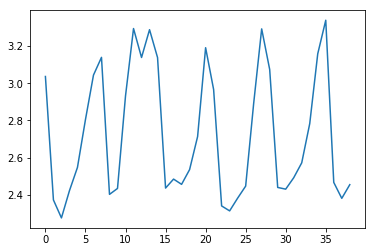

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.023283   
air_0164b9927d20bcc3_2017-04-23              1.388704   
air_0241aa3964b7f861_2017-04-23              2.441257   
air_0328696196e46f18_2017-04-23              2.005738   
air_034a3d5b40d5b1b1_2017-04-23              3.434529   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   6.563118  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.009649  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.487470  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.431578  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.016791

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')